This notebook describes the process of applying cuts and selection criteria to data such that all discharge events are extracted at the end. Additionally, it describes the process of calculating the range of the baseline events, which will be utilised in future notebooks.

In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit
from collections import Counter

In [2]:
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() # we require this to read 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T000810Z_tier_raw.lh5'

In [3]:
f = open('channel_maps.json','r')
cmap = json.load(f)

In the following section all the bege detector are extracted from the json file. Then all these detectors are added a ch to the beginning this is because the json file stores just the numbers of the detectors but these are differently stored in the files.

In [4]:
target_bege = "bege"

matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
ch = "ch"

detectors_bege = [ch+element for element in matching_bege]

**Initial Imports**

In this section I import all the data and form dictionaries so the data can easily be acsessed throughout the notebook. 

In [6]:
tb_data_dict = {}  # Dictionary to store tb_data for each detector
wfs_all_dict = {}  # Dictionary to store wfs_all for each detector

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0] # data 
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda # waveforms 

**Minimum value determination**

Determining the minimum values of the waveforms.

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of the waveform.
    Inputs:
    wfs_all_dict - dictionary to access the waveforms 
    index - detector name 
    Outputs:
    min_values - minimum values of the waveforms for the detector index
    """
    wfs_all = wfs_all_dict[index] #extracts all waveforms in a detector 
    min_values = [] #empty list to store the minimum values 
    
    # Loop through all waveforms to find the min values 
    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        # Find min values of the current waveform
        wf_min = np.min(wf0)
        # Append min values to the empty list
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j)

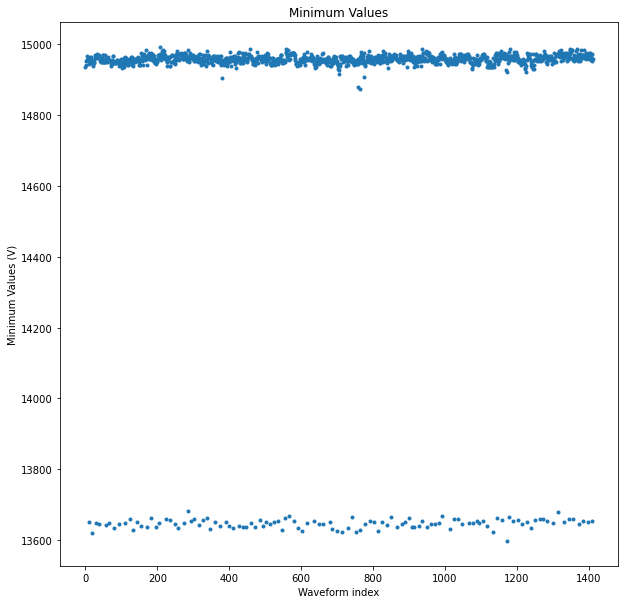

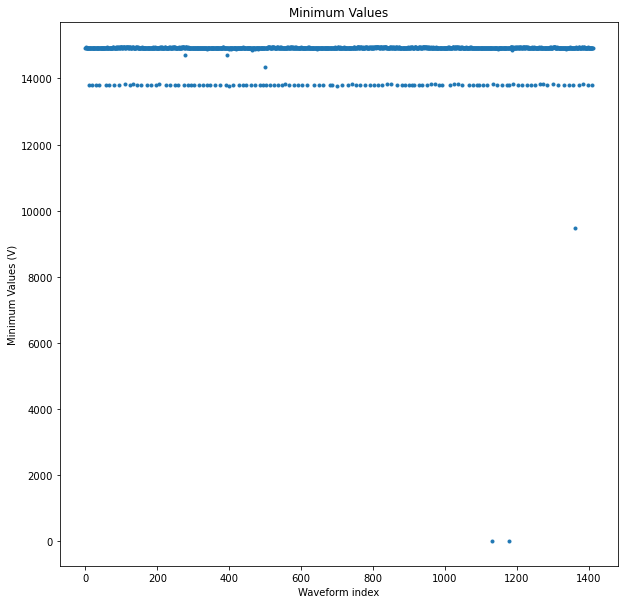

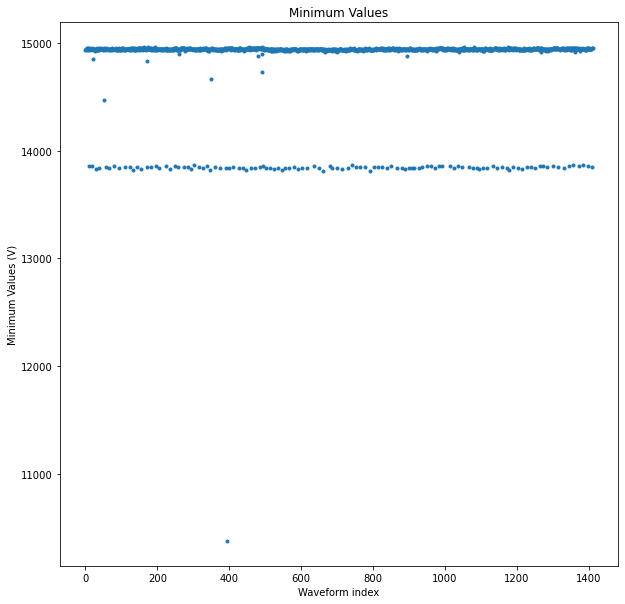

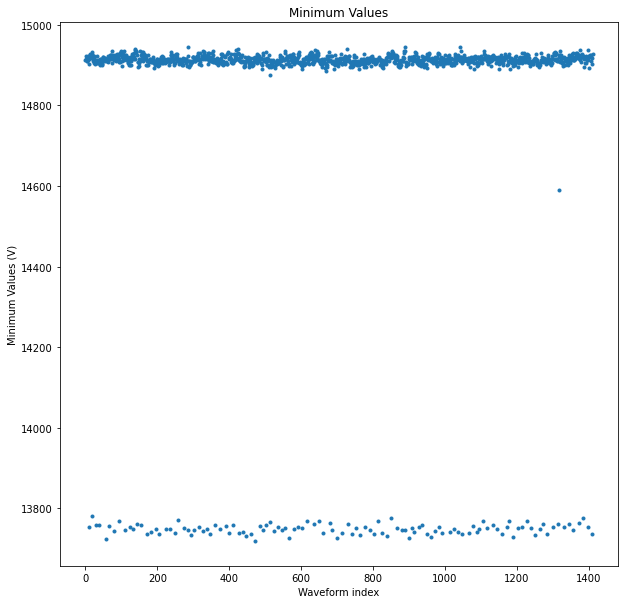

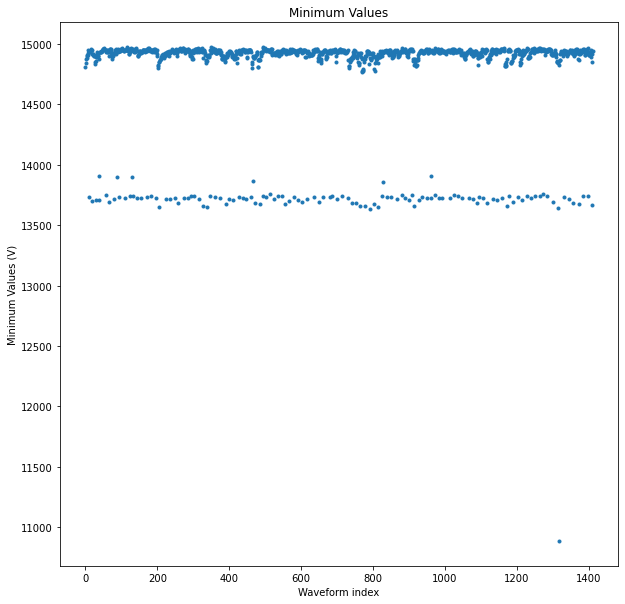

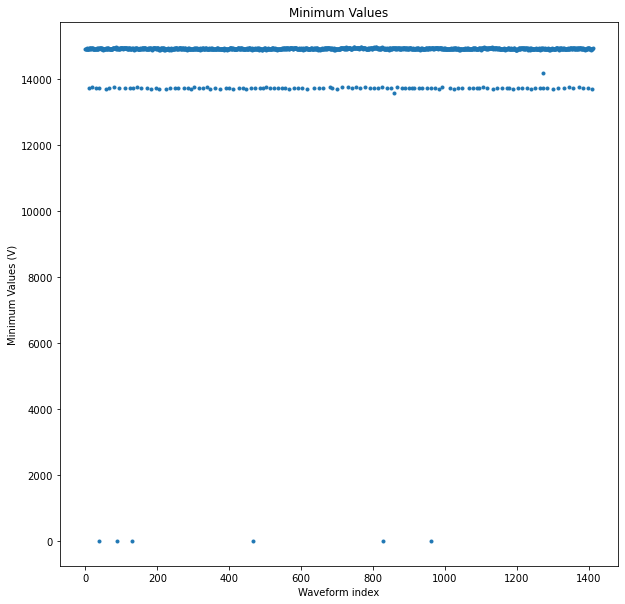

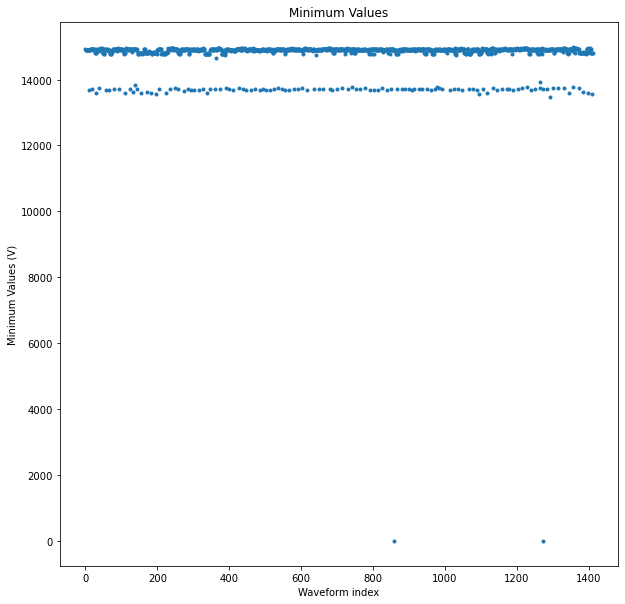

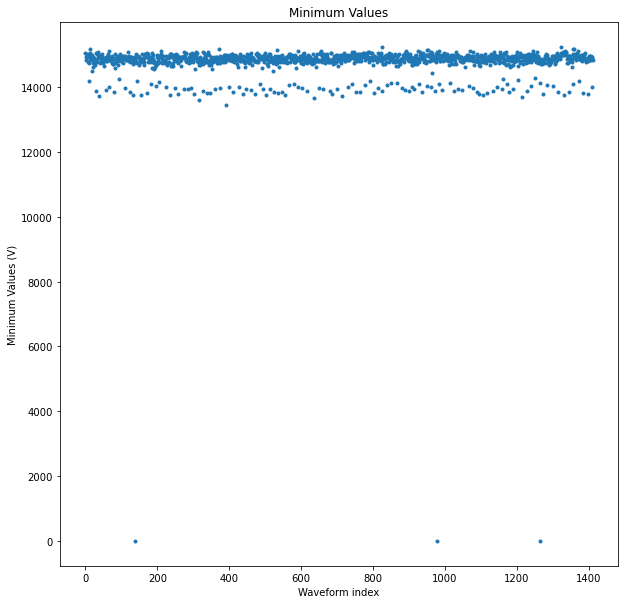

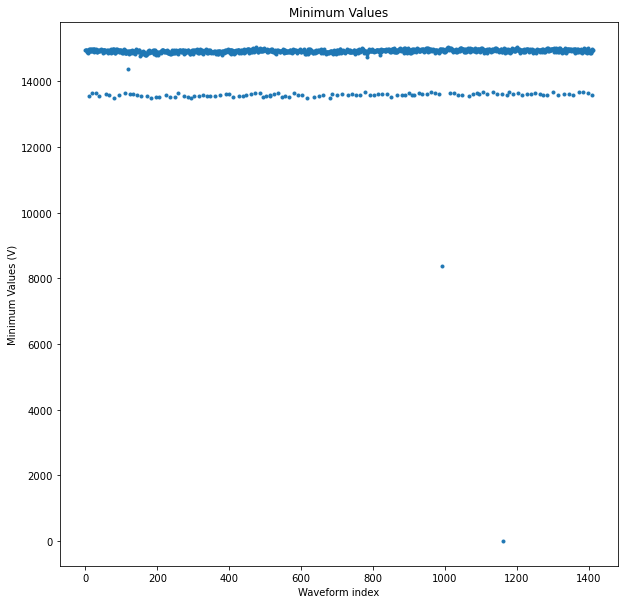

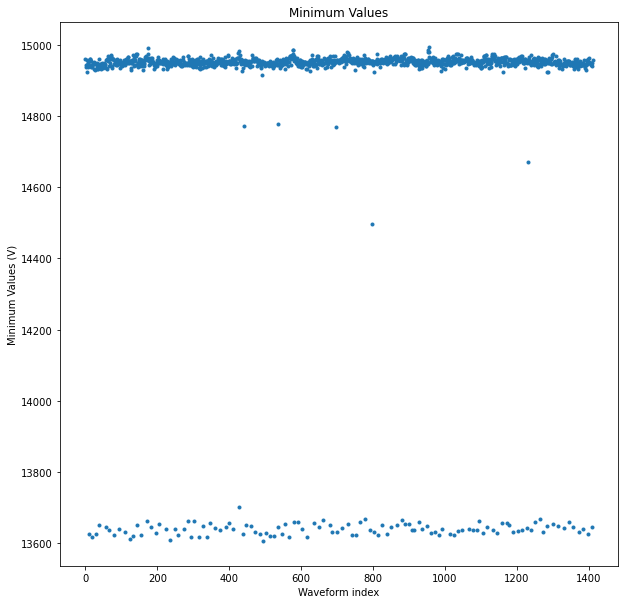

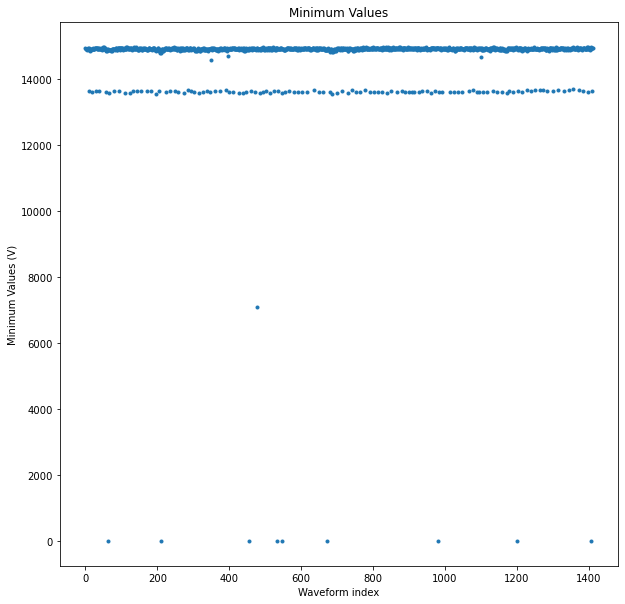

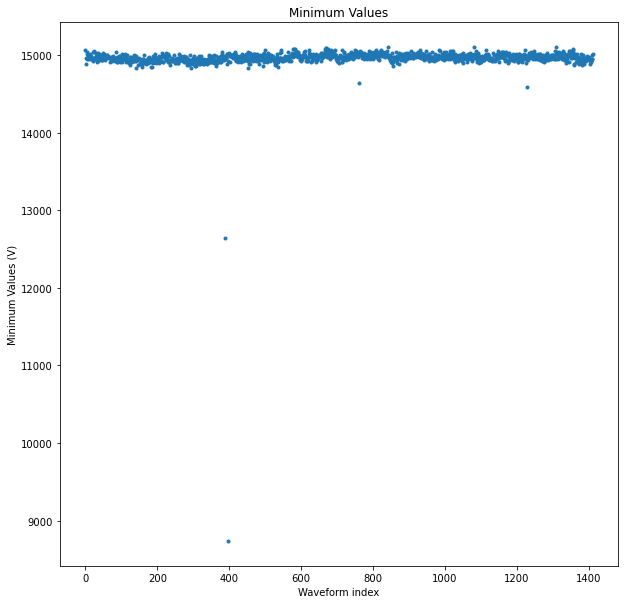

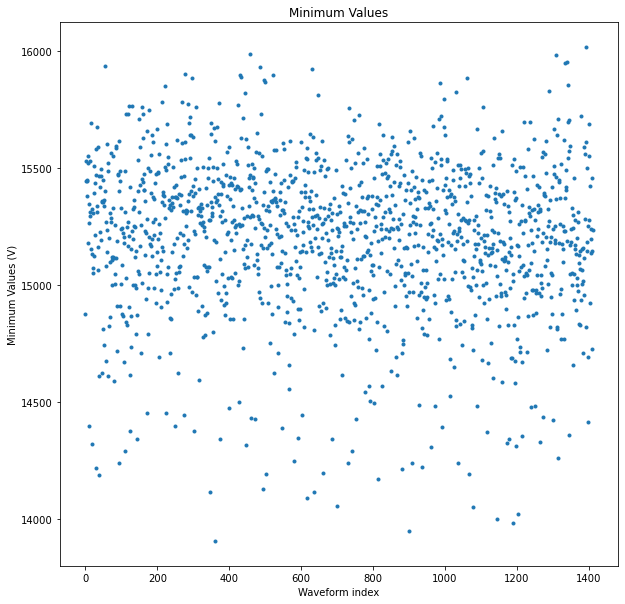

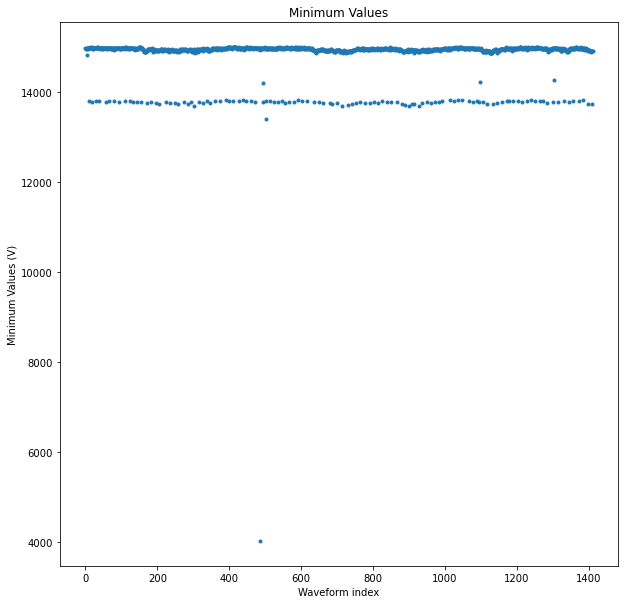

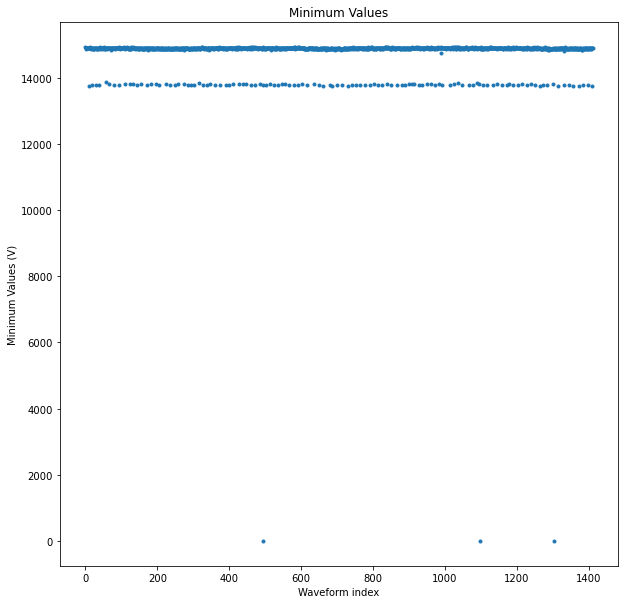

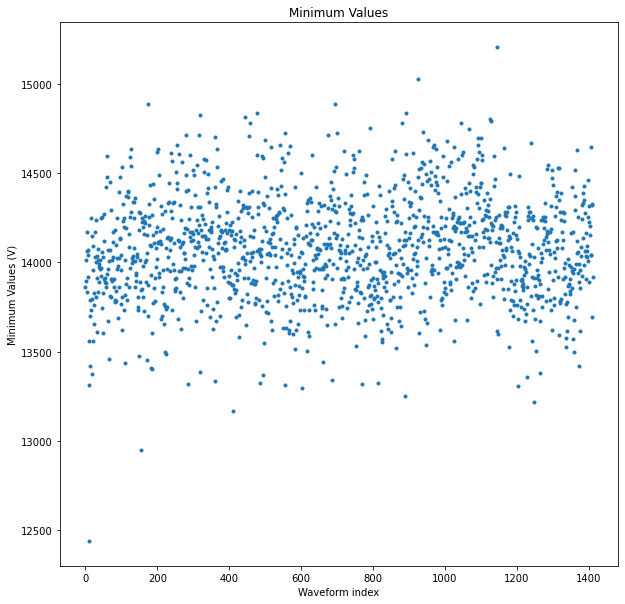

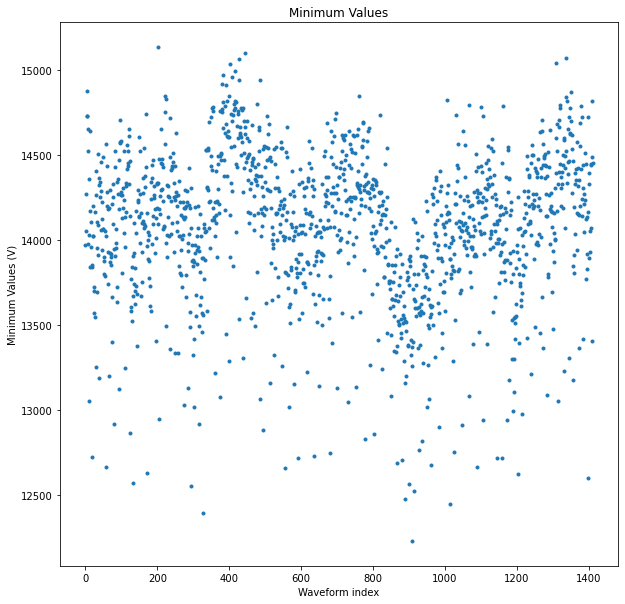

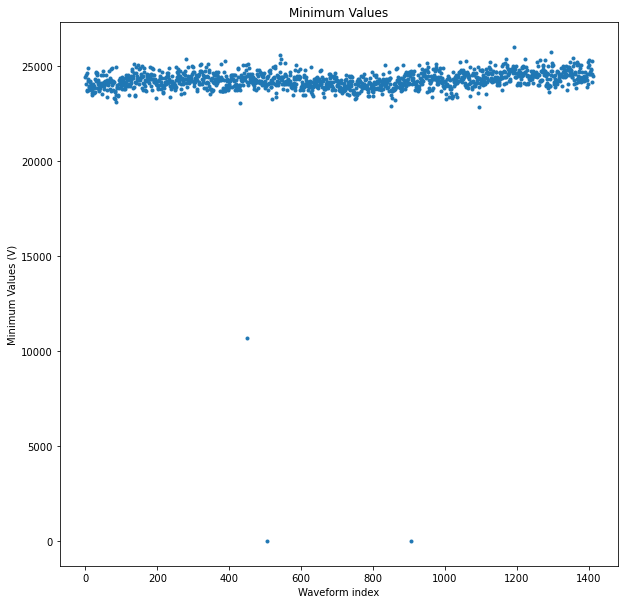

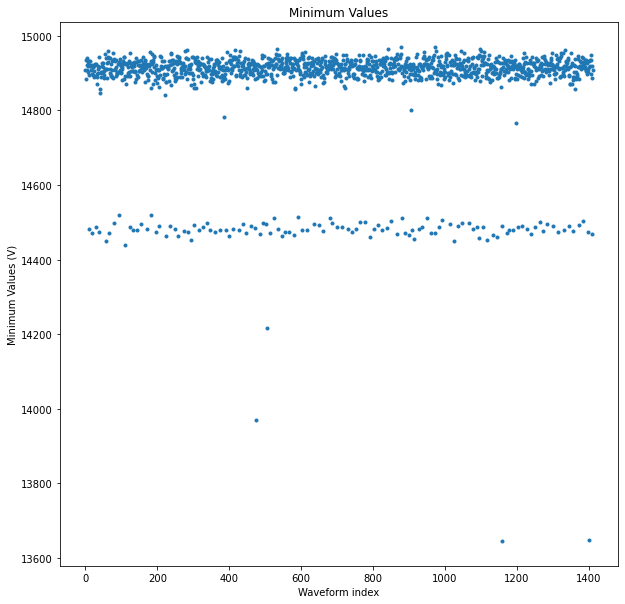

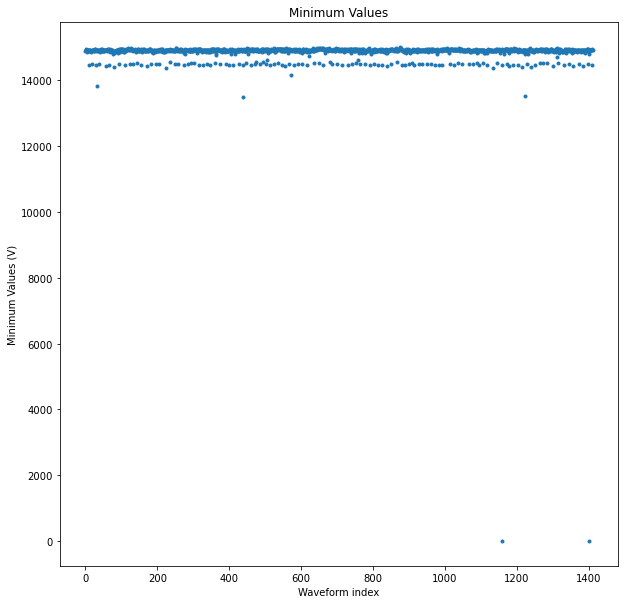

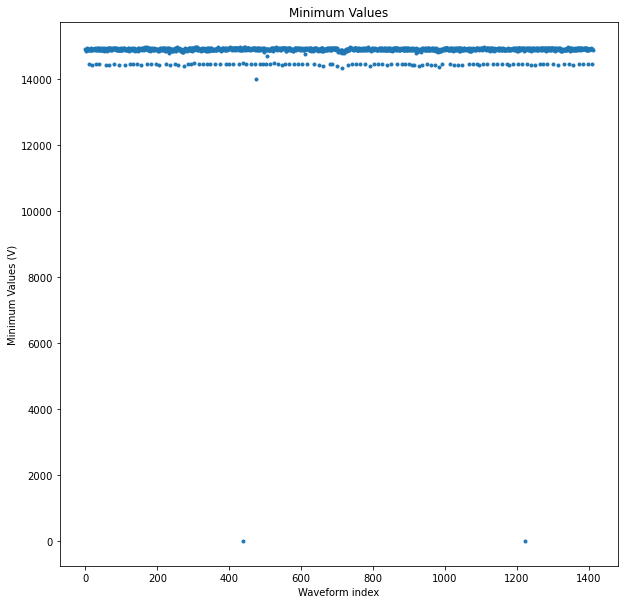

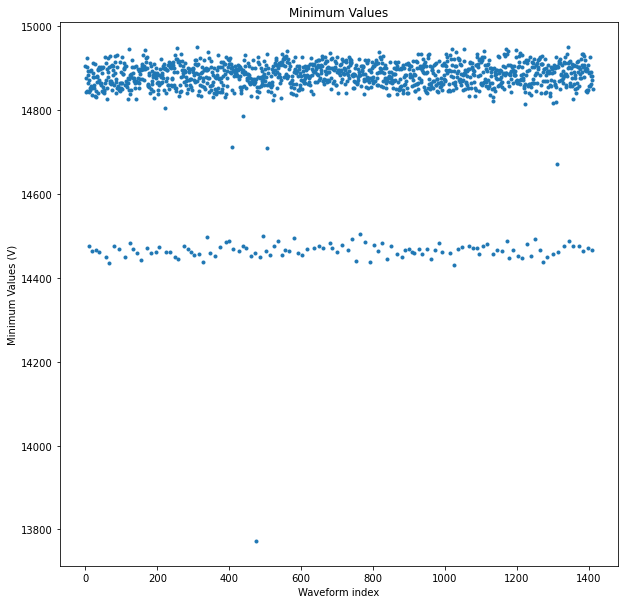

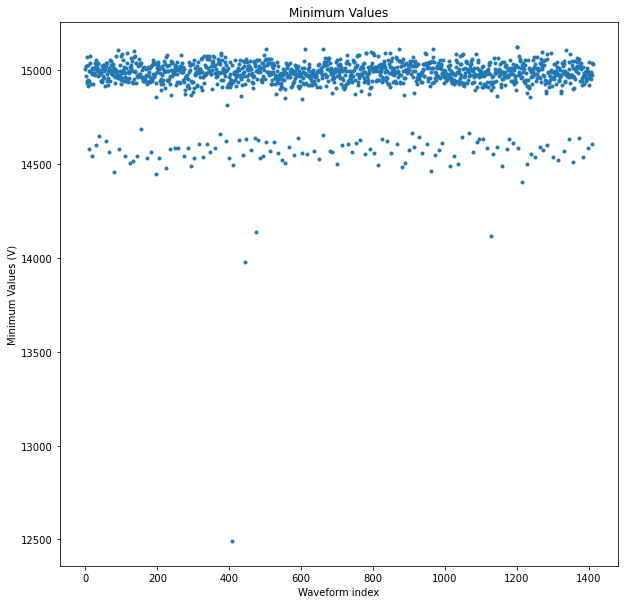

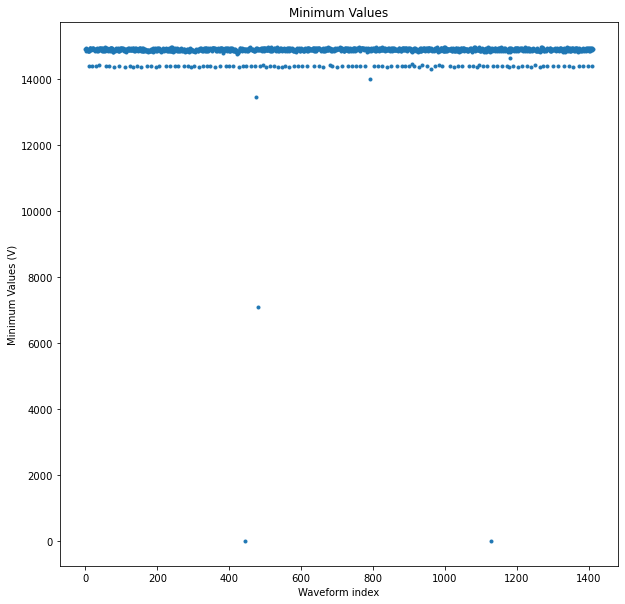

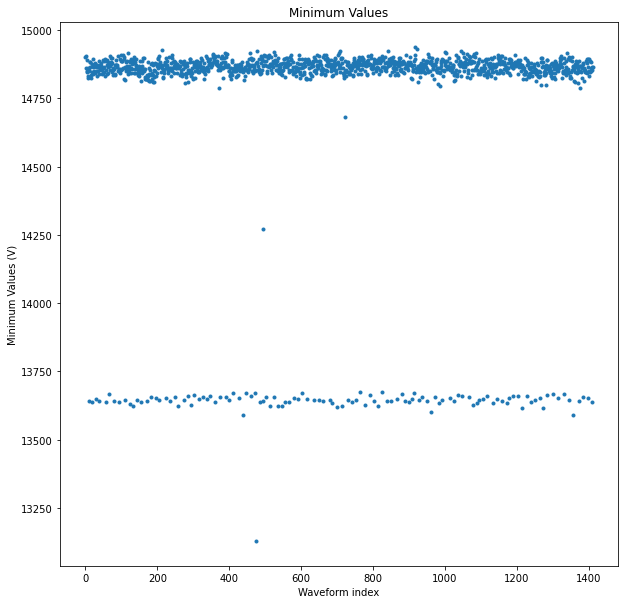

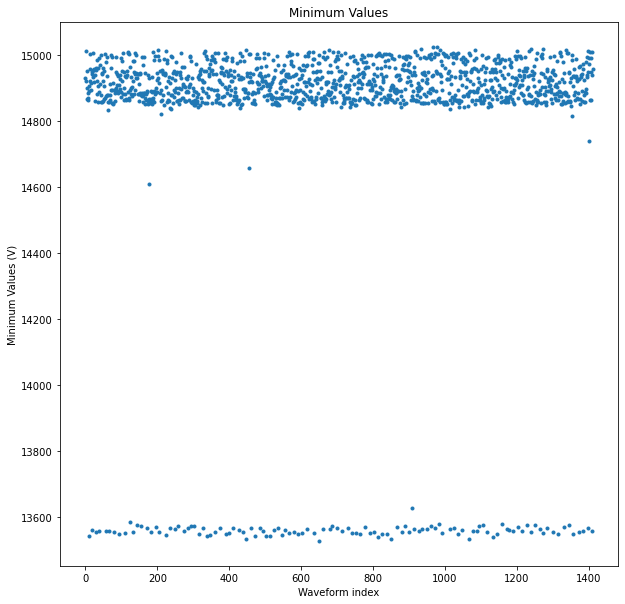

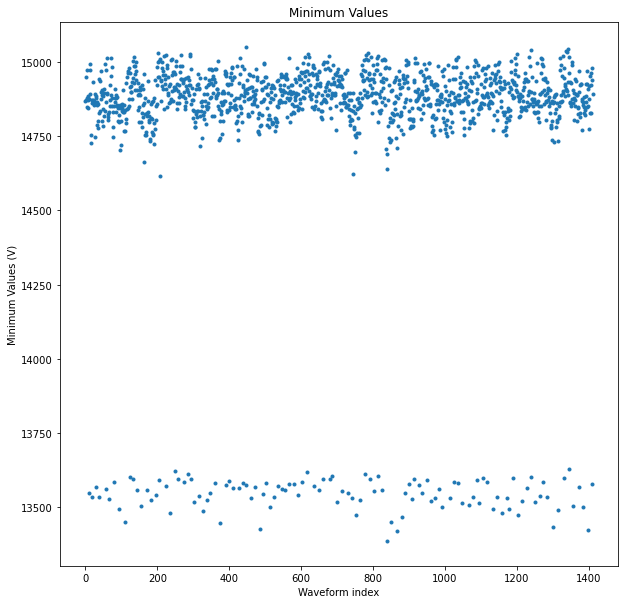

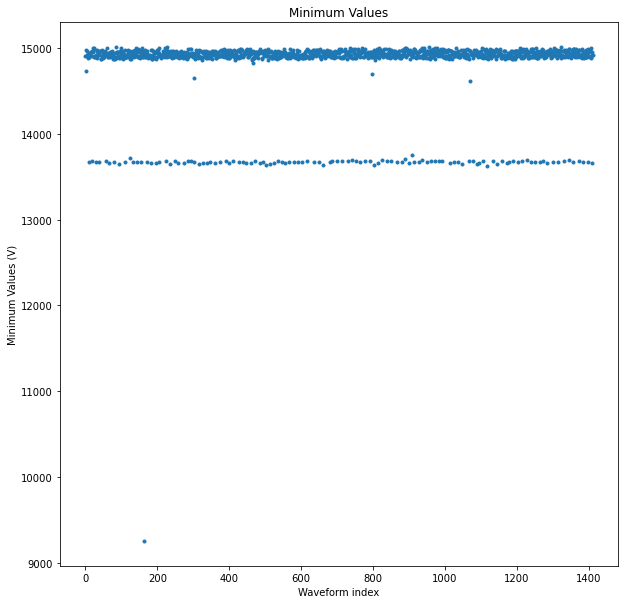

In [9]:
#plotting the minima 
for detector, min_values in minimum_dict.items():
    plt.plot(min_values,'.')
    plt.xlabel('Waveform index') 
    plt.ylabel('Minimum Values (V)')
    plt.title('Minimum Values')
    plt.show()

**Initial cuts**

All discharge events typically have a smaller minimum value than calibration events or baseline event and hence they can be removed using the z-score.

In [10]:
def zcalc(zscore_threshold,min_values):
    """ Calculates the z-score of the min_values and removes values beyond a 
    threshold number of deviations from the mean using the zscore_threshold.
    Inputs:
    zscore_threshold - number of standard deviations from the mean to remove a minimum point
    min_values - The array of minimum values 
    """
    # z-score of the minima
    min_z_scores = zscore(min_values)
    
    # empty lists to store the values 
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    #loop through the z-score  and eliminate uncessary results
    for i, z_score in enumerate(min_z_scores):
        # Check if the minimum is beyond the mean by the threshold standard deviation 
        # we keep these values 
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            continue
        
        # If not beyond the threshold they are appended as values removed 
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
        
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [11]:
threshold = 1 #choose one standard deviation as the threshold
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

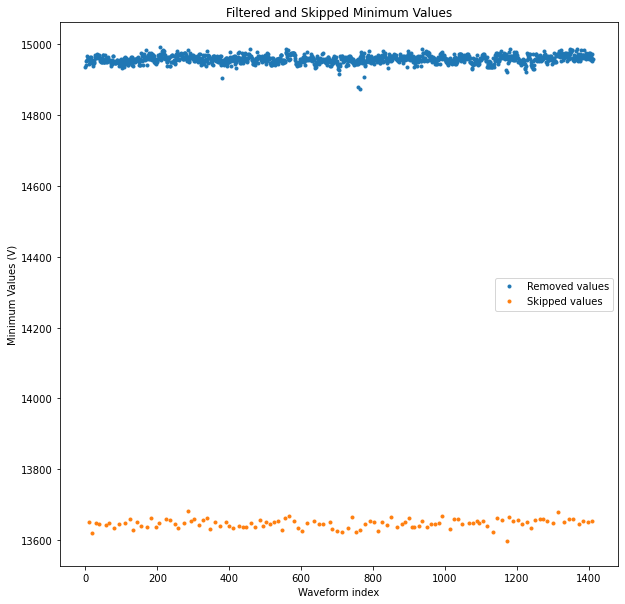

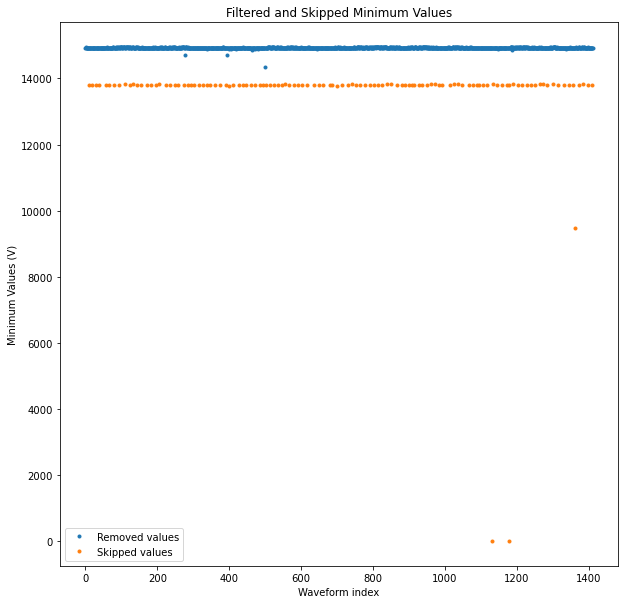

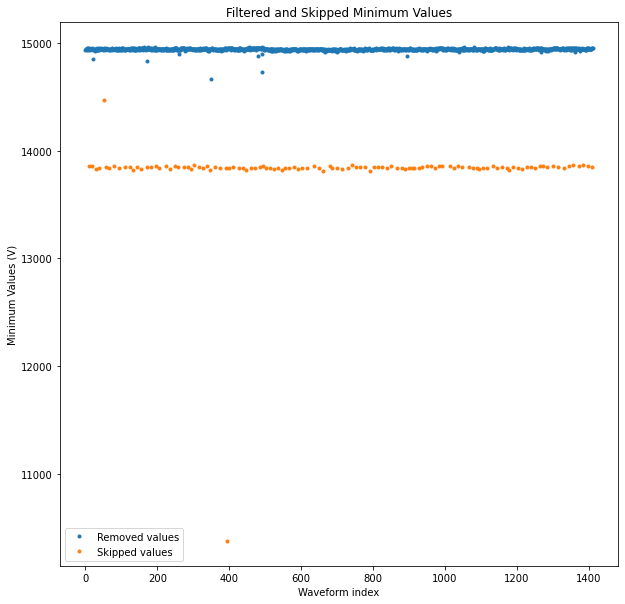

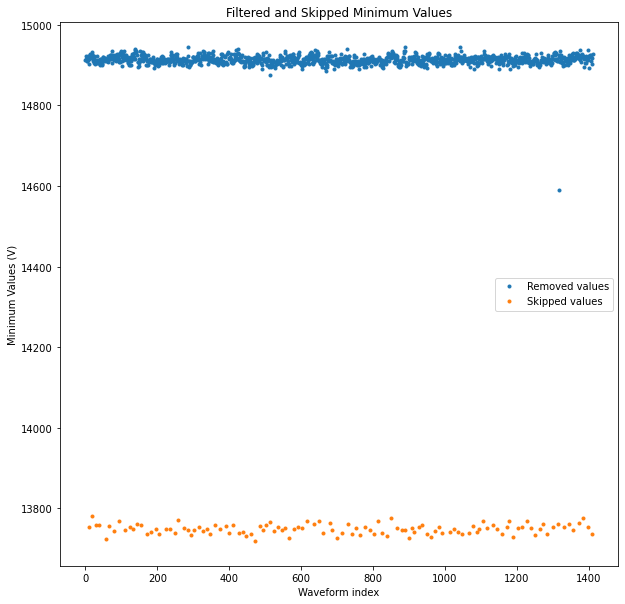

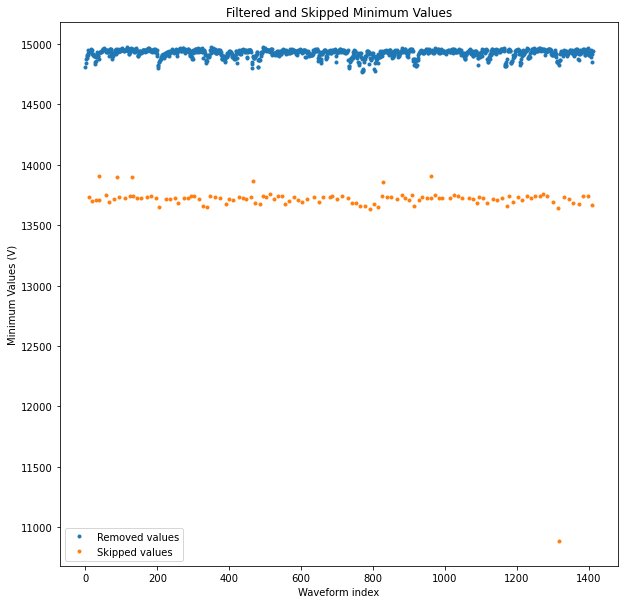

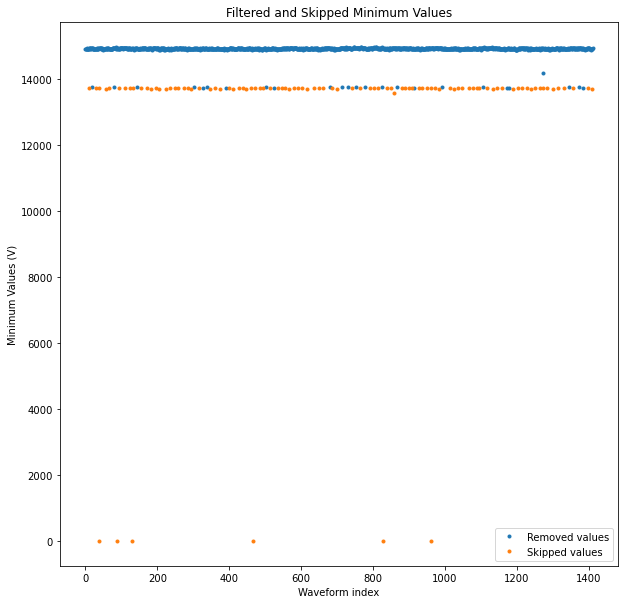

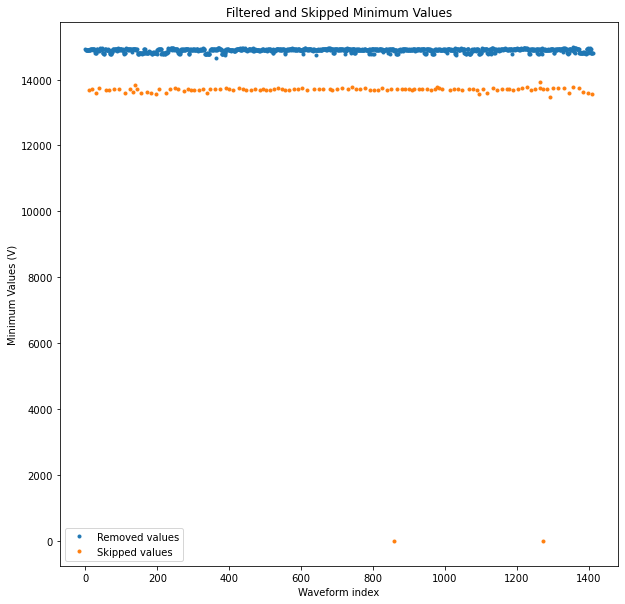

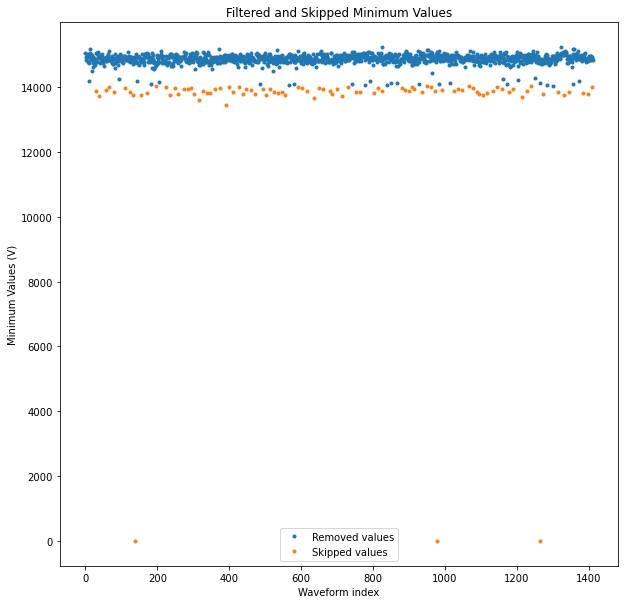

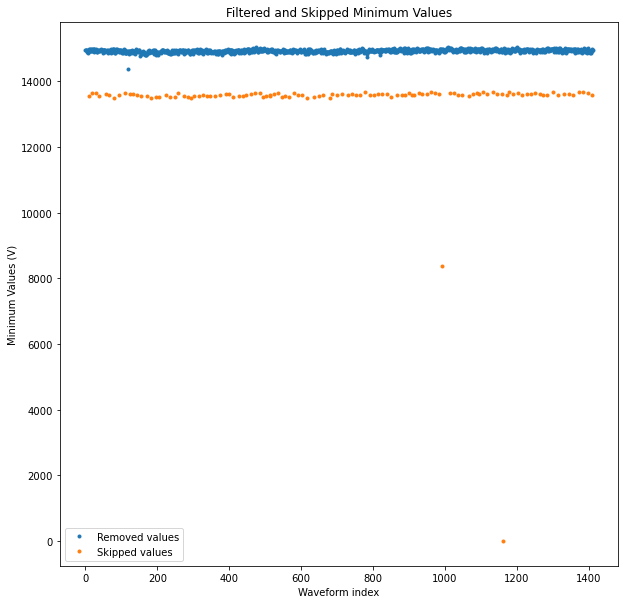

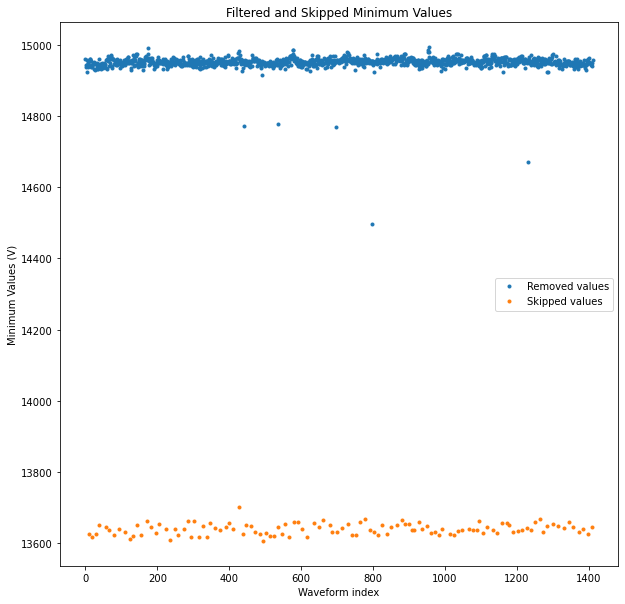

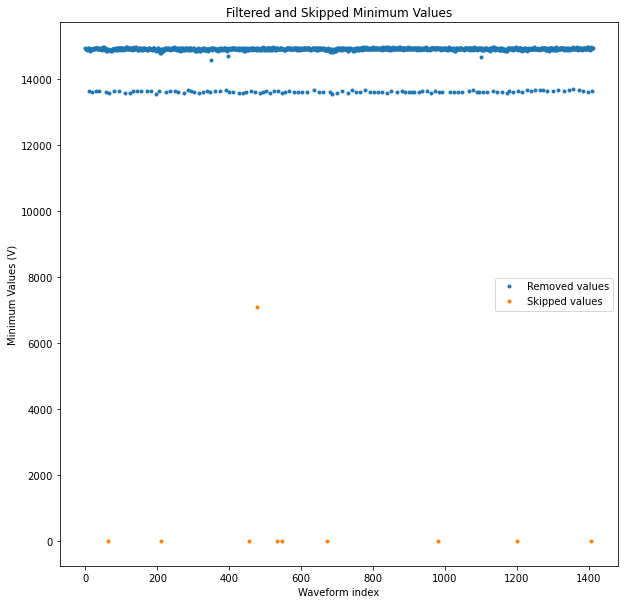

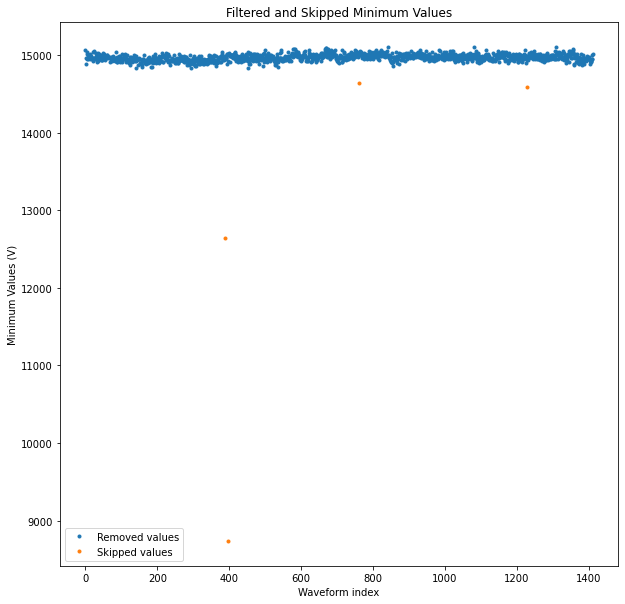

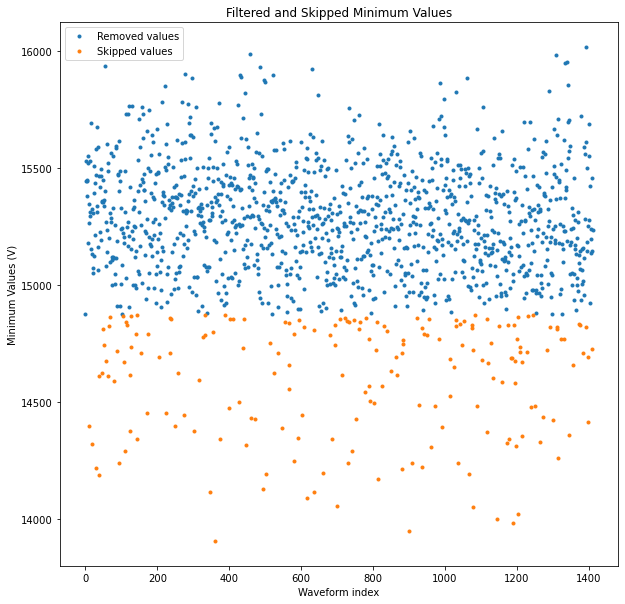

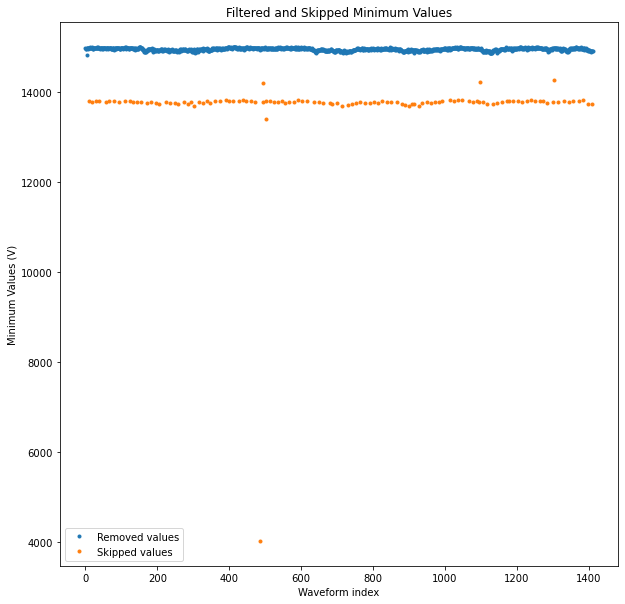

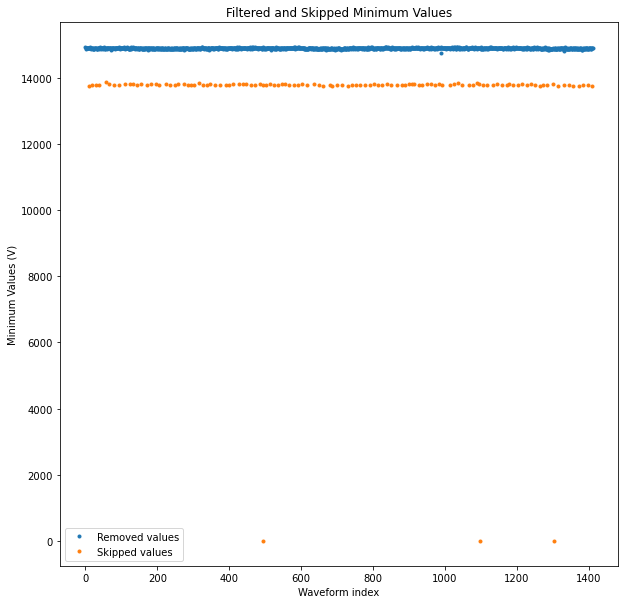

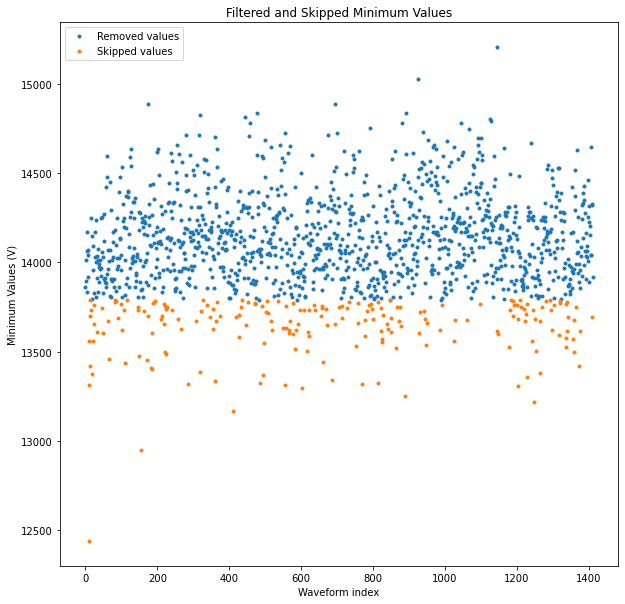

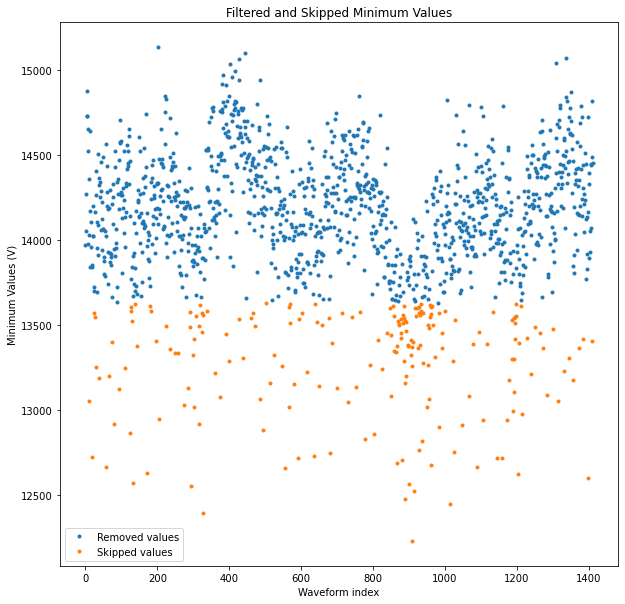

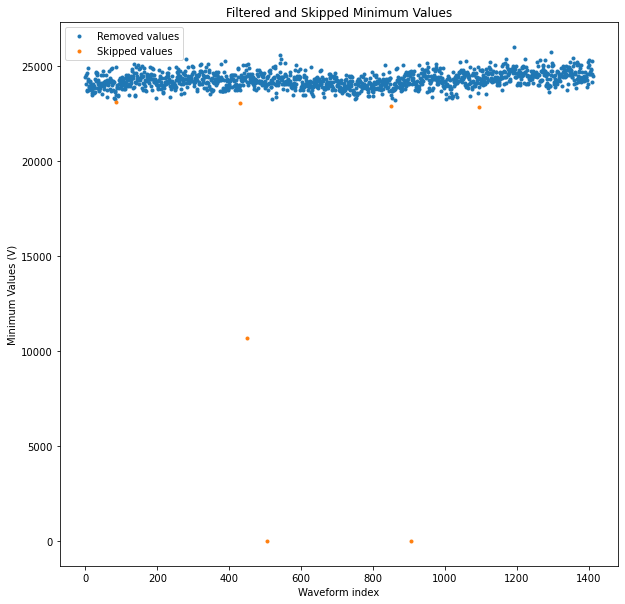

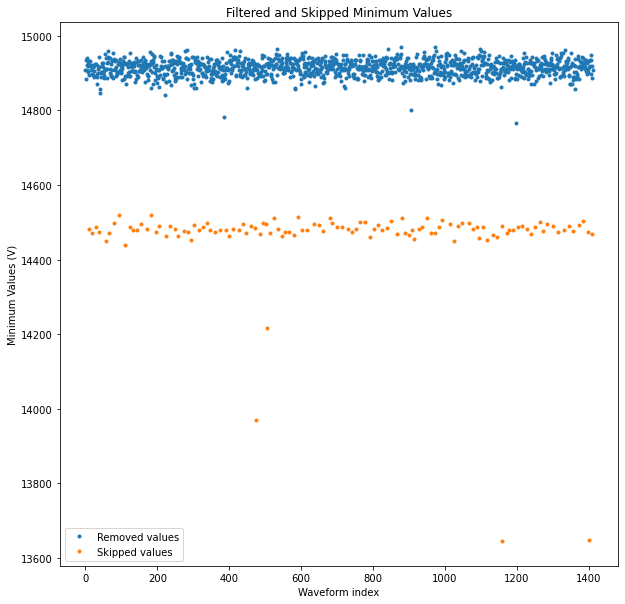

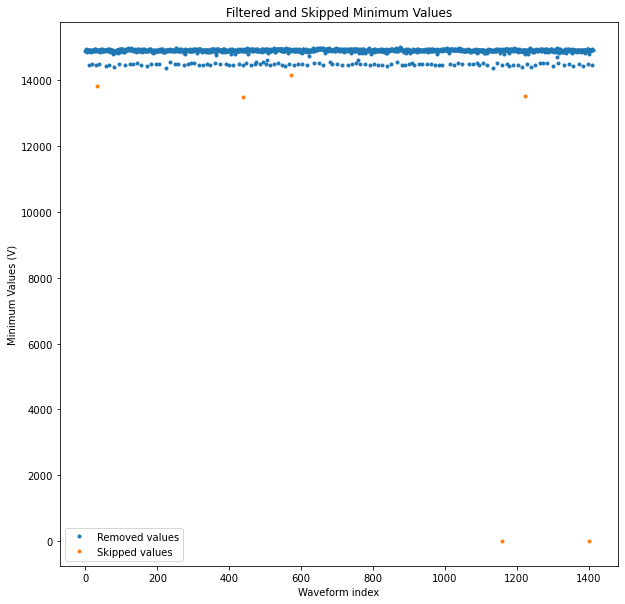

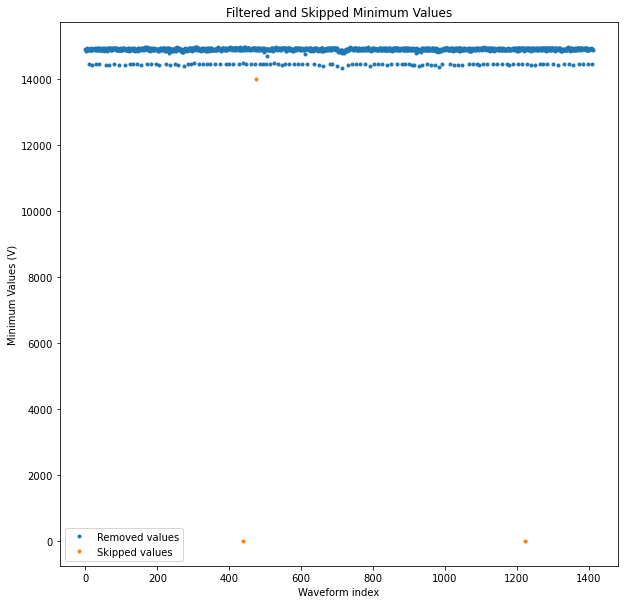

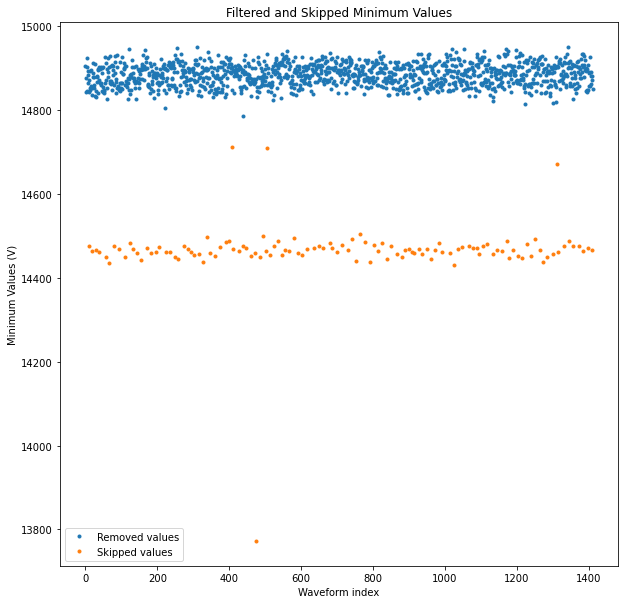

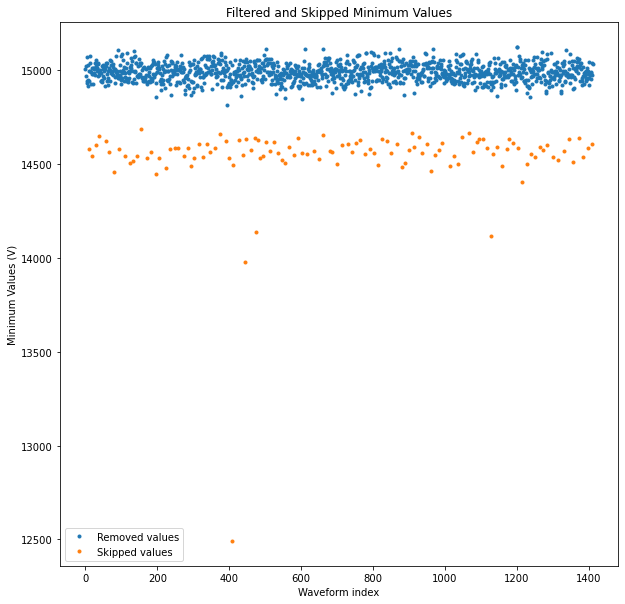

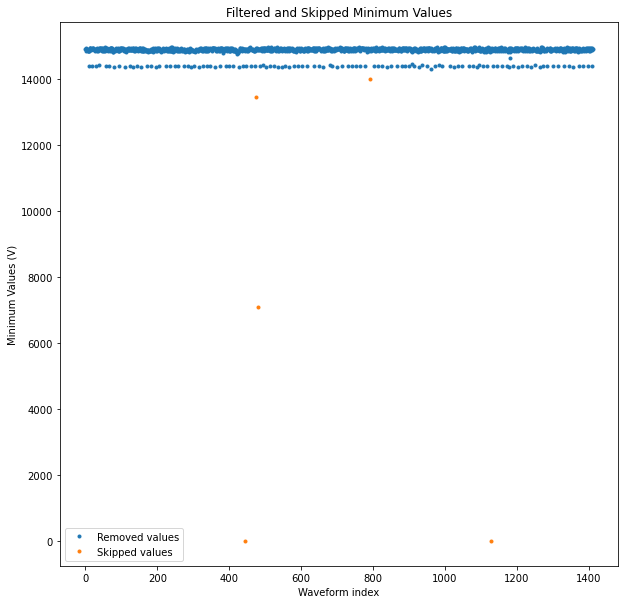

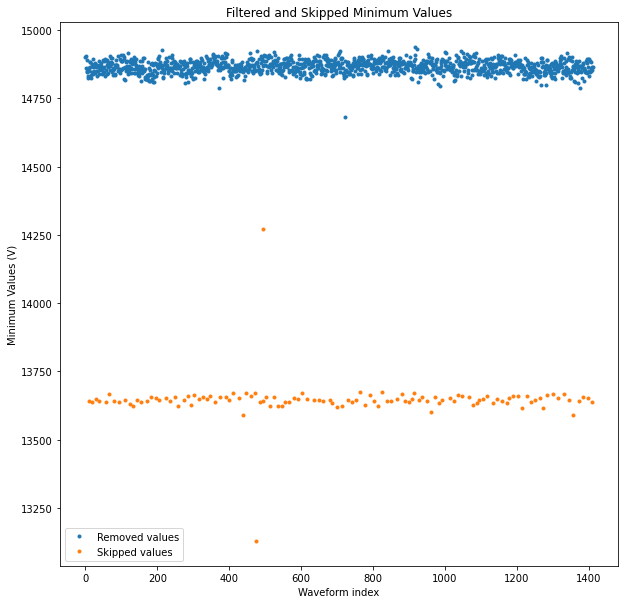

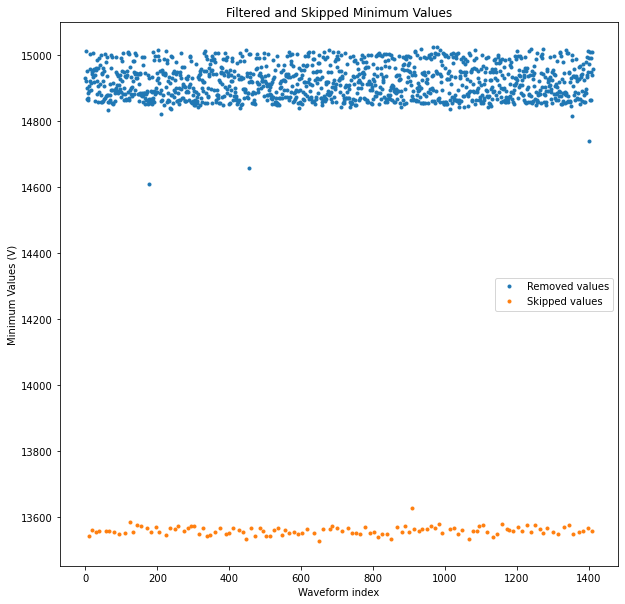

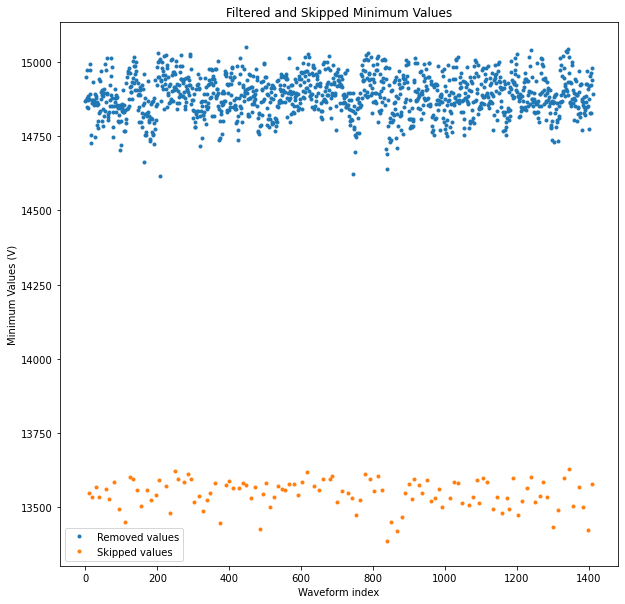

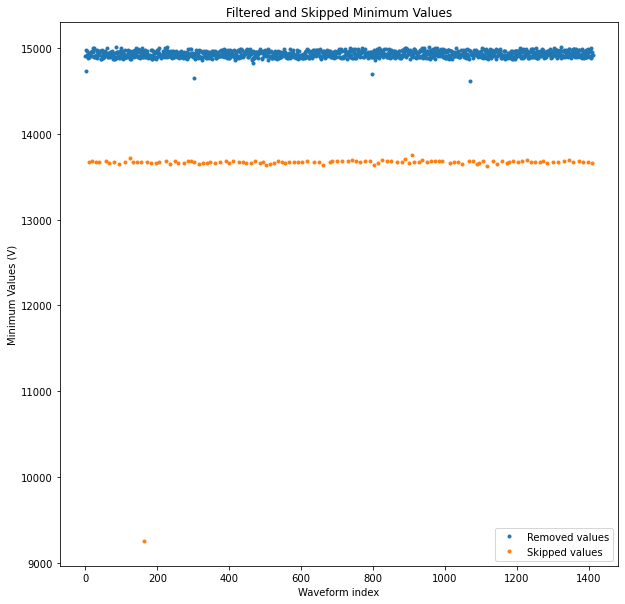

In [12]:
#plotting the minima with those minima which have been removed through the first cut 
# and the minima which survived the cut 
for detector in detectors_bege:
    plt.plot(filtered_index[detector],filtered_values[detector], '.',label=f'Removed values')
    plt.plot(skipped_index[detector],skipped_values[detector], '.',label=f'Skipped values')
    
    plt.xlabel('Waveform index') 
    plt.ylabel('Minimum Values (V)') 
    plt.title('Filtered and Skipped Minimum Values')
    plt.legend()
    plt.show()


**Determining the baseline**

Here we have a slight deviation as we needed to determine the range of the baseline.

In [13]:
range_bege = []
all_bege =[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    filters = filtered_index[j] #taking the removed waveforms from the first cut 
    for i in filters:
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0) 
        wf_max = np.max(wf0)
        diff = wf_max - wf_min #range of the waveform
        std = np.std(wf0) 
        all_bege.append(std)

        if std < 13: #this value was picked after checking the smallest standard deviation in all waveforms 
            range_bege.append(diff)
            #ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            #plt.plot(ts[:], wf0[:], '.', label=f'Event {i}')  # plot each skipped waveform
            #plt.xlabel('Time ($\mu s$)')
            #plt.ylabel('Voltage (mV)')
            #plt.title(f'Skipped events in detector {j} which is a')
            #plt.legend()
            #plt.show()

In [14]:
integer_list = [int(value) for value in all_bege] # converts all standard deviations into integers 

no_std = Counter(integer_list) #number of each standard deviation

for number in sorted(no_std): 
    print(f"{number}: {no_std[number]} times")

12: 494 times
13: 3129 times
14: 2188 times
15: 3292 times
16: 3804 times
17: 4301 times
18: 2822 times
19: 1778 times
20: 1064 times
21: 830 times
22: 791 times
23: 689 times
24: 586 times
25: 559 times
26: 449 times
27: 352 times
28: 317 times
29: 234 times
30: 212 times
31: 189 times
32: 180 times
33: 155 times
34: 166 times
35: 165 times
36: 150 times
37: 133 times
38: 122 times
39: 91 times
40: 83 times
41: 74 times
42: 58 times
43: 69 times
44: 55 times
45: 41 times
46: 33 times
47: 37 times
48: 12 times
49: 11 times
50: 14 times
51: 23 times
52: 14 times
53: 8 times
54: 12 times
55: 9 times
56: 7 times
57: 5 times
58: 10 times
59: 7 times
60: 4 times
61: 4 times
62: 14 times
63: 7 times
64: 14 times
65: 16 times
66: 8 times
67: 11 times
68: 11 times
69: 15 times
70: 16 times
71: 18 times
72: 24 times
73: 14 times
74: 28 times
75: 24 times
76: 18 times
77: 15 times
78: 26 times
79: 20 times
80: 24 times
81: 21 times
82: 24 times
83: 29 times
84: 25 times
85: 27 times
86: 32 times

In [15]:
standard = np.std(range_bege) #standard deviation of ranges
se = standard/len(range_bege) #error of the mean 
print(se/2)
print(np.mean(range_bege)/2) # we want the deviation ie ± of the baseline so we divide the range by 2 

0.005855016636892757
52.30769230769231


Another cut is necessary to remove the calibration events which will be conducted using the maximum values of the waveforms.

In [16]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of the waveform.
    Inputs:
    wfs_all_dict - dictionary to access the waveforms 
    index - detector name 
    Outputs:
    max_values - maximum values of the waveforms for the detector index
    """
    wfs_all = wfs_all_dict[index]#extracts all waveforms in a detector
    index_skip = skipped_index[index] #extract the remaining waveforms from the initial cut
    
    max_values = []#empty list to store the minimum values
    # Loop through all waveforms to find the max values
    for i in index_skip:
        wf0 = wfs_all[i, :]
        # Find max values of the current waveform
        wf_max = np.max(wf0)
        # Append max values to the list
        max_values.append(wf_max)
    
    return max_values

In [17]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

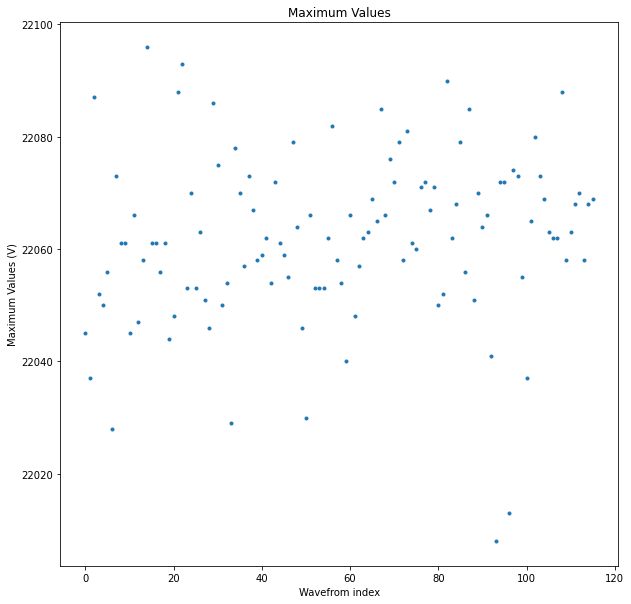

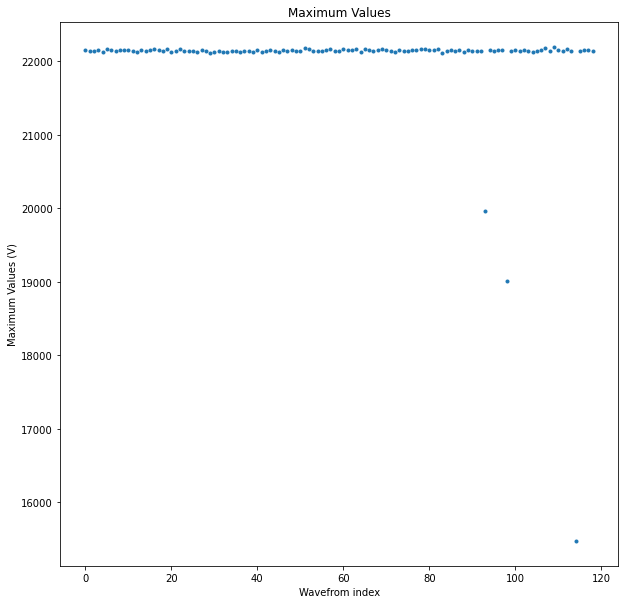

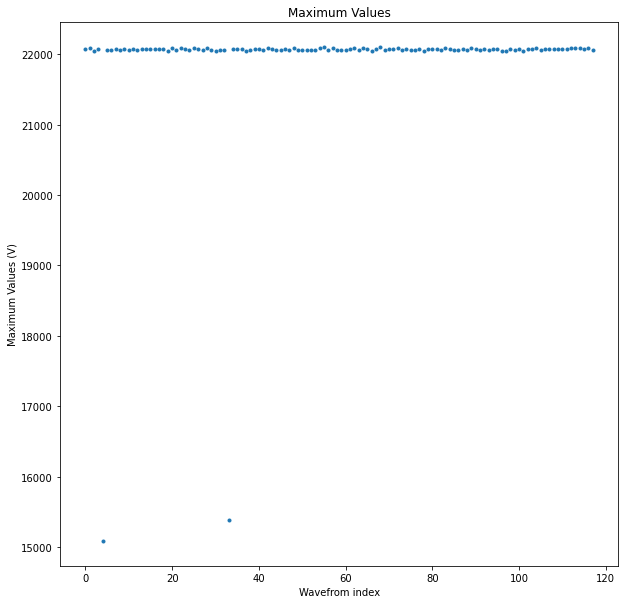

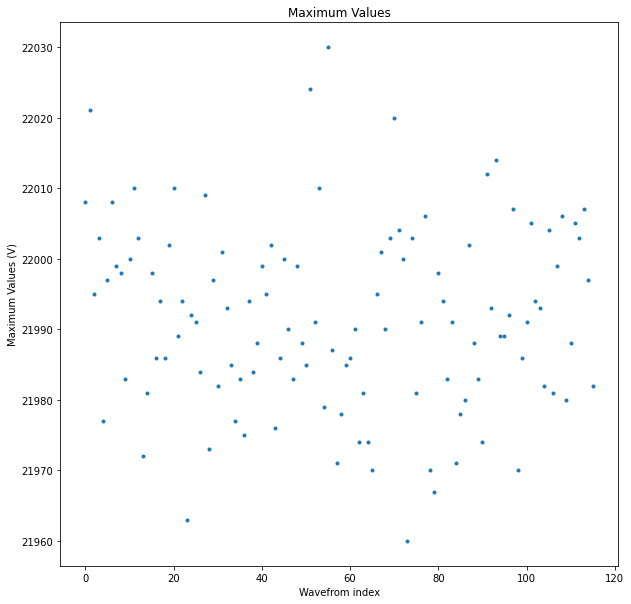

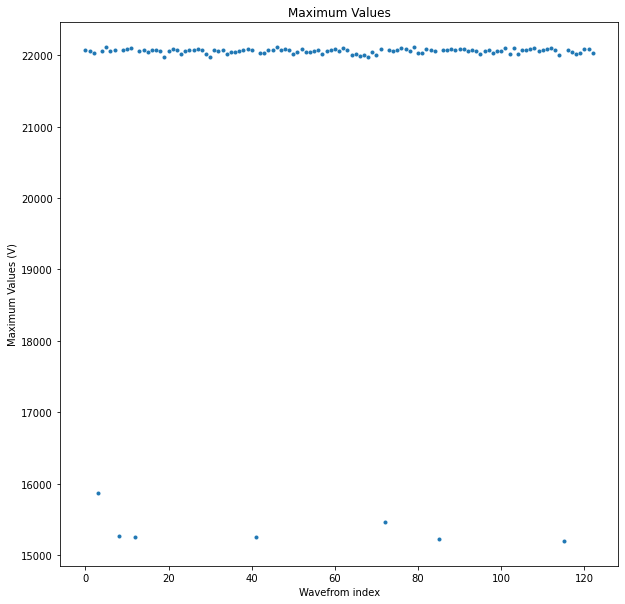

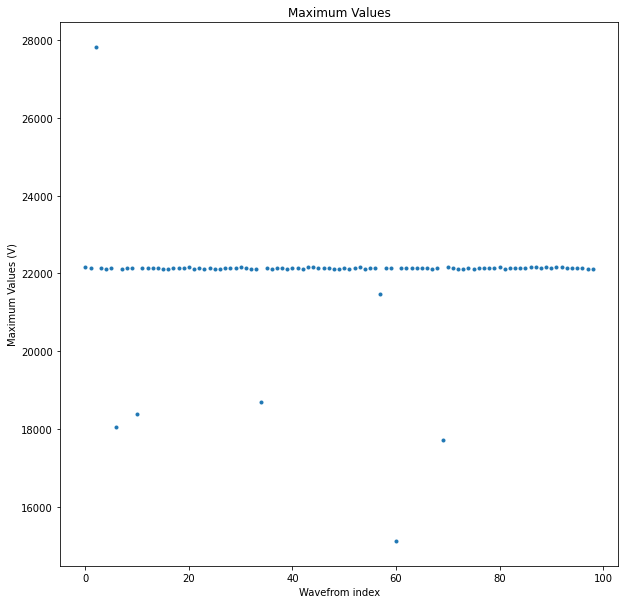

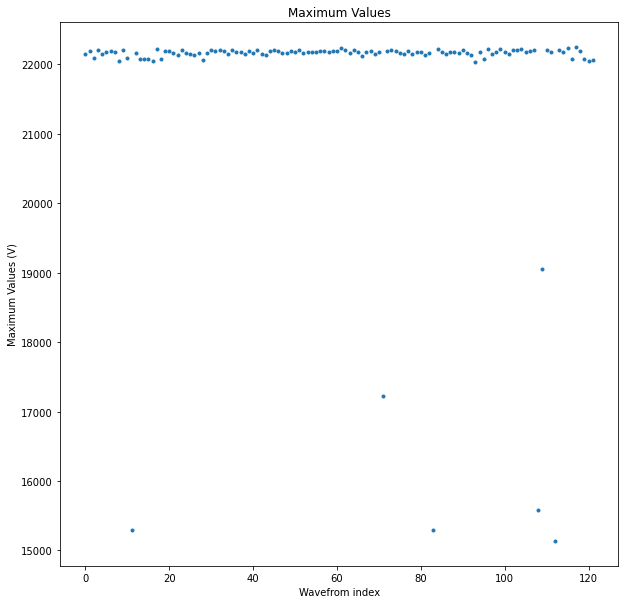

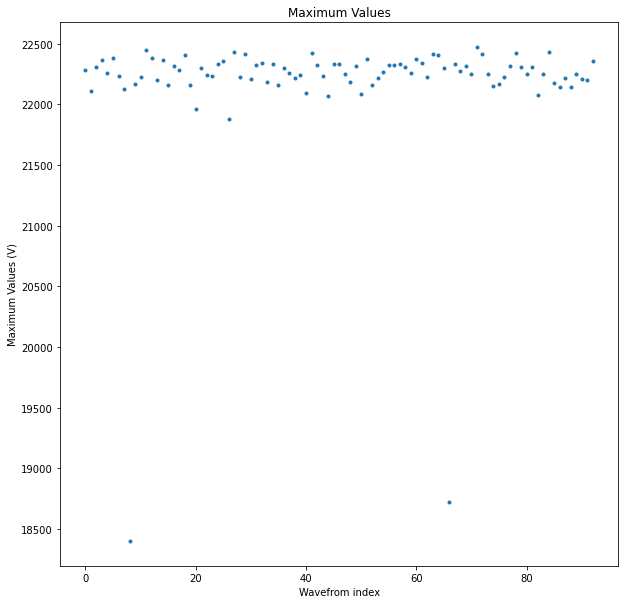

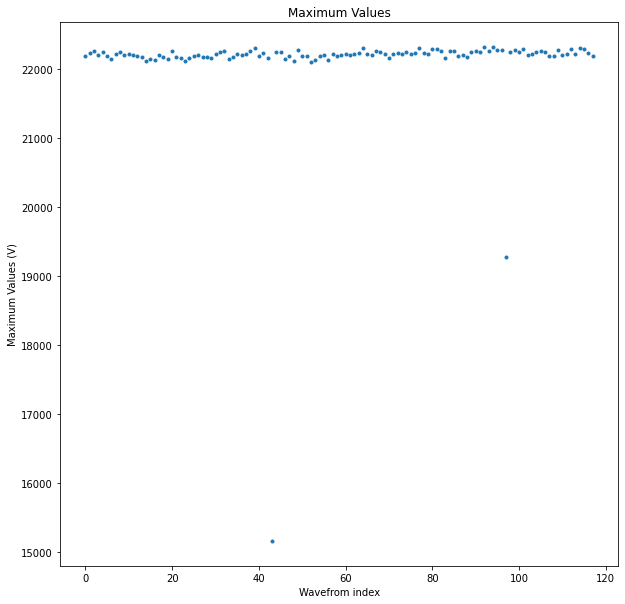

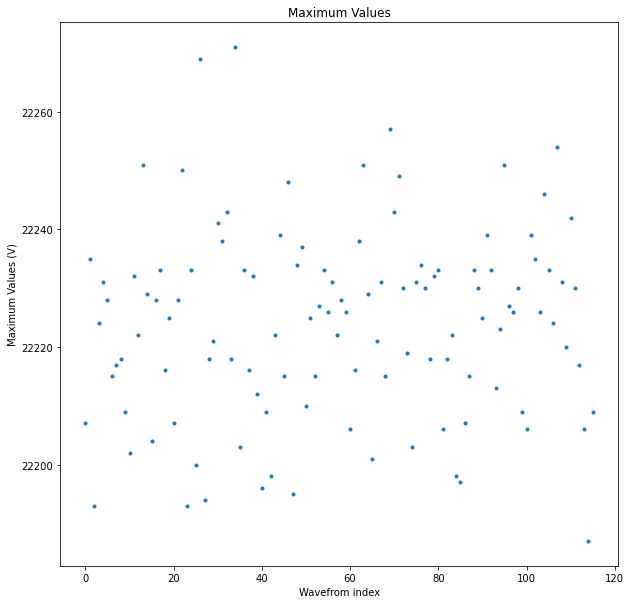

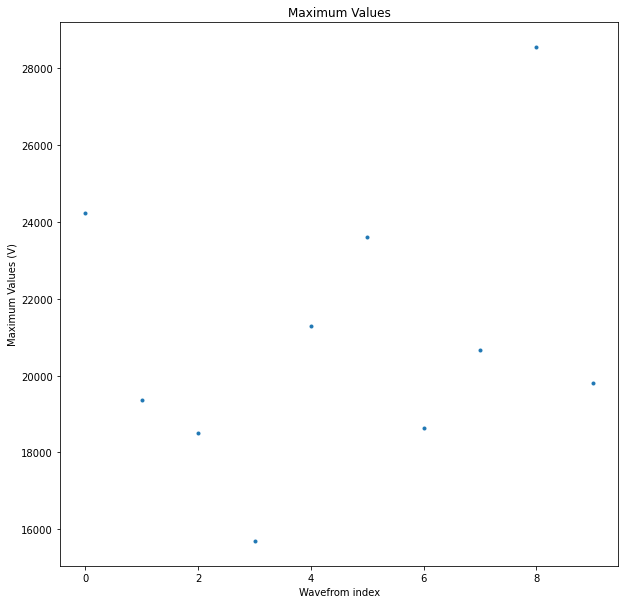

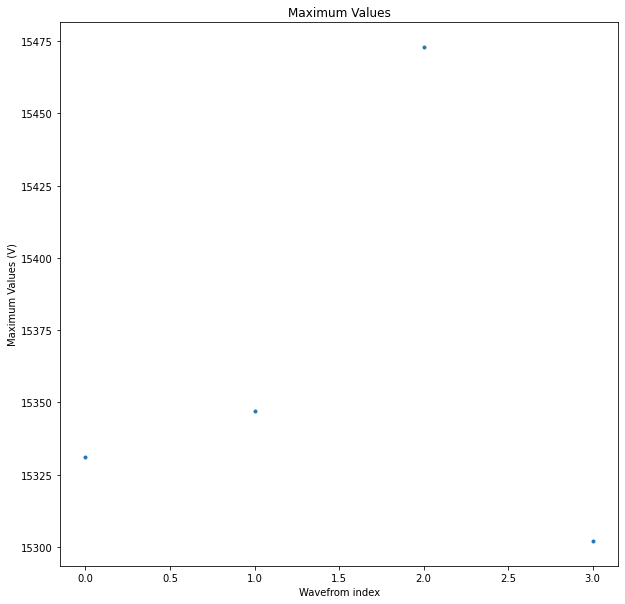

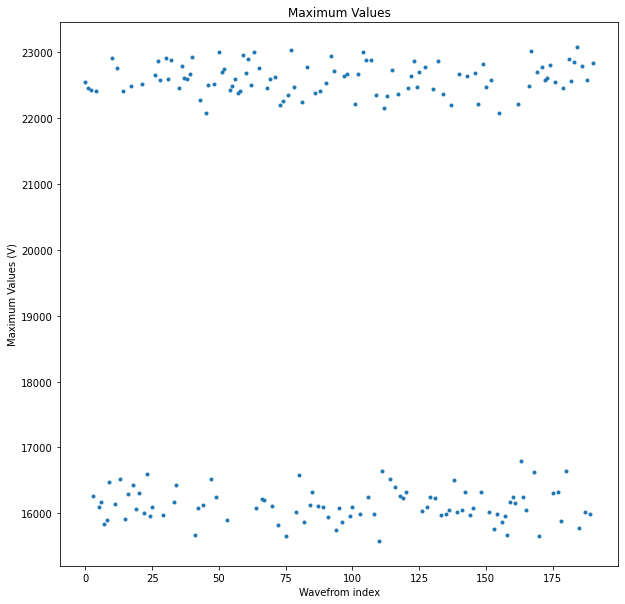

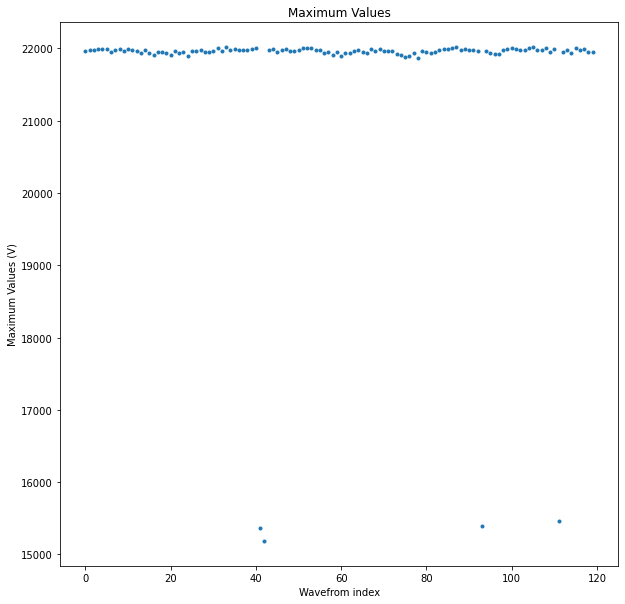

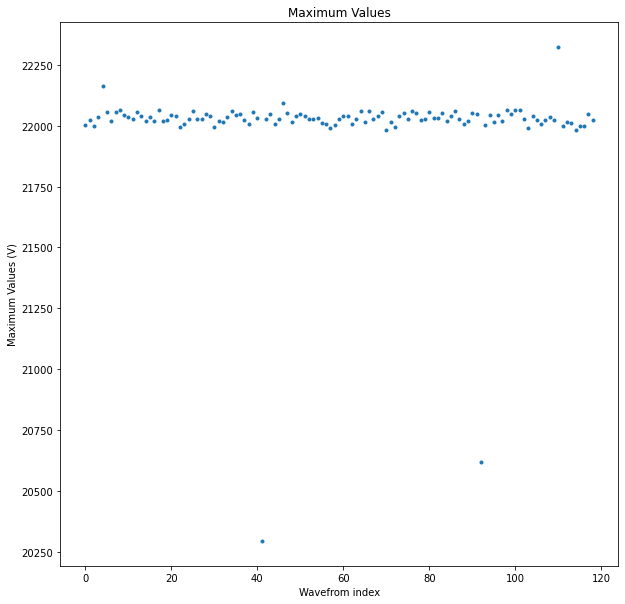

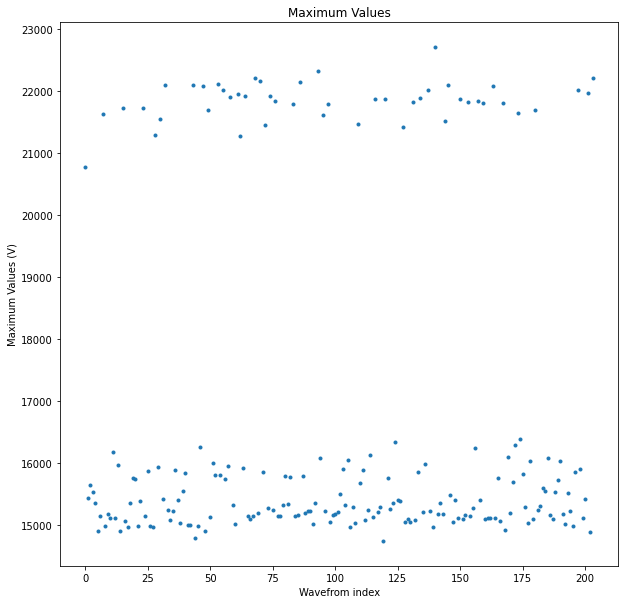

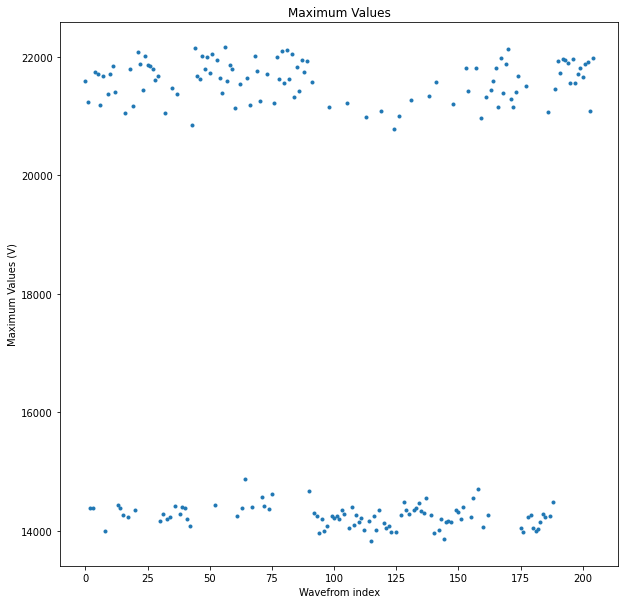

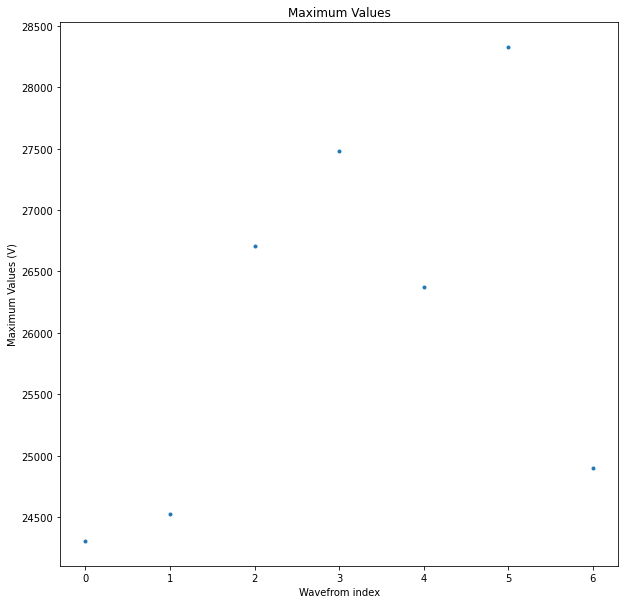

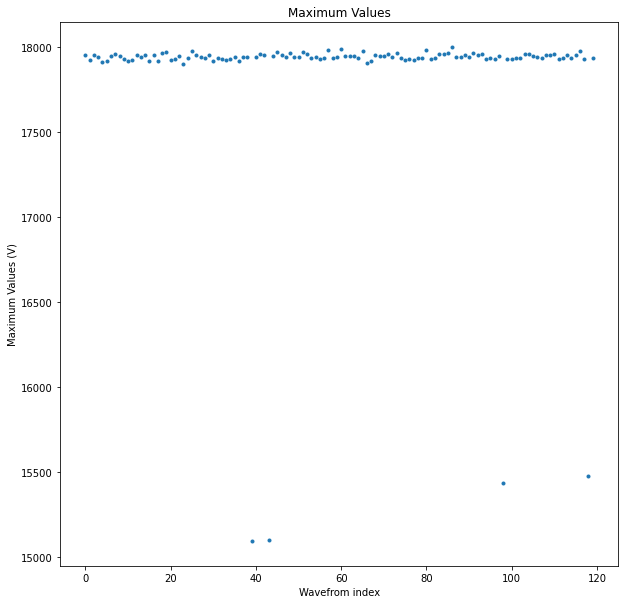

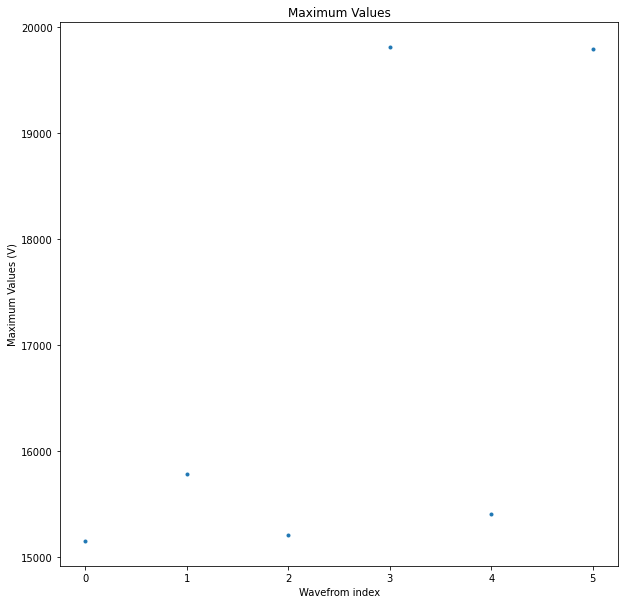

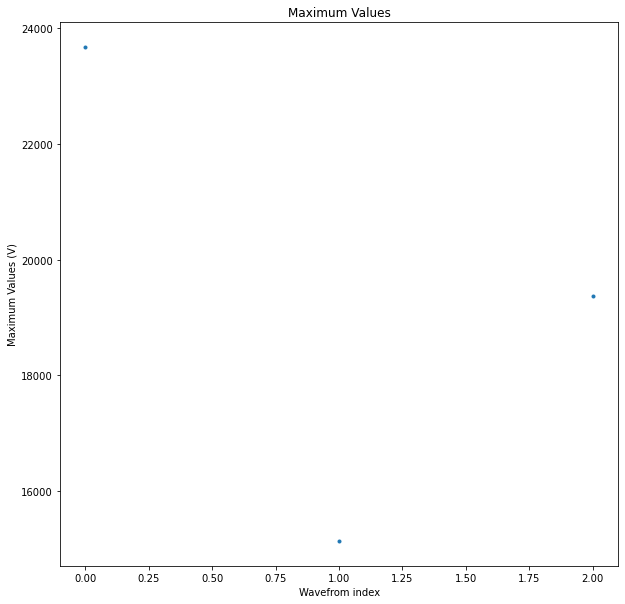

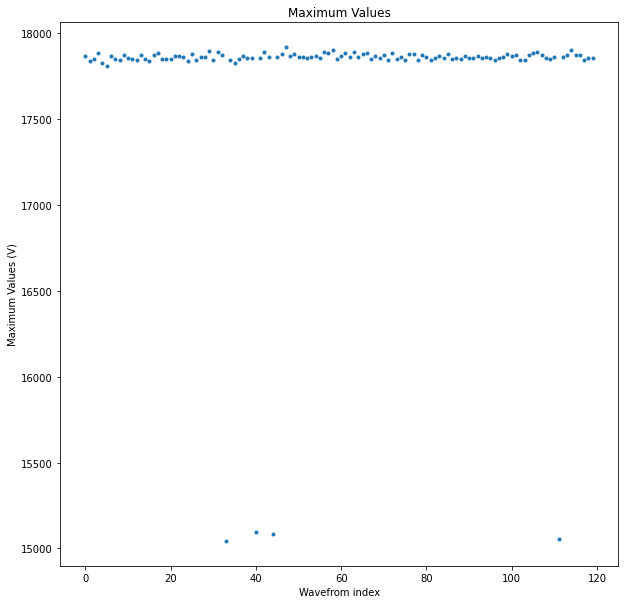

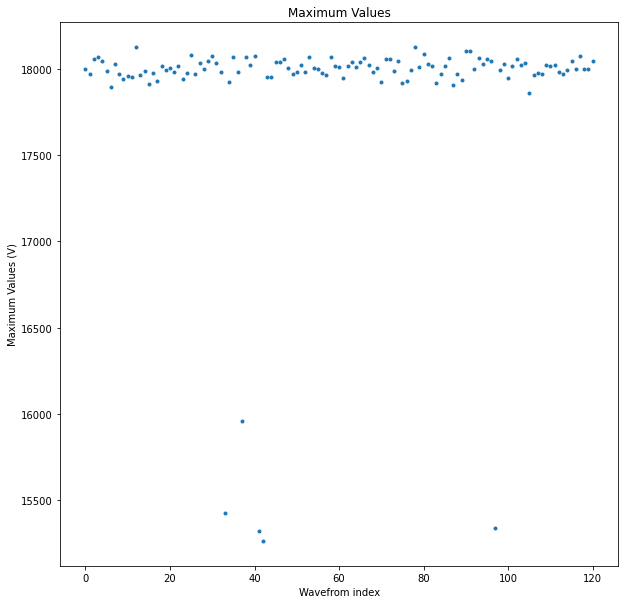

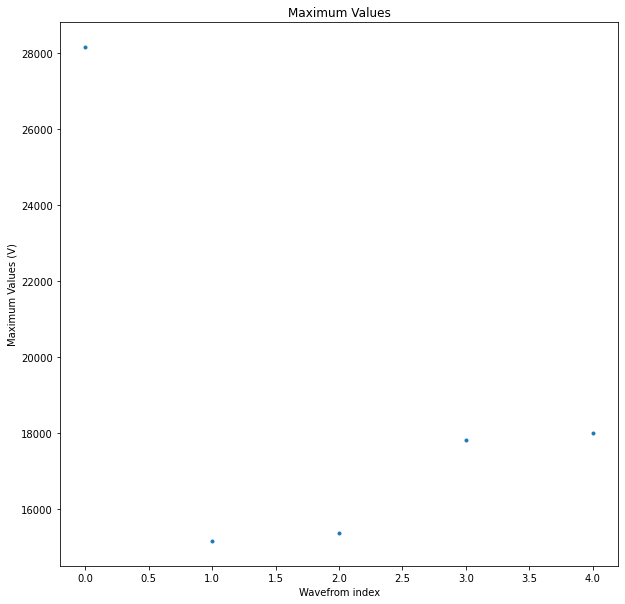

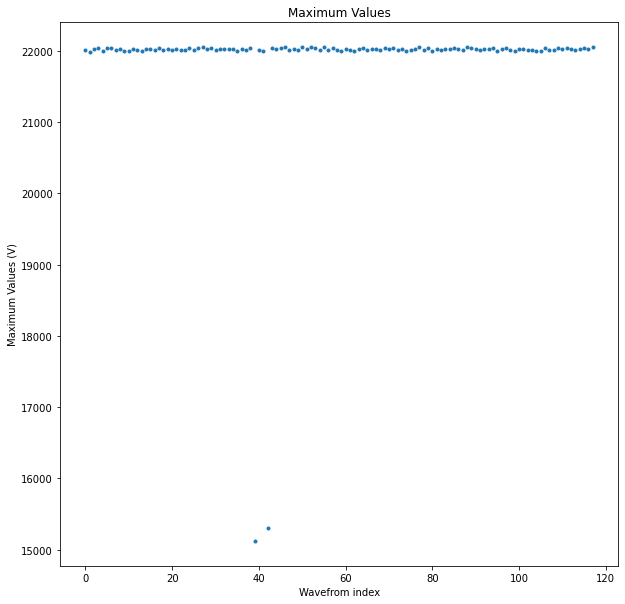

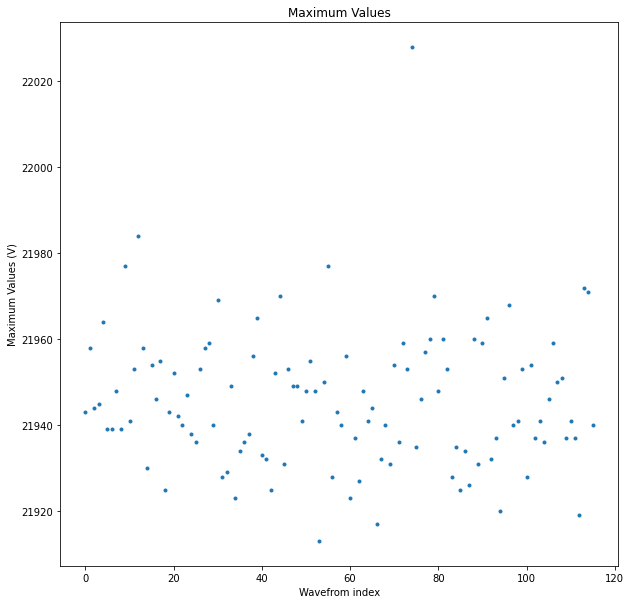

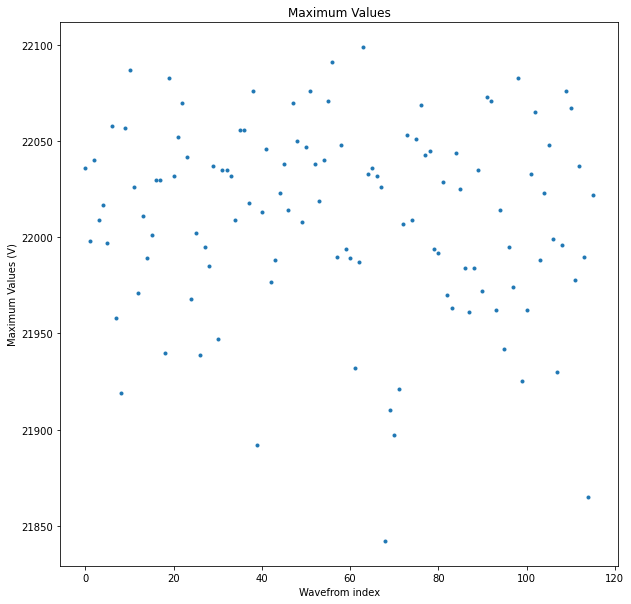

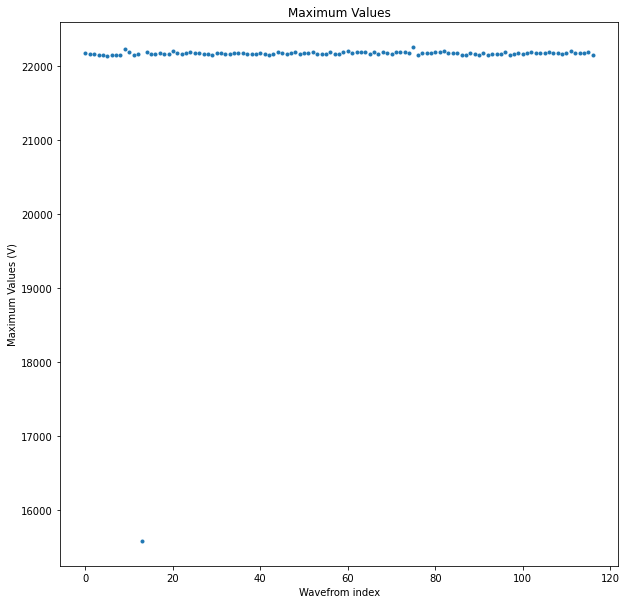

In [18]:
for detector, min_values in maximum_dict.items():
    plt.plot(min_values,'.')

    plt.xlabel('Wavefrom index') 
    plt.ylabel('Maximum Values (V)')  
    plt.title('Maximum Values')
    plt.show()

In [19]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Calculates the z-score of the maximum_values and removes values beyond 
    a certain number of standard deviations from the mean using the zscore_threshold.
    Inputs:
    zscore_threshold - number of standard deviations from the mean to remove a maximum point
    maximum_values - The array of maximum values 
    index - detector name 
    """
    # Calculate Z-scores for the maximum values
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index] # waveforms which survived the first vut 
    max_values = maximum_dict[index] #maximum values 

    # Empty lists to store filtered and skipped max values and their indices
    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    #loop through the z-score  and eliminate uncessary results
    for i, z_score in enumerate(max_z_scores):
        # Check if the maximum is beyond the mean by the threshold standard deviation 
        # we keep these values 
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            continue
        
        # If not beyond the threshold they are appended as values removed 
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

In [20]:
threshold =1 #choose one standard deviation as the threshold
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}

for j in detectors_bege:
    #if the number of values in the data set is less than 20
    #the data set doesnt need to undergo a cut and all the discharge 
    #events have been removed in cut one 
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]    

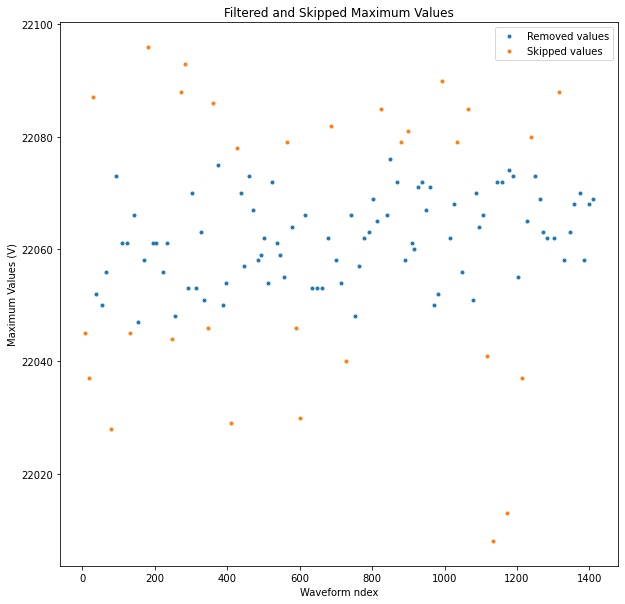

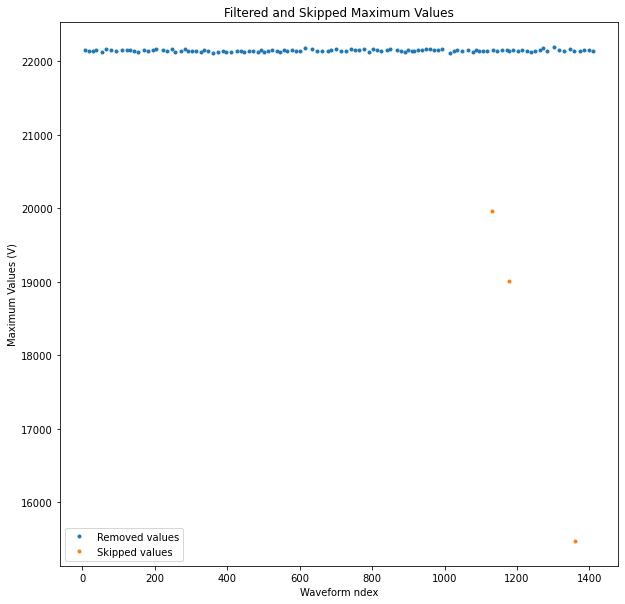

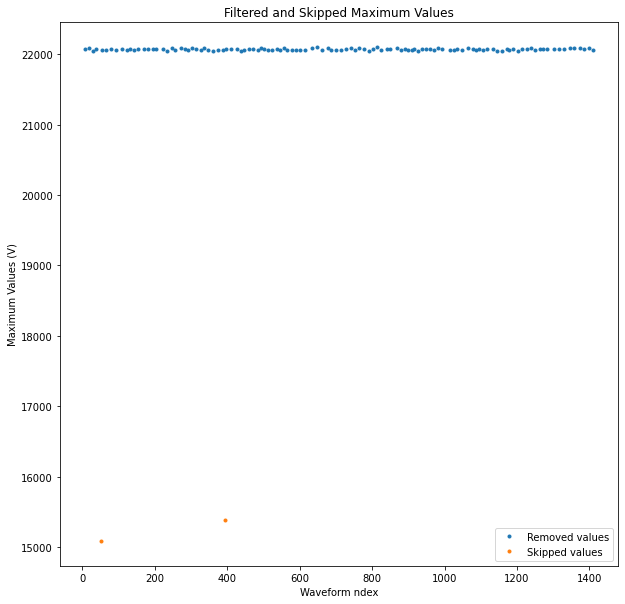

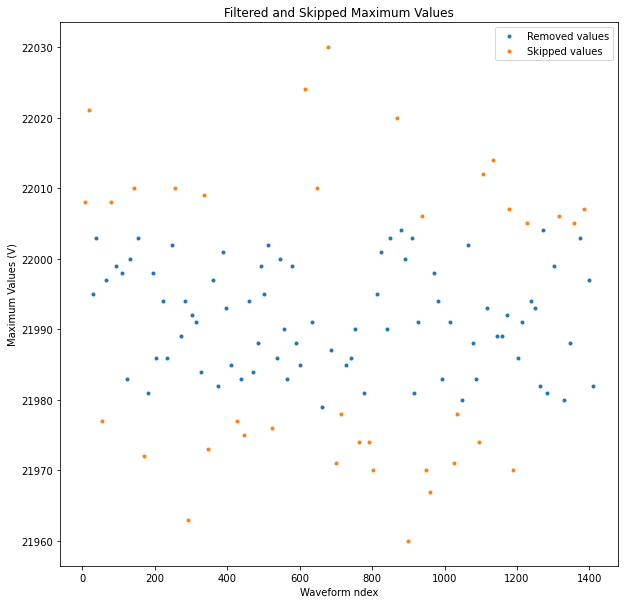

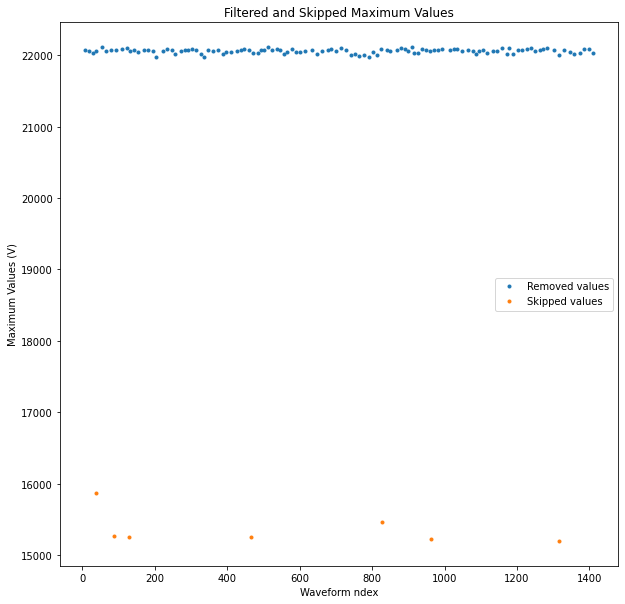

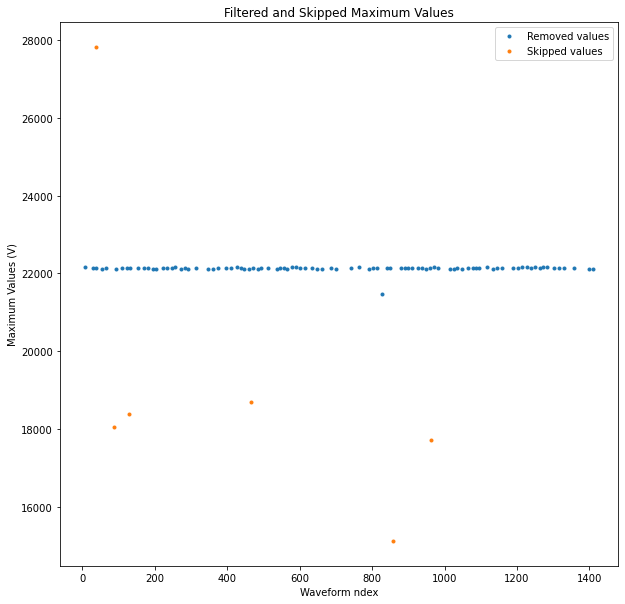

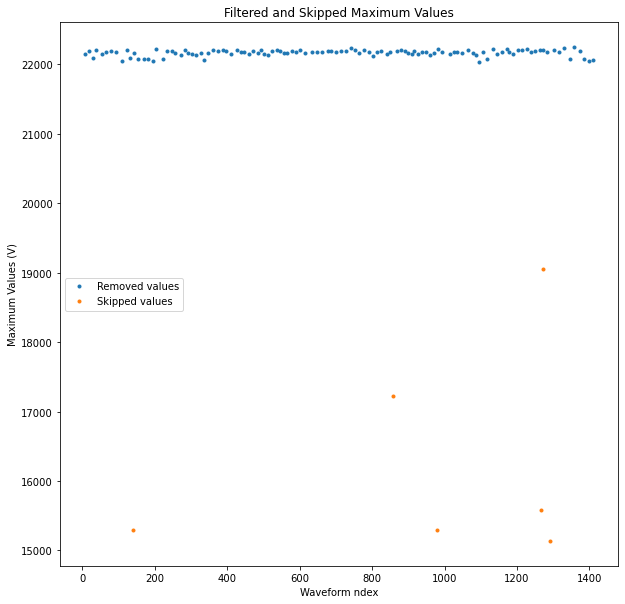

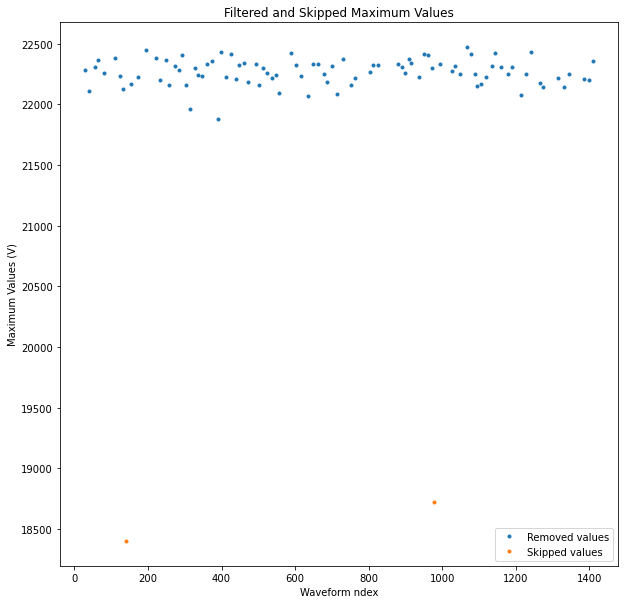

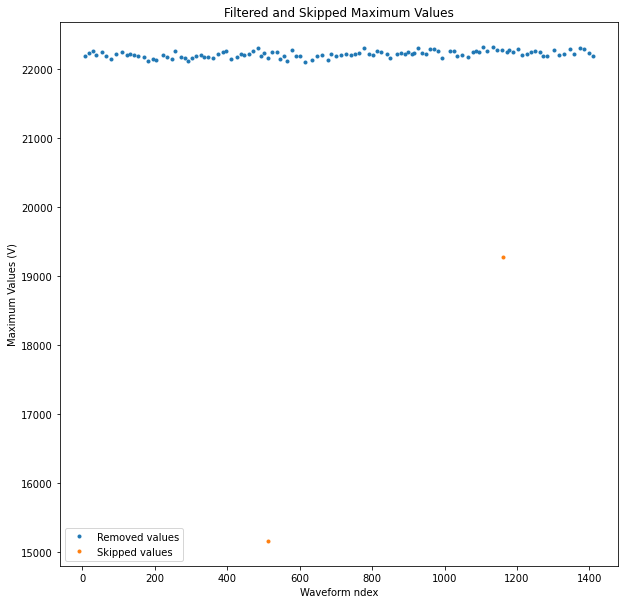

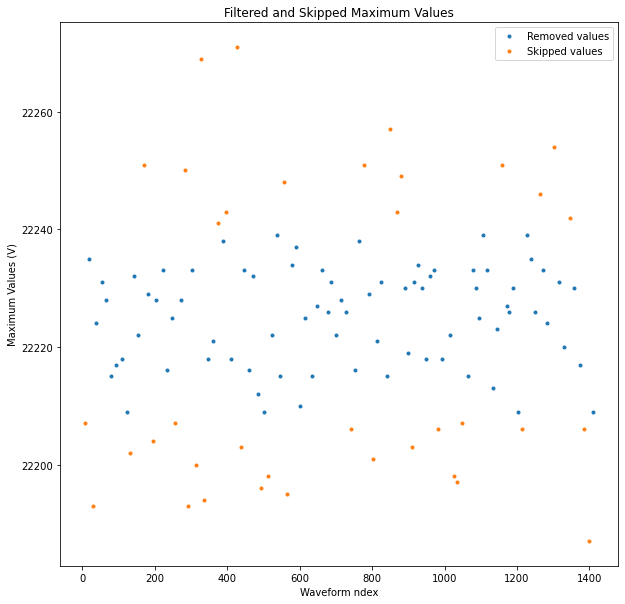

KeyError: 'ch1120003'

In [21]:
for detector in detectors_bege:
    plt.plot(index_filterm[detector],filtered_max_values[detector], '.',label=f'Removed values')
    plt.plot(index_skipm[detector],skipped_max_values[detector], '.',label=f'Skipped values')

    plt.xlabel('Waveform ndex') 
    plt.ylabel('Maximum Values (V)')
    plt.title('Filtered and Skipped Maximum Values')
    plt.legend()
    plt.show()


This detector ch1107202 doesn't have any discharges
Skipped waveforms for detector ch1110402: [1130, 1177, 1361]


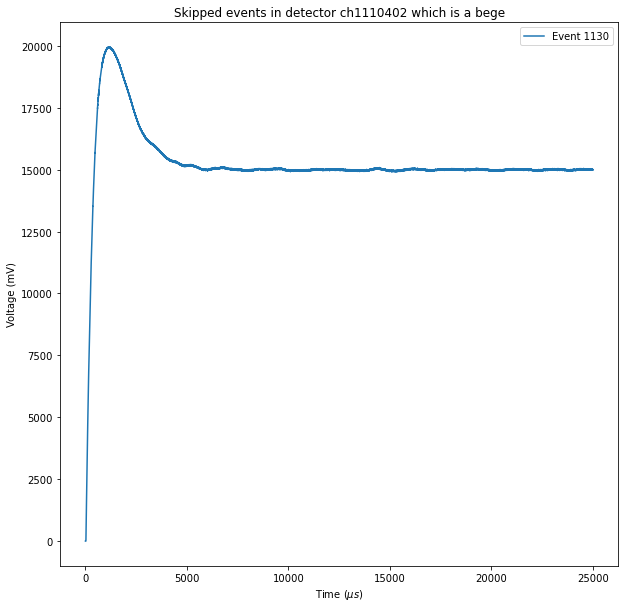

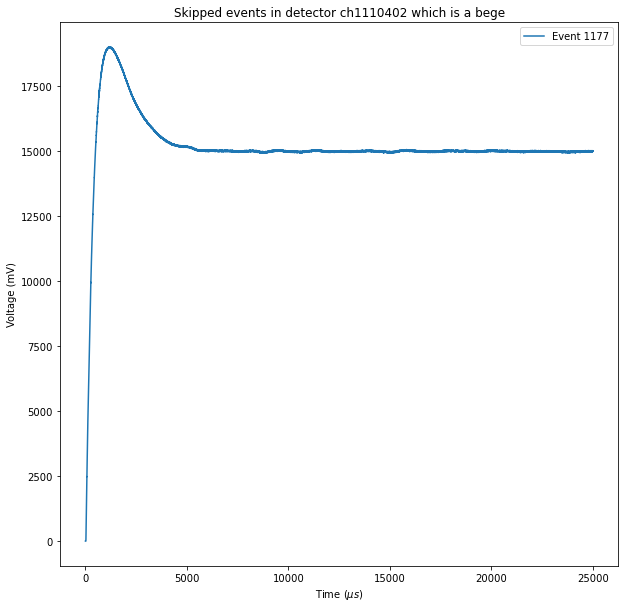

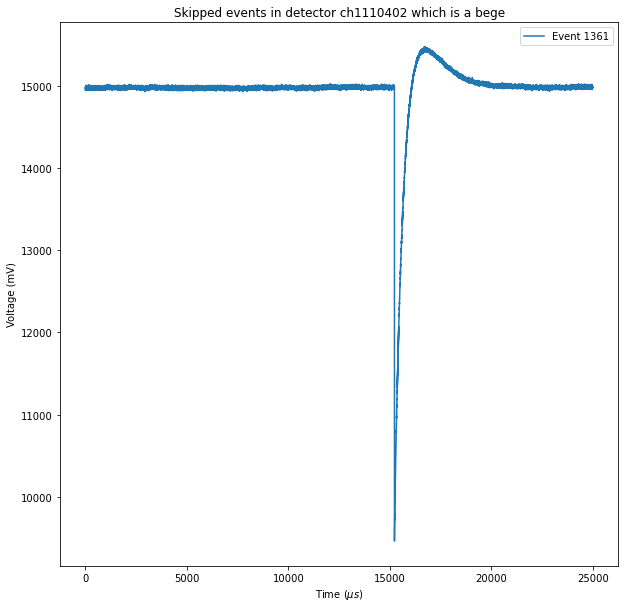

Percentage of discharges present: 0.21246458923512845%
Skipped waveforms for detector ch1110403: [51, 393]


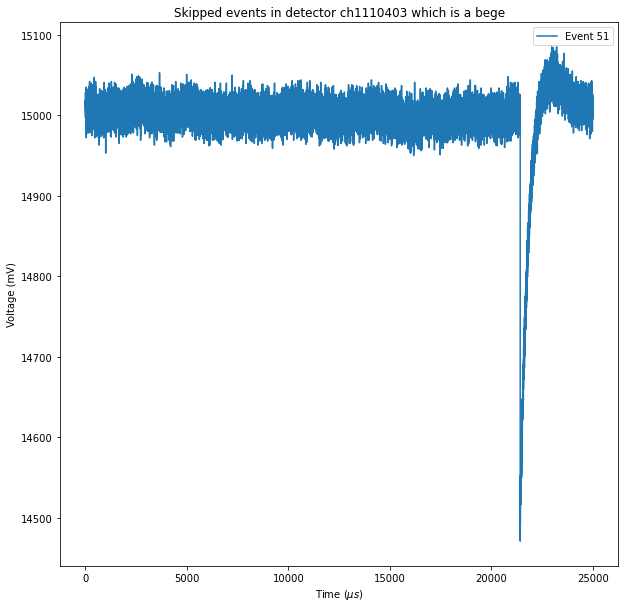

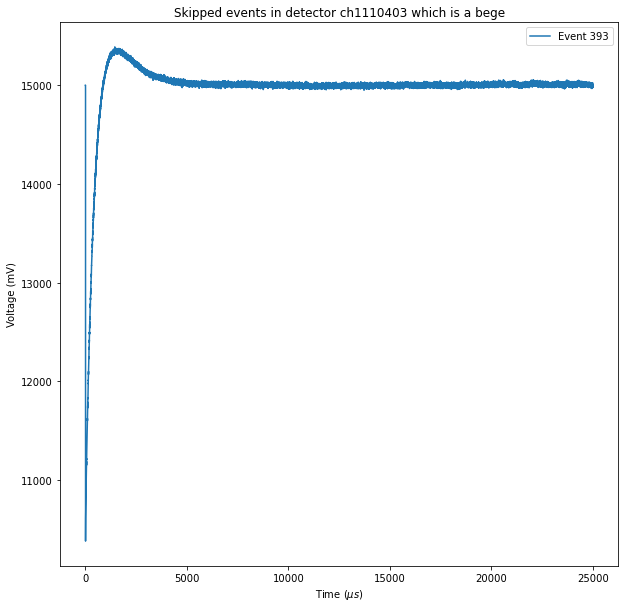

Percentage of discharges present: 0.14164305949008194%
This detector ch1112005 doesn't have any discharges
Skipped waveforms for detector ch1113600: [37, 88, 130, 467, 827, 962, 1317]


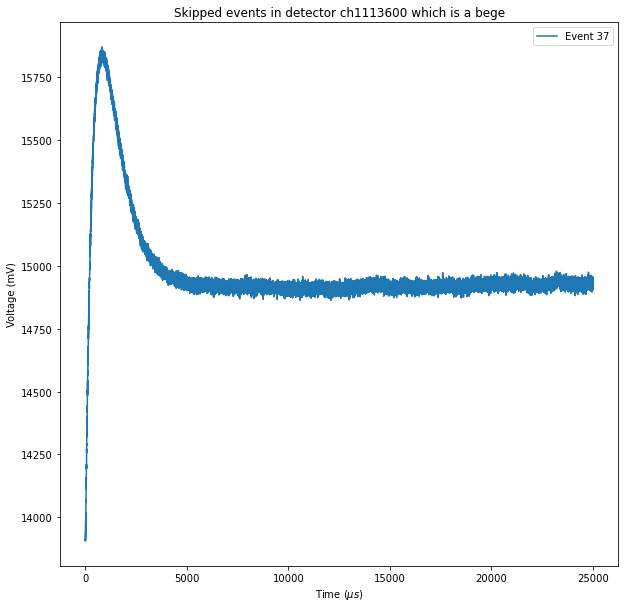

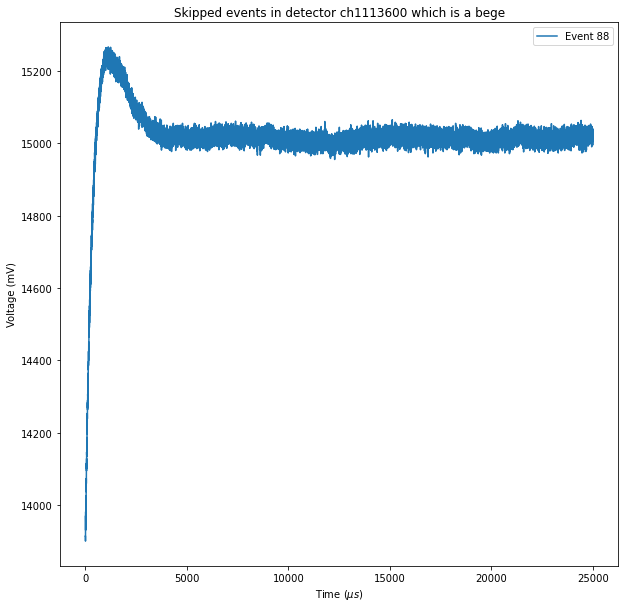

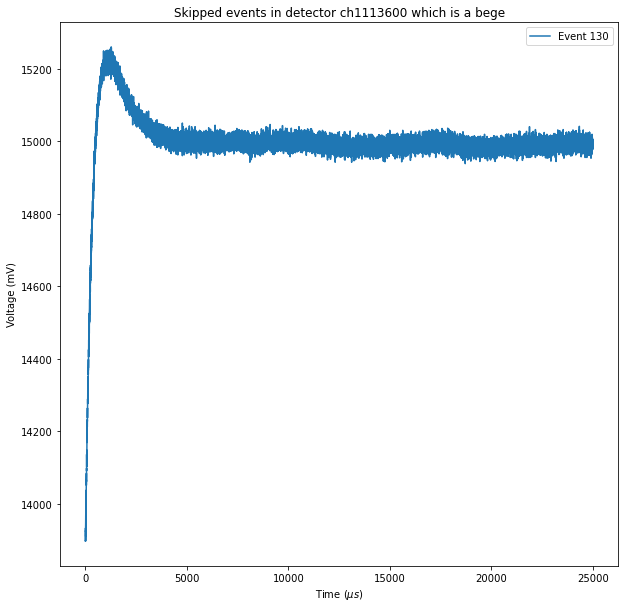

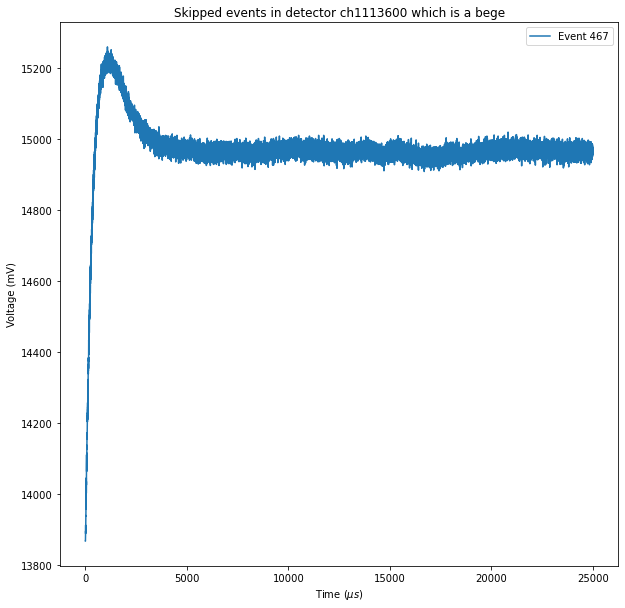

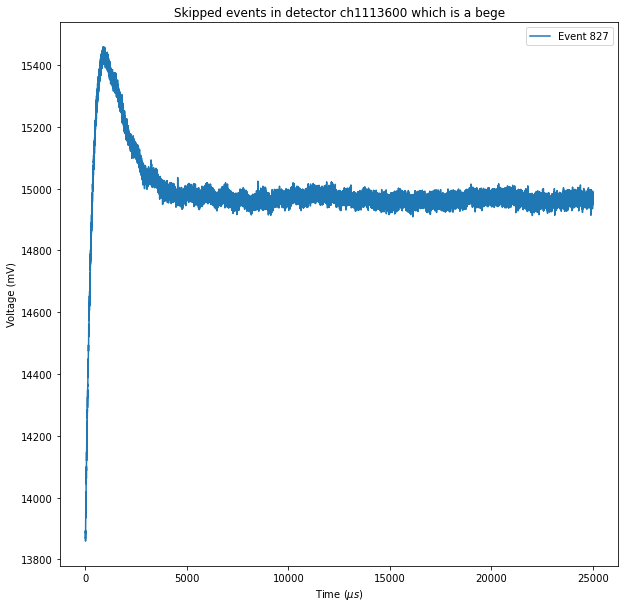

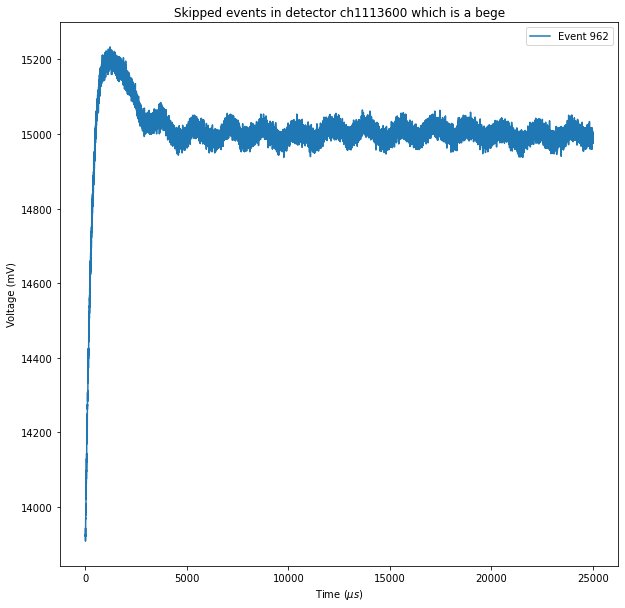

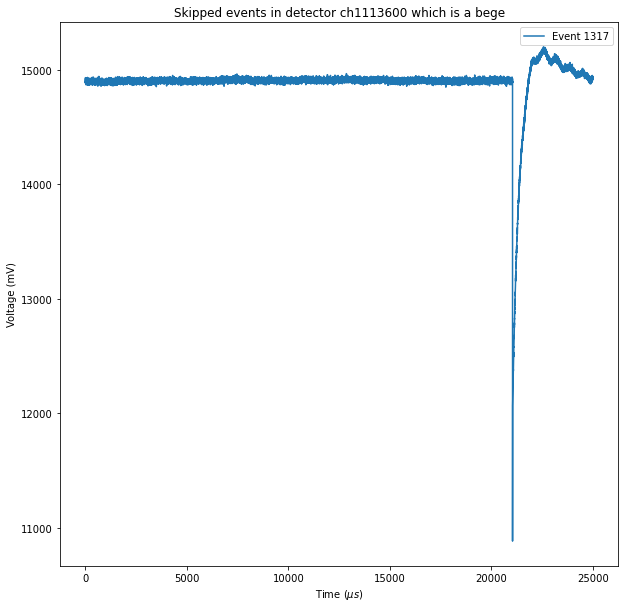

Percentage of discharges present: 0.4957507082152923%
Skipped waveforms for detector ch1113601: [37, 88, 130, 467, 858, 962]


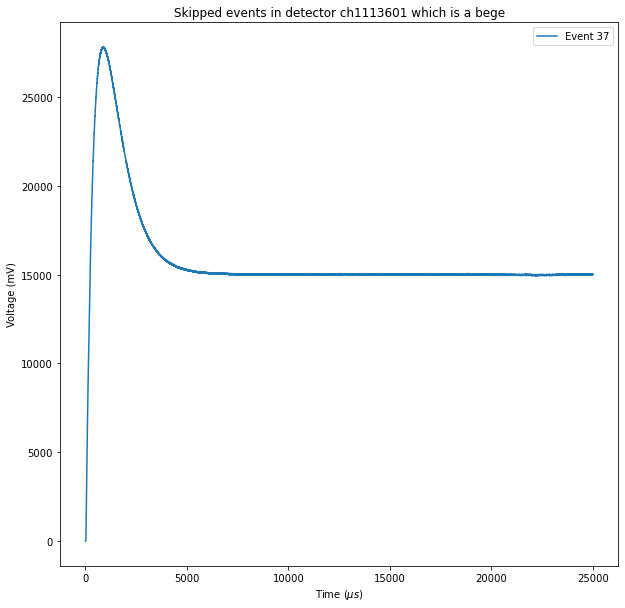

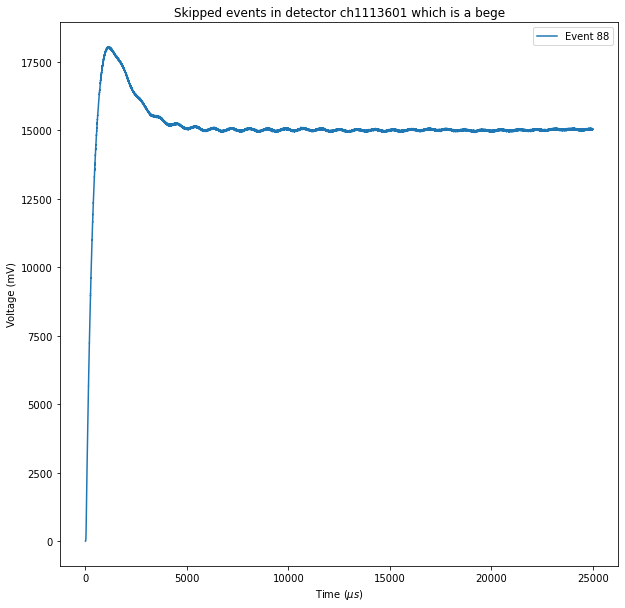

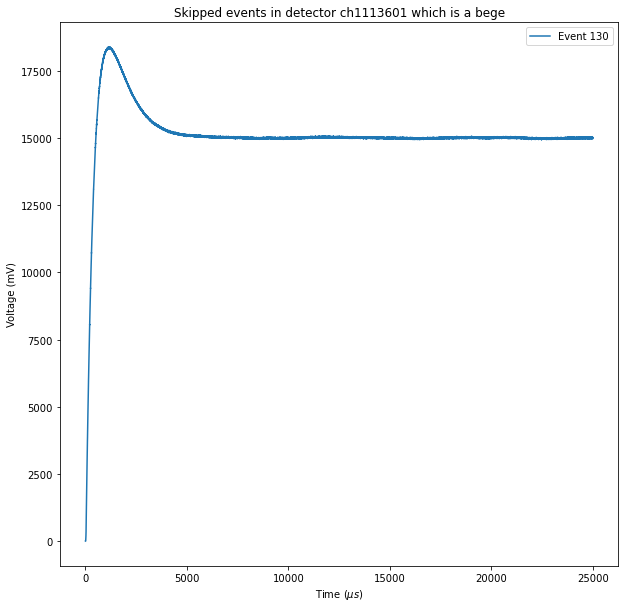

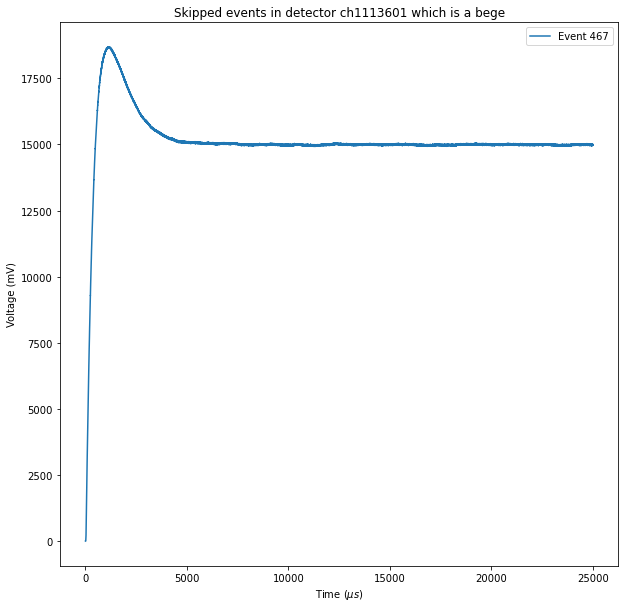

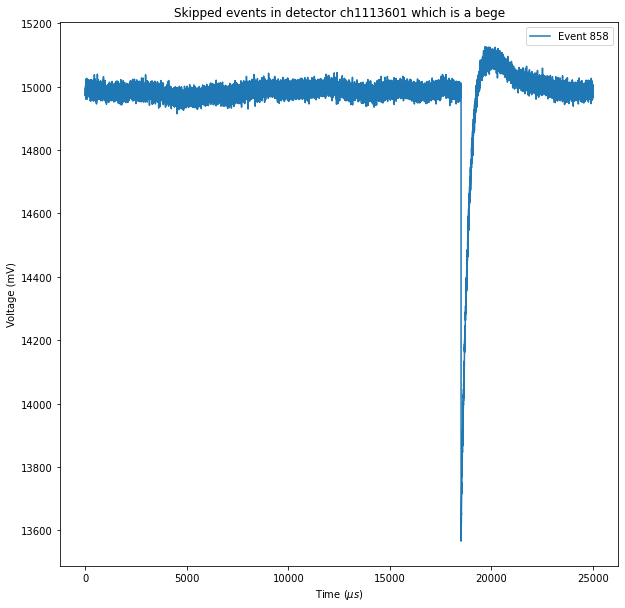

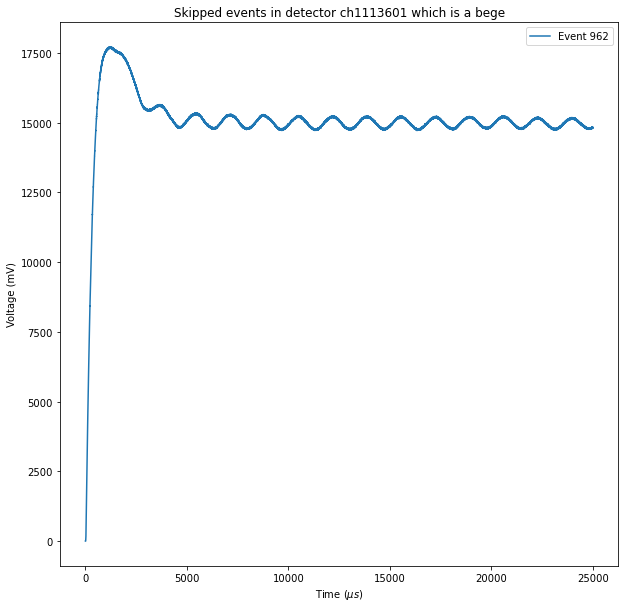

Percentage of discharges present: 0.4249291784702569%
Skipped waveforms for detector ch1113602: [139, 858, 978, 1265, 1272, 1292]


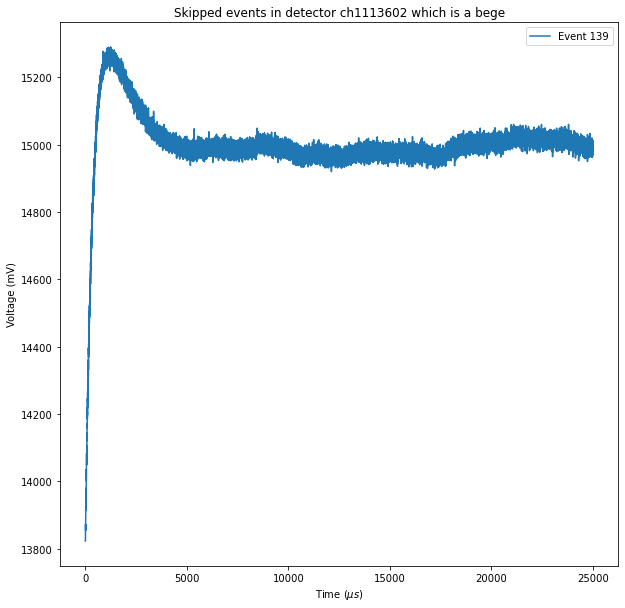

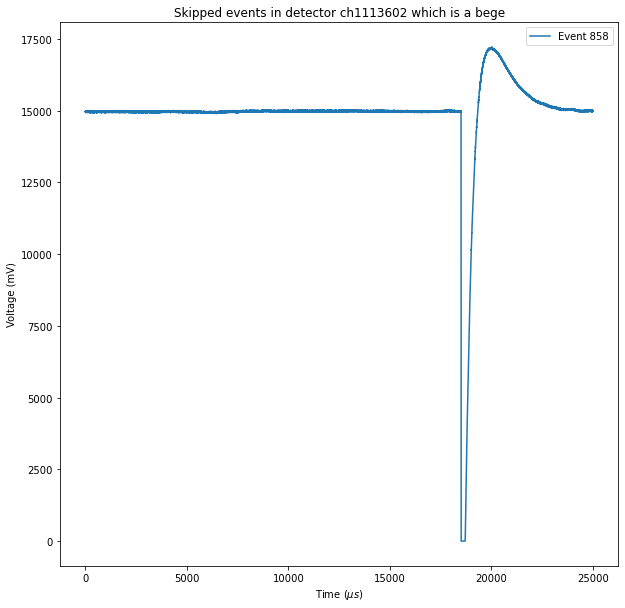

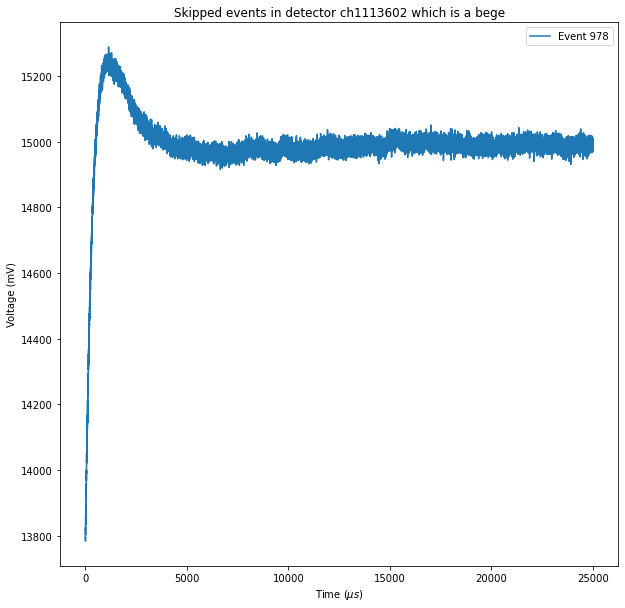

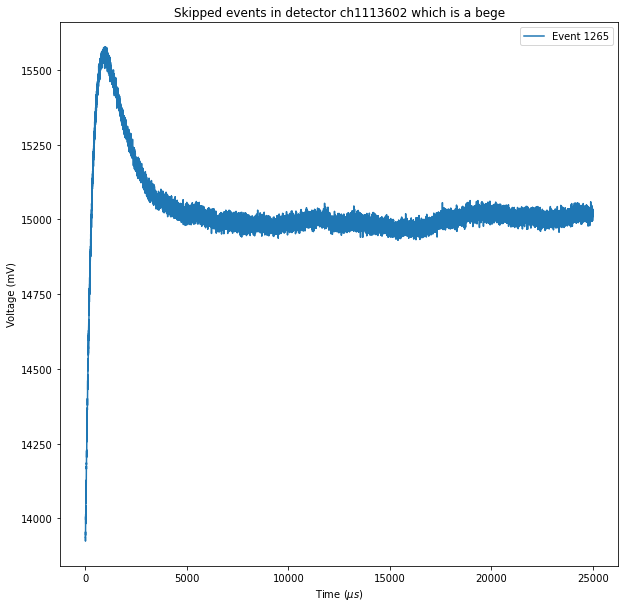

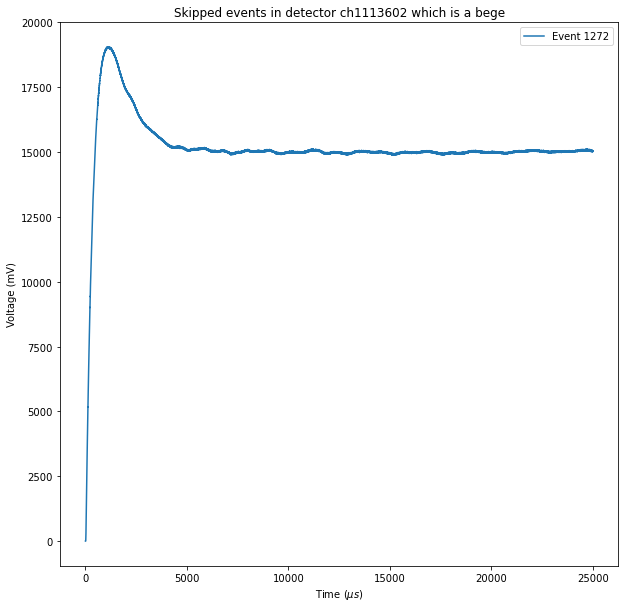

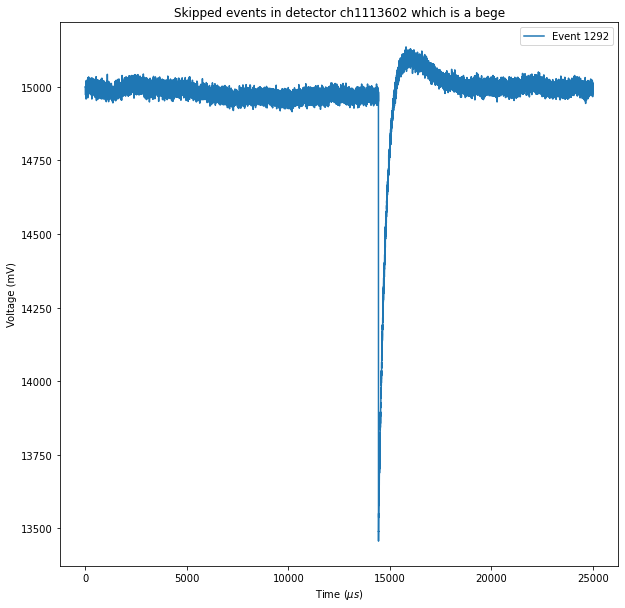

Percentage of discharges present: 0.4249291784702569%
Skipped waveforms for detector ch1113603: [139, 978]


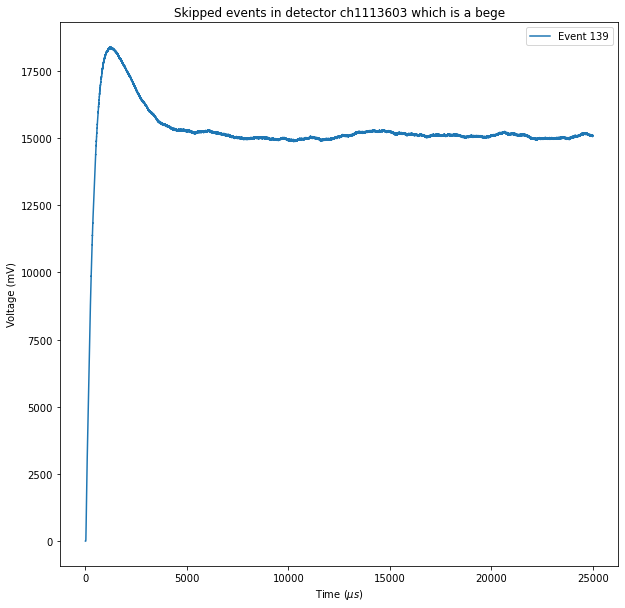

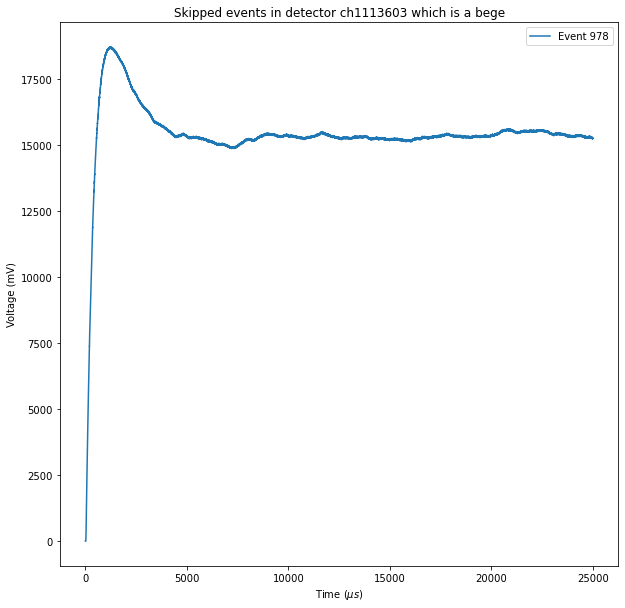

Percentage of discharges present: 0.14164305949008194%
Skipped waveforms for detector ch1113604: [514, 1161]


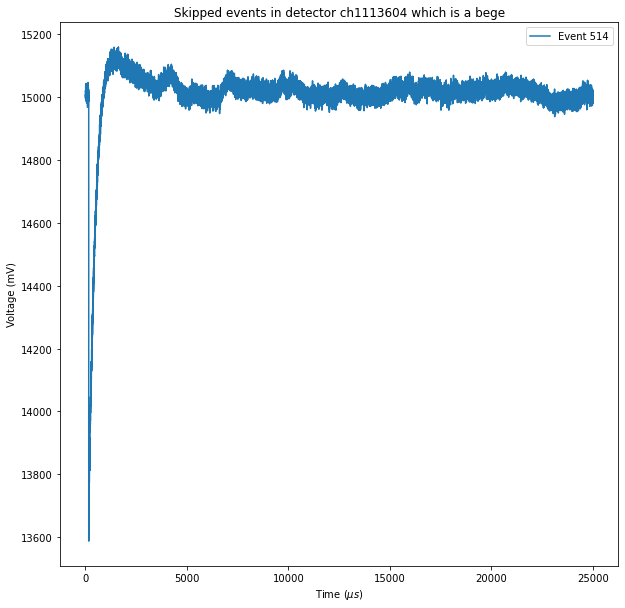

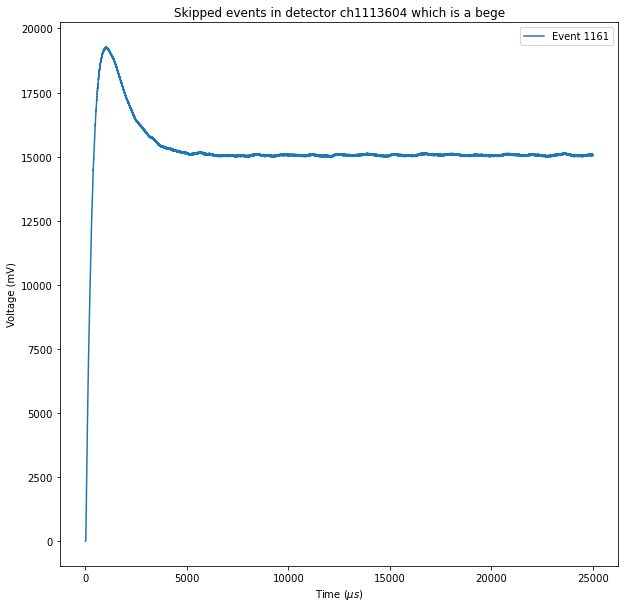

Percentage of discharges present: 0.14164305949008194%
This detector ch1113605 doesn't have any discharges
Skipped waveforms for detector ch1120003: [62, 210, 456, 478, 532, 546, 672, 982, 1200, 1405]


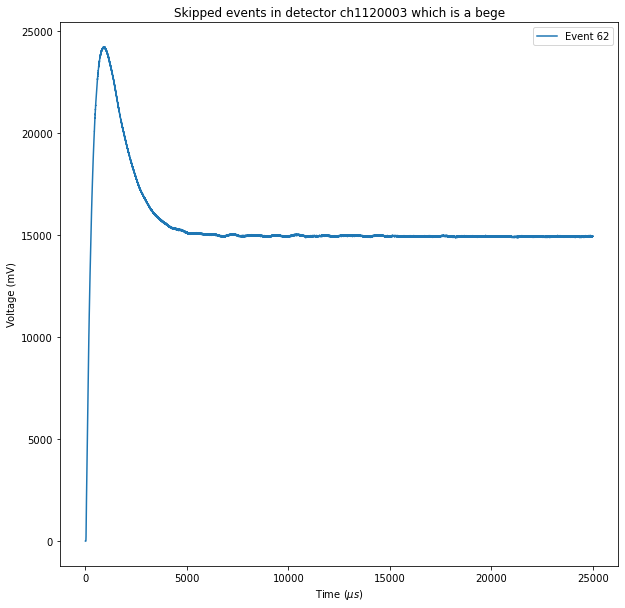

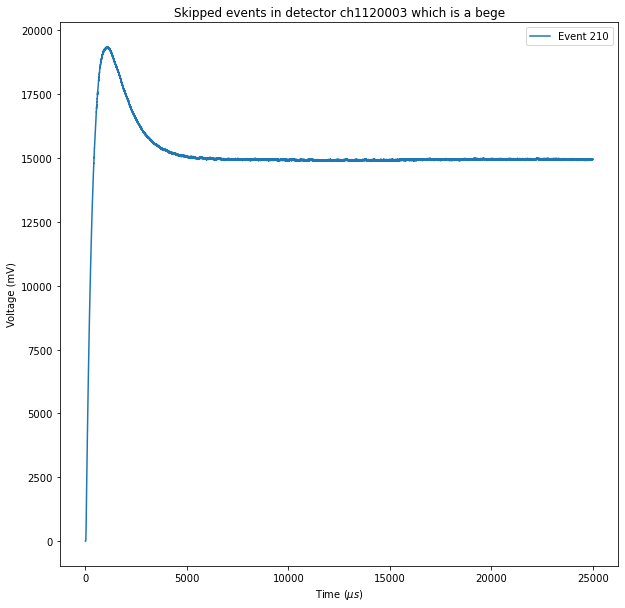

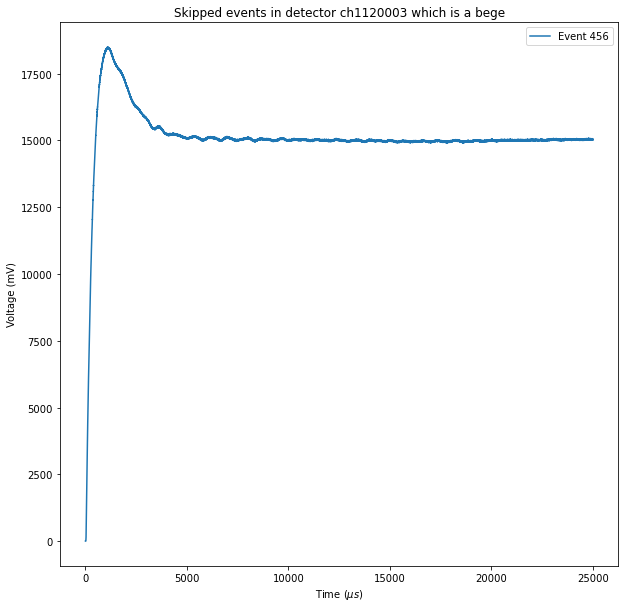

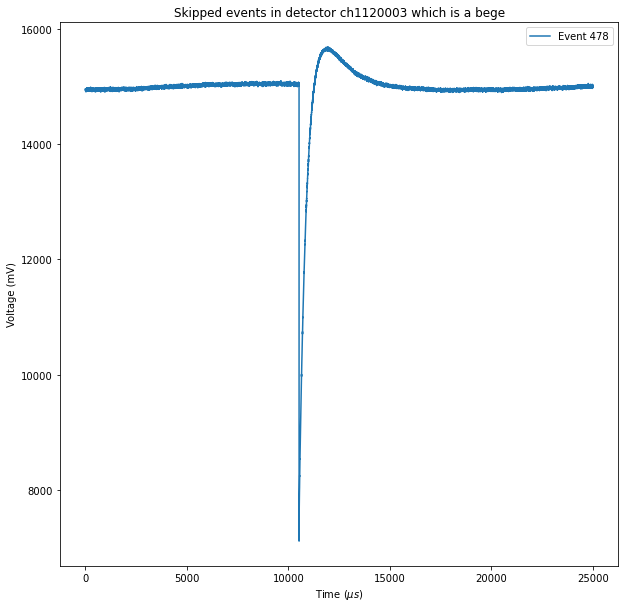

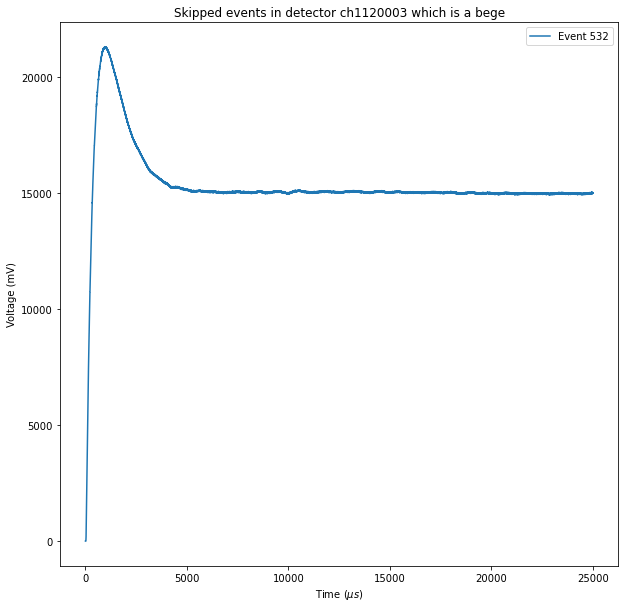

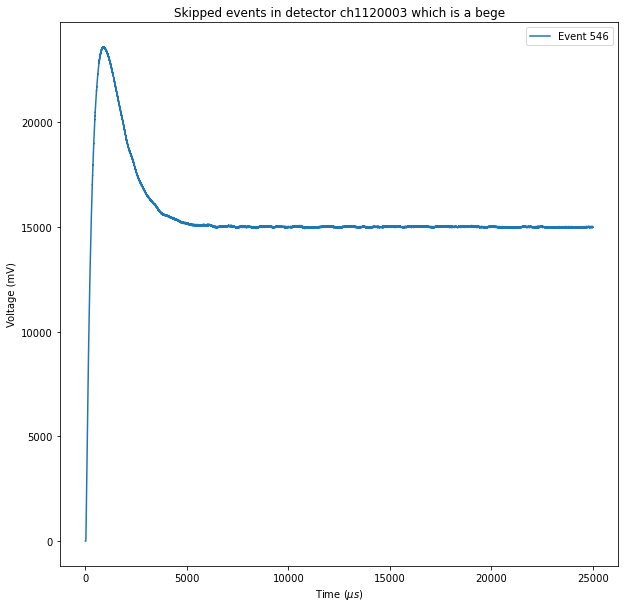

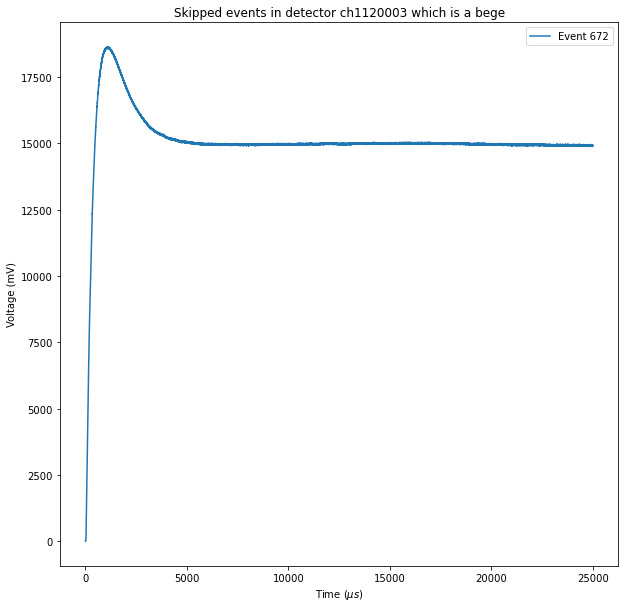

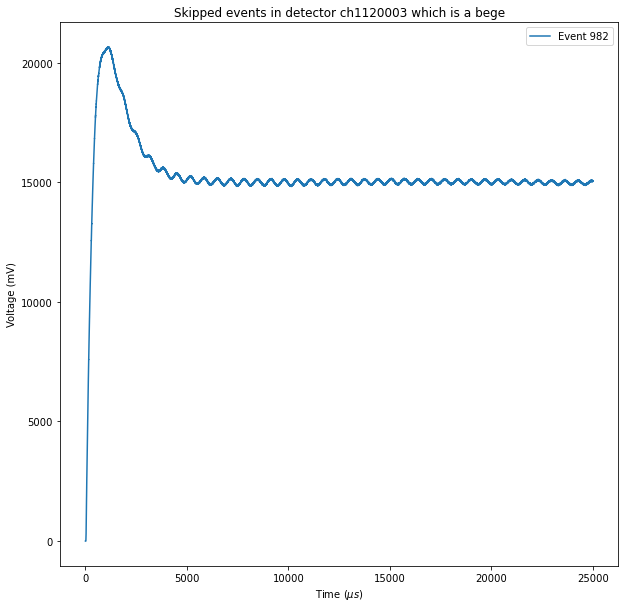

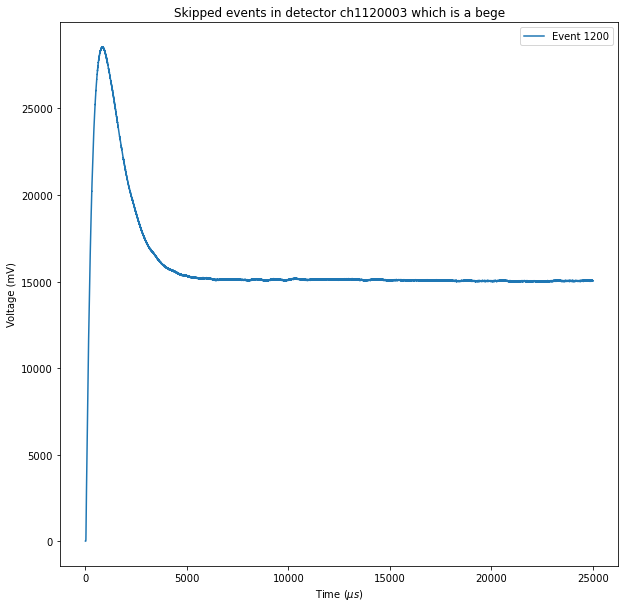

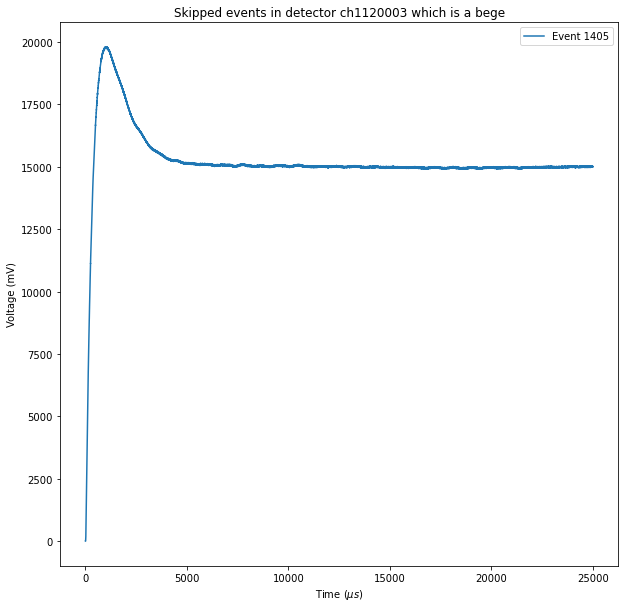

Percentage of discharges present: 0.7082152974504208%
Skipped waveforms for detector ch1120004: [389, 397, 761, 1227]


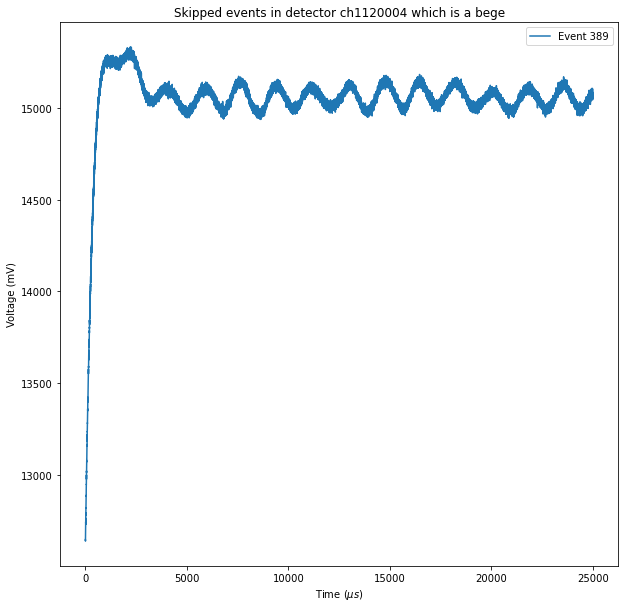

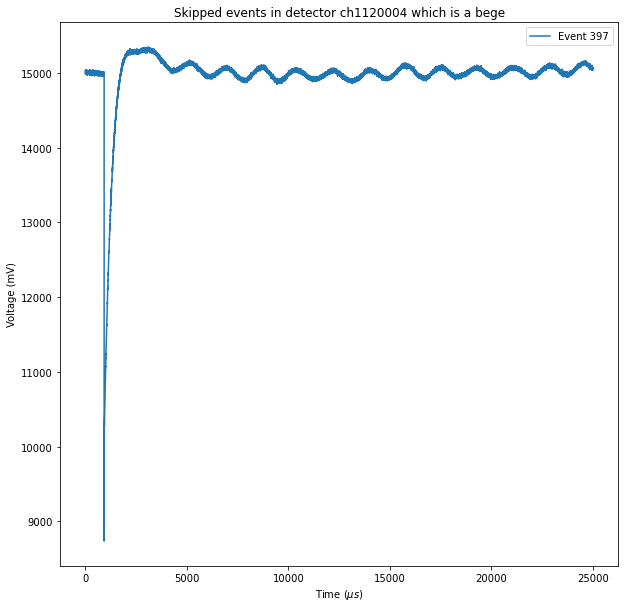

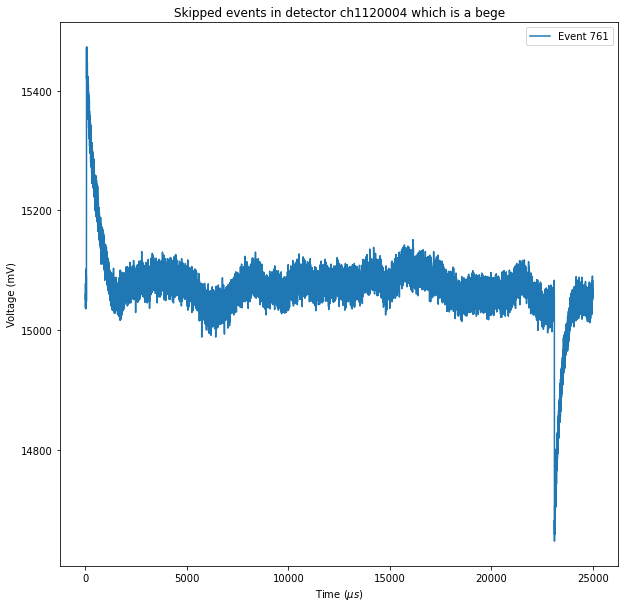

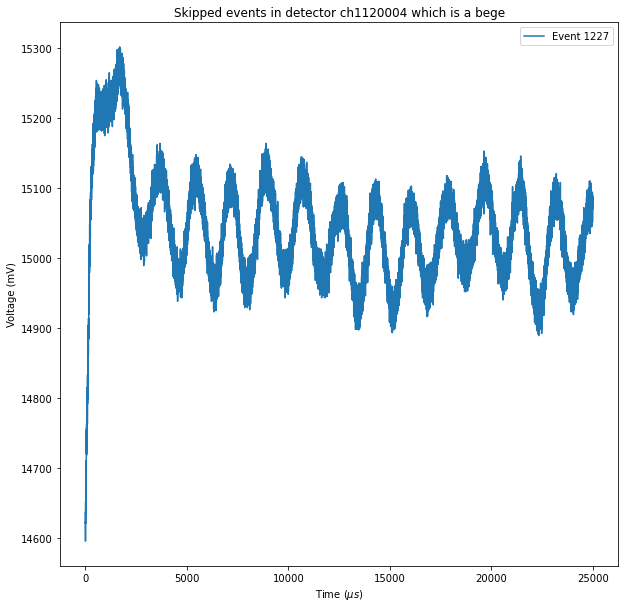

Percentage of discharges present: 0.283286118980175%
This detector ch1078405 doesn't have any discharges
Skipped waveforms for detector ch1080000: [494, 501, 1097, 1303]


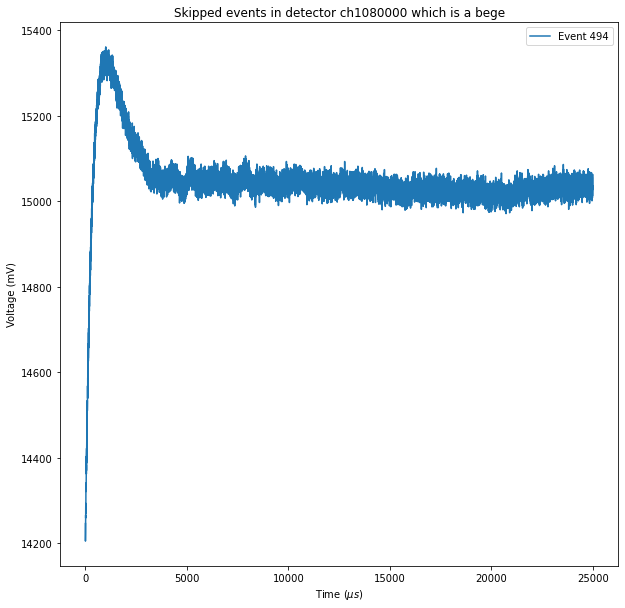

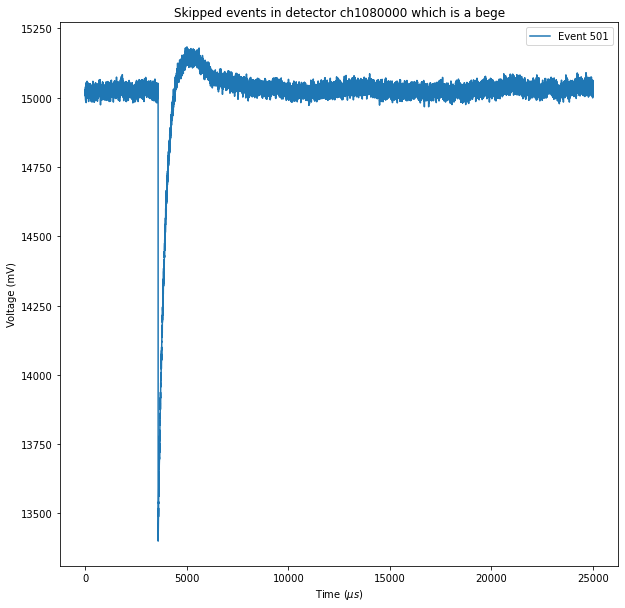

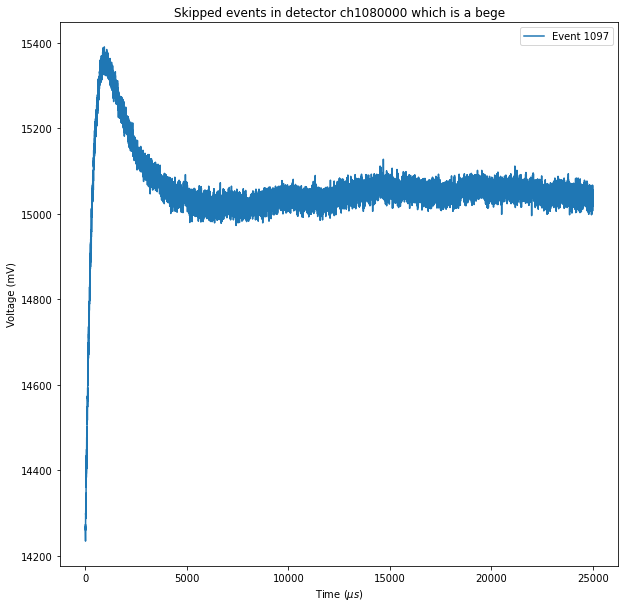

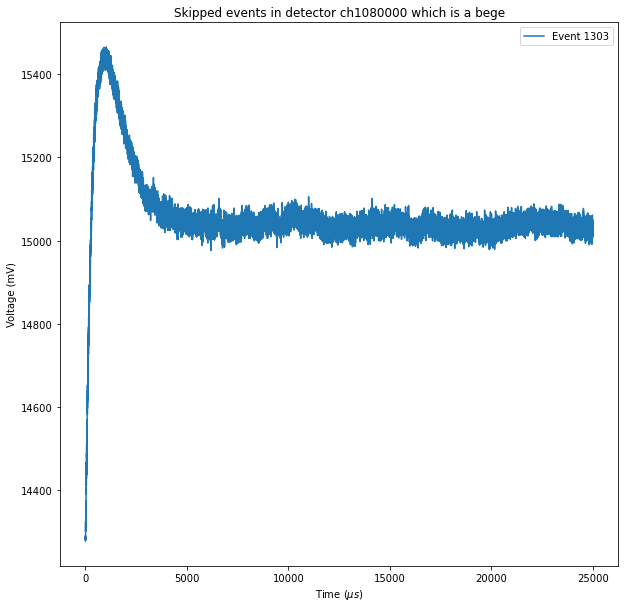

Percentage of discharges present: 0.283286118980175%
Skipped waveforms for detector ch1080001: [494, 1097, 1303]


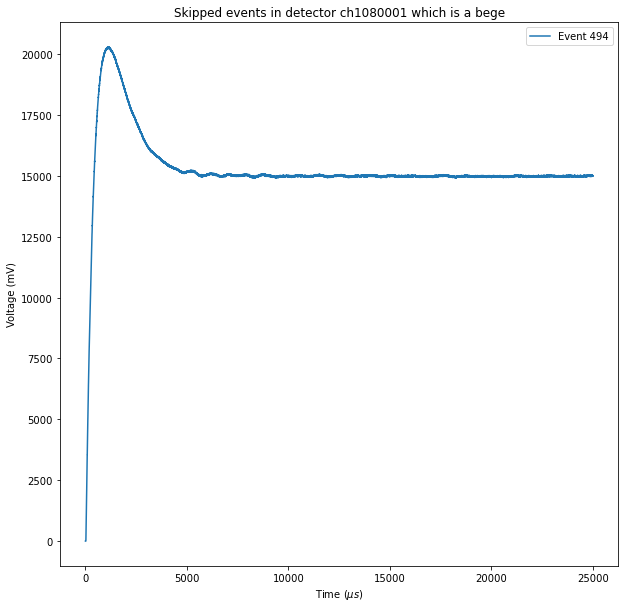

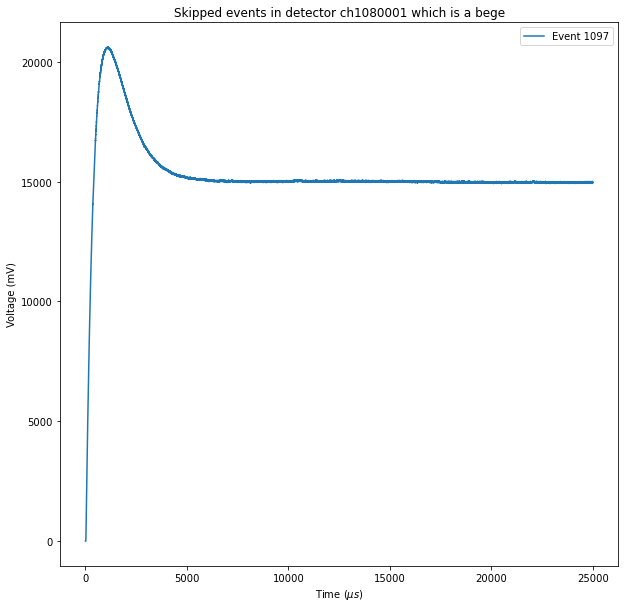

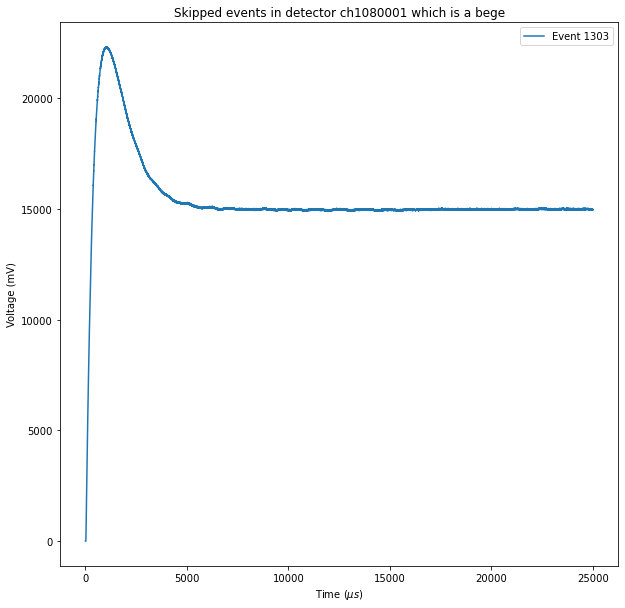

Percentage of discharges present: 0.21246458923512845%
This detector ch1080002 doesn't have any discharges
This detector ch1083200 doesn't have any discharges
Skipped waveforms for detector ch1083201: [85, 430, 448, 506, 850, 906, 1094]


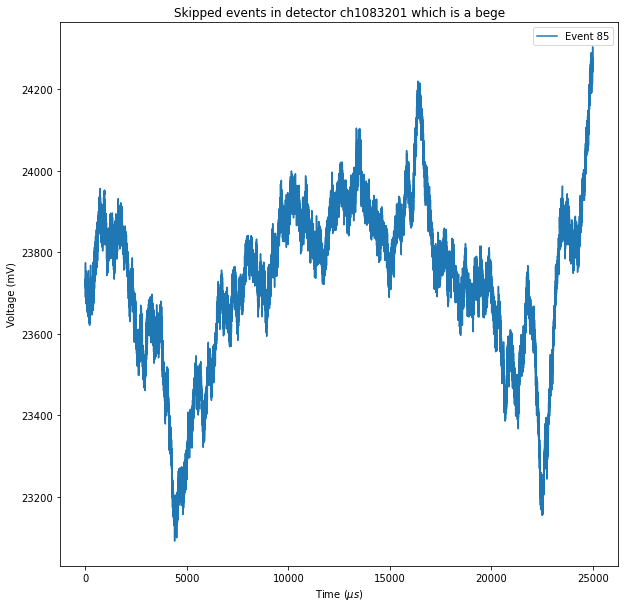

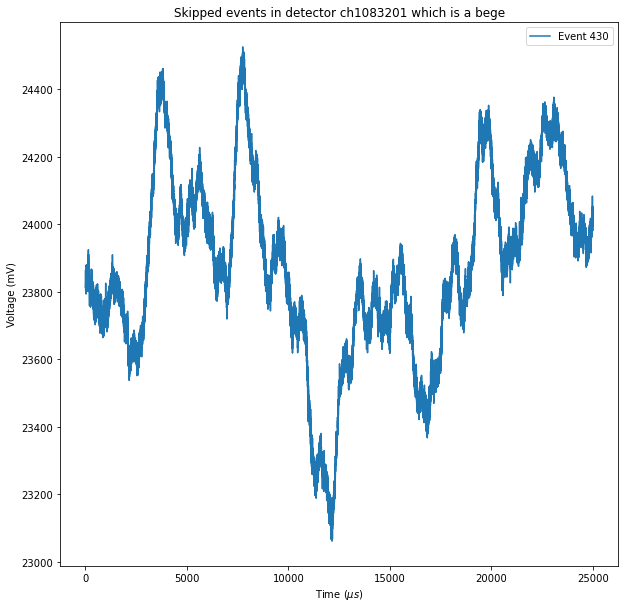

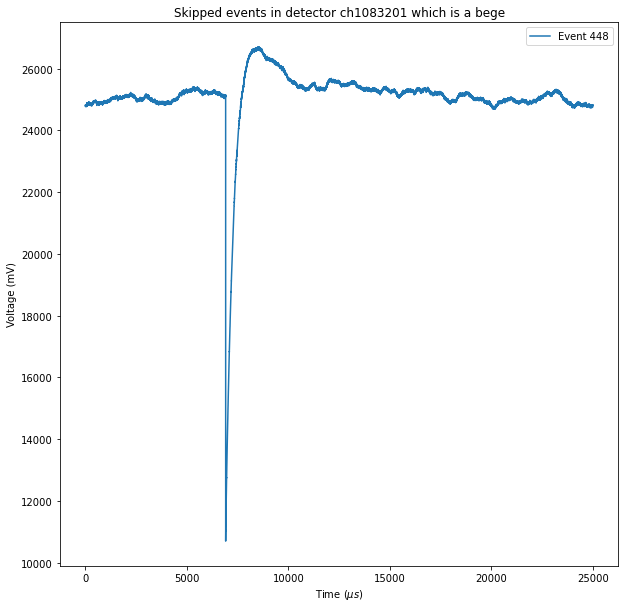

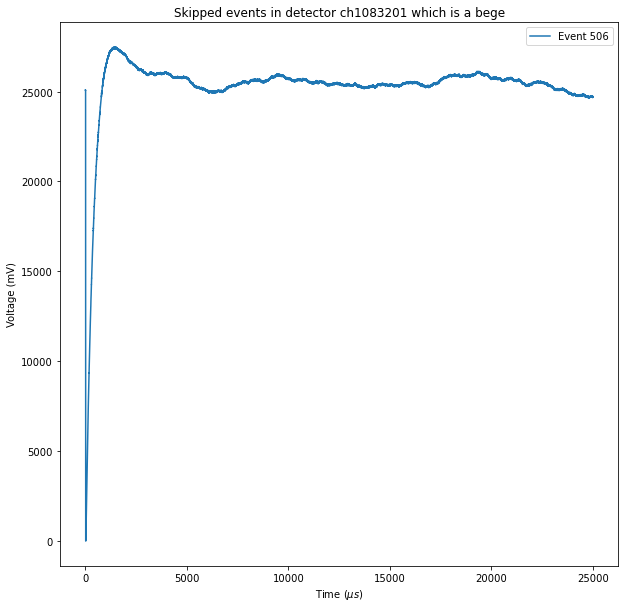

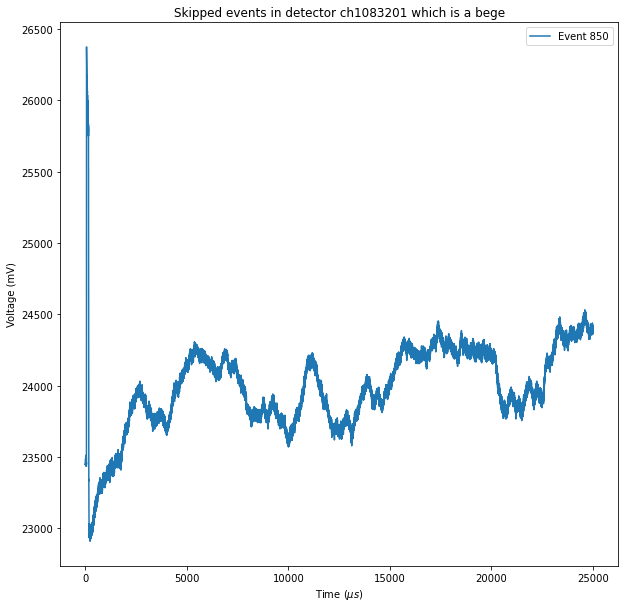

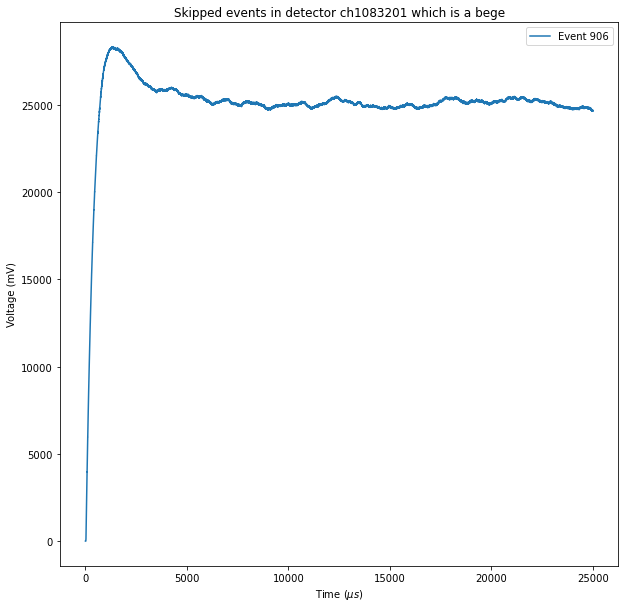

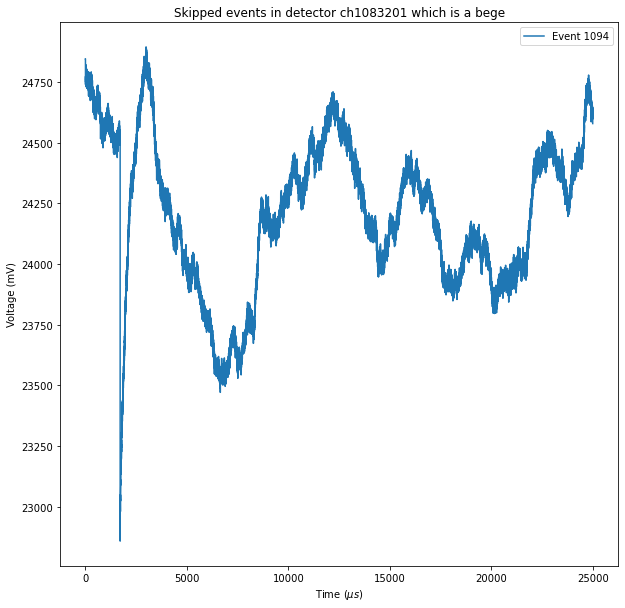

Percentage of discharges present: 0.4957507082152923%
Skipped waveforms for detector ch1083202: [474, 506, 1160, 1402]


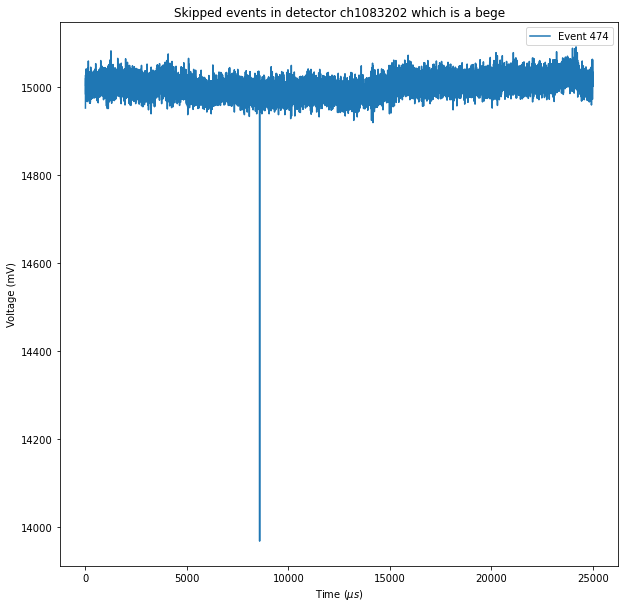

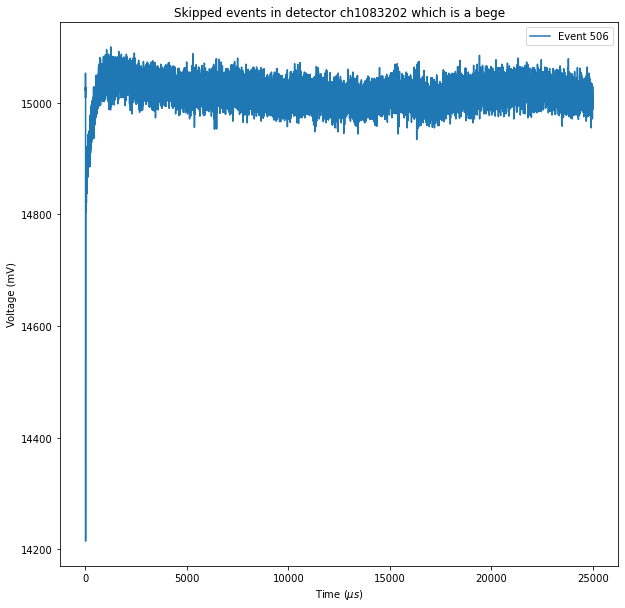

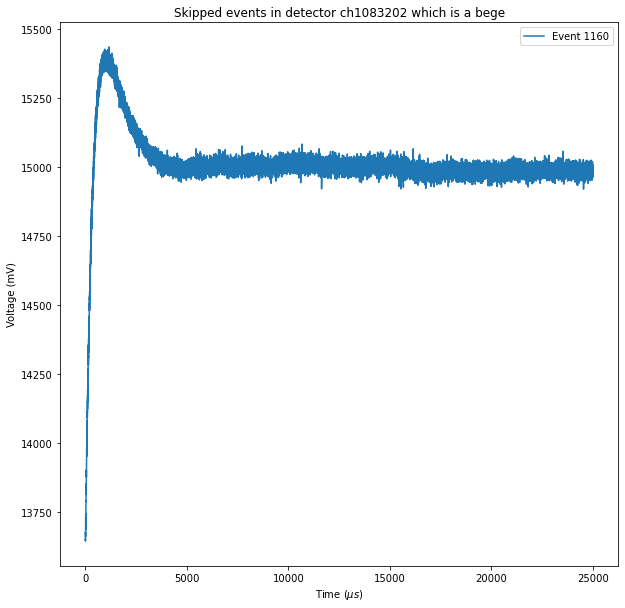

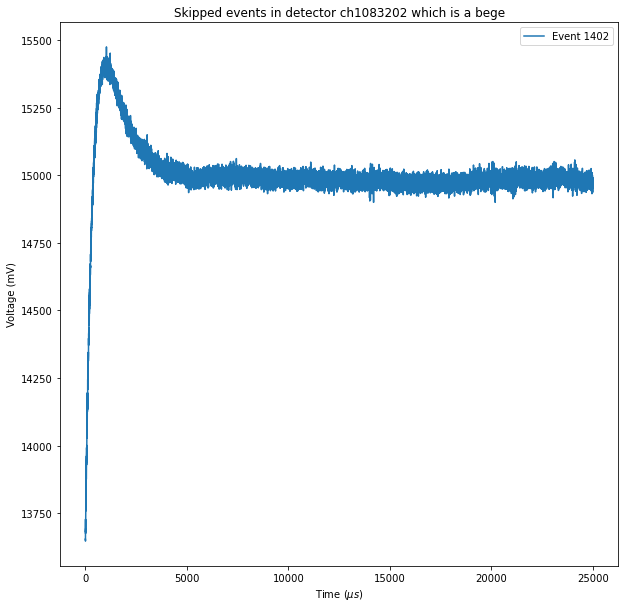

Percentage of discharges present: 0.283286118980175%
Skipped waveforms for detector ch1083203: [32, 437, 573, 1160, 1224, 1402]


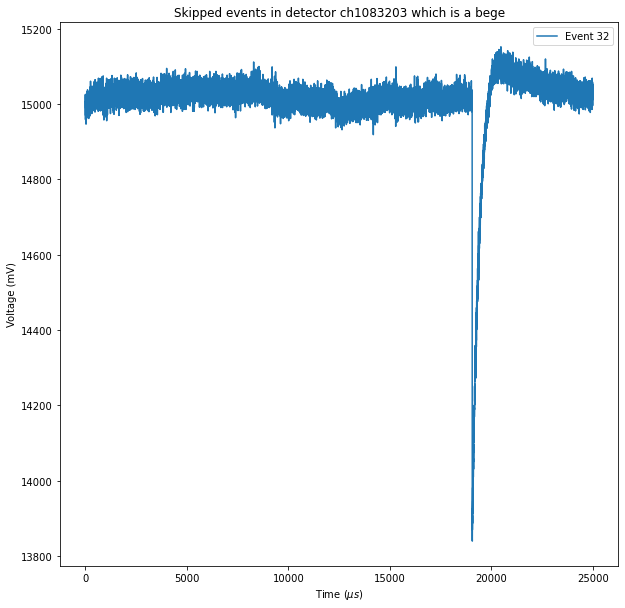

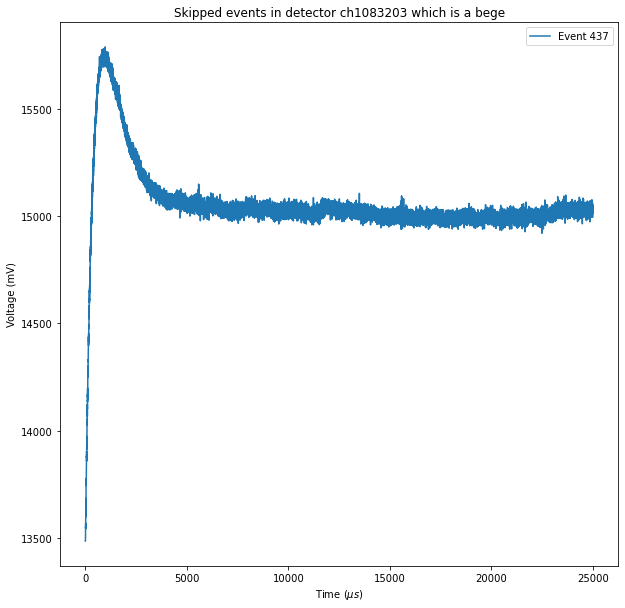

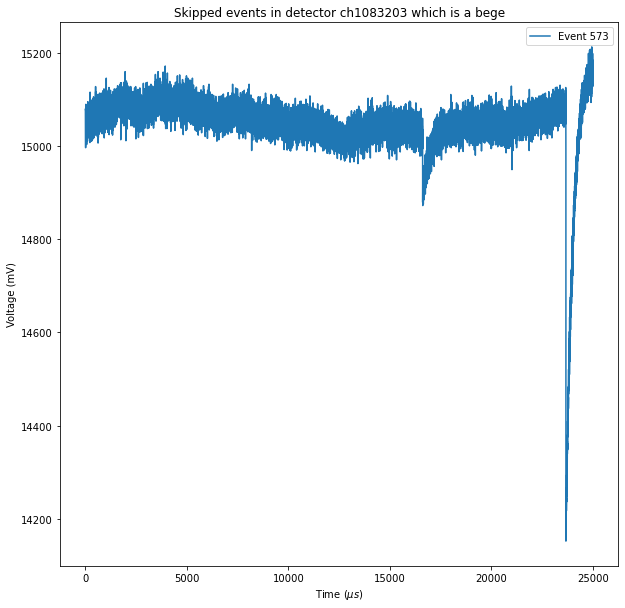

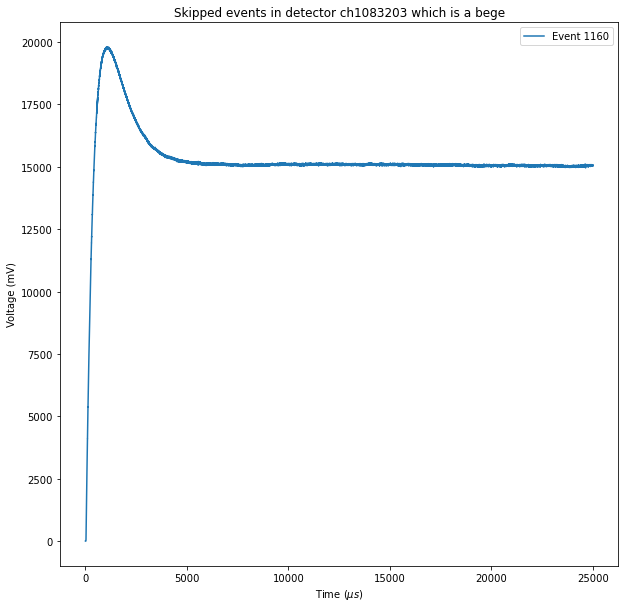

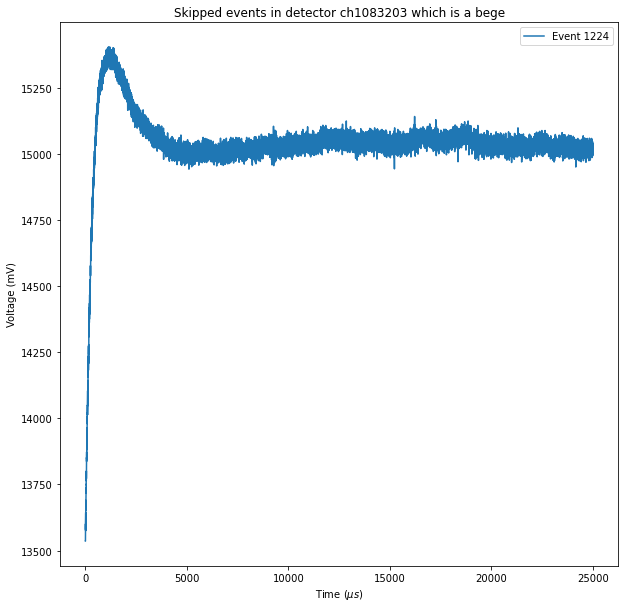

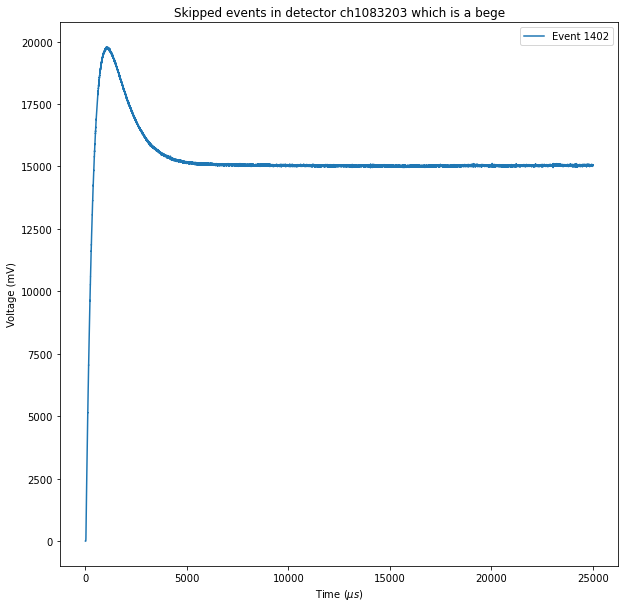

Percentage of discharges present: 0.4249291784702569%
Skipped waveforms for detector ch1083204: [437, 474, 1224]


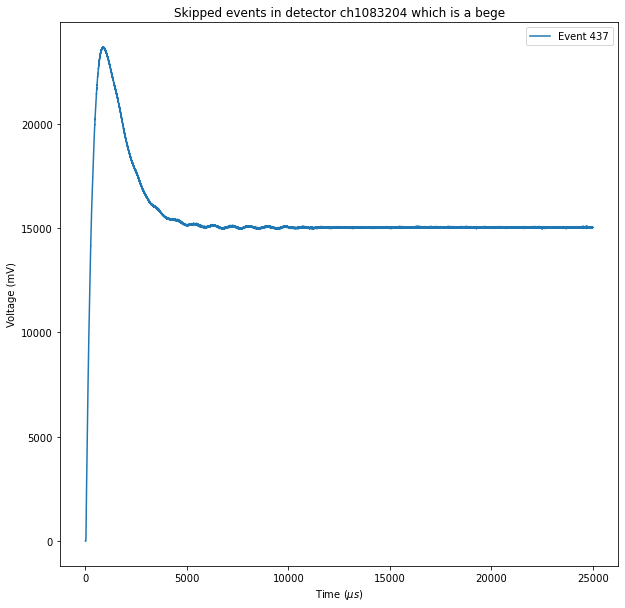

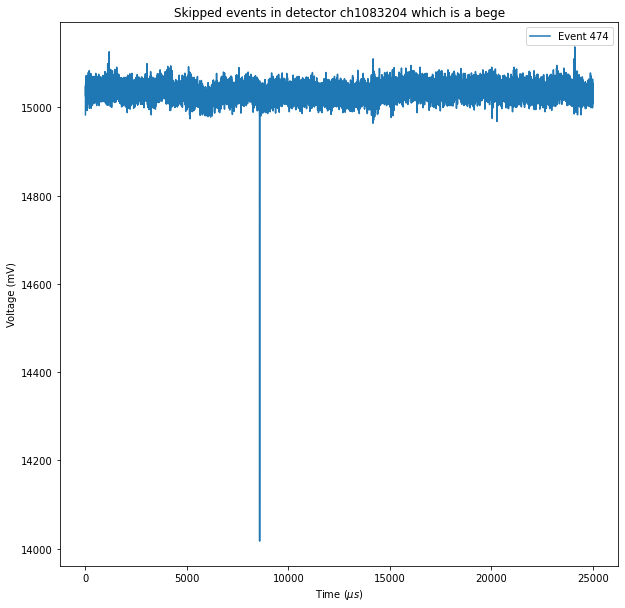

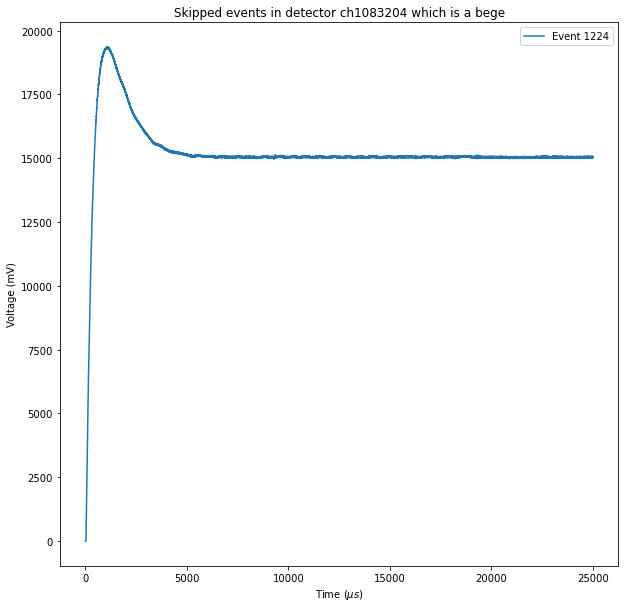

Percentage of discharges present: 0.21246458923512845%
Skipped waveforms for detector ch1083205: [408, 474, 506, 1313]


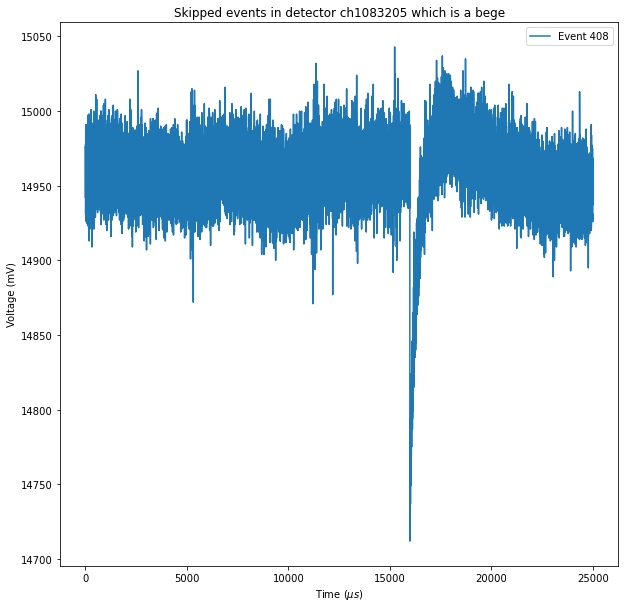

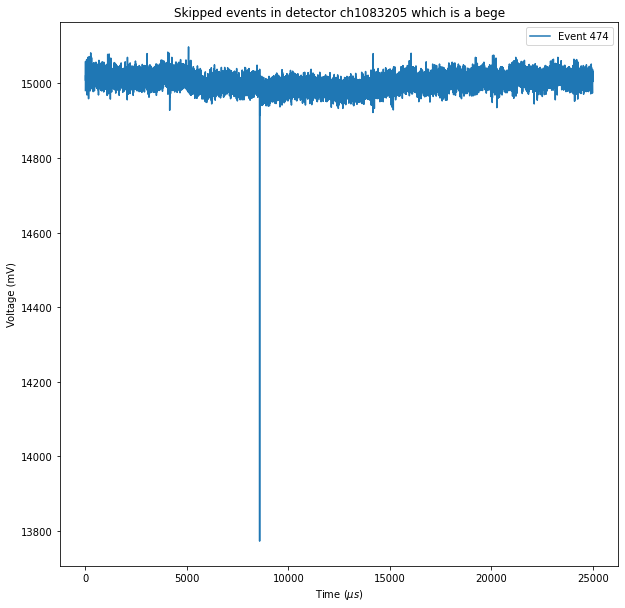

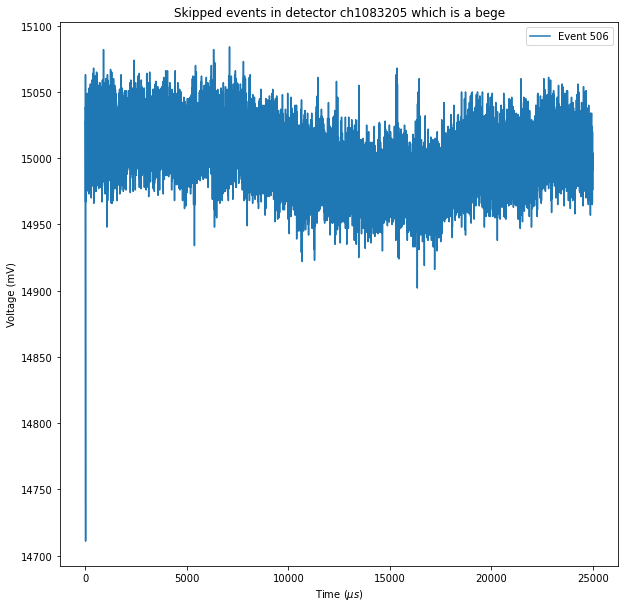

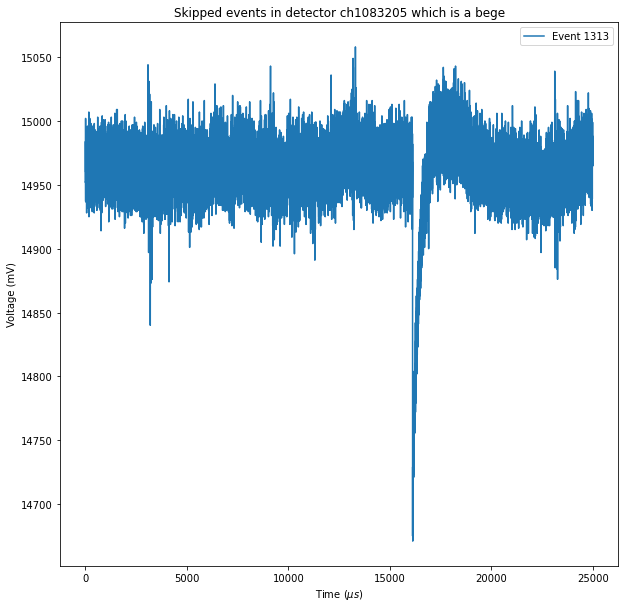

Percentage of discharges present: 0.283286118980175%
Skipped waveforms for detector ch1084800: [408, 444, 474, 481, 1129]


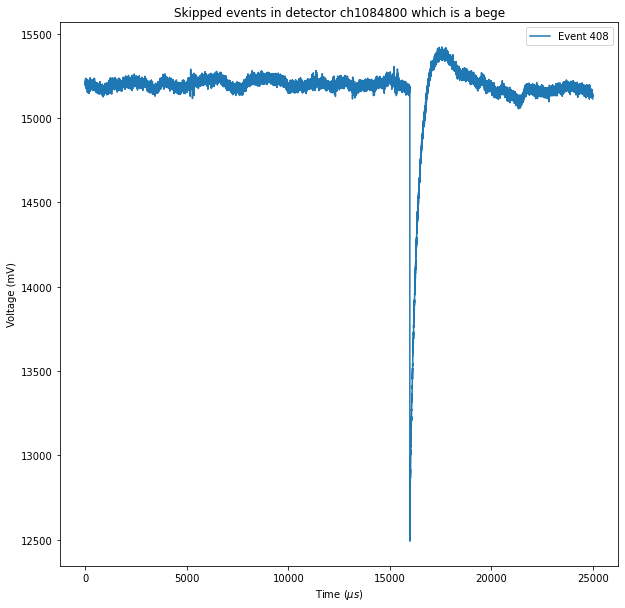

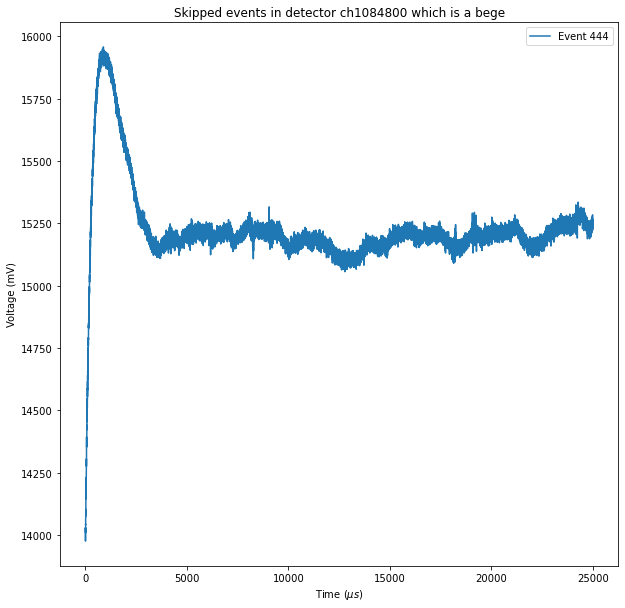

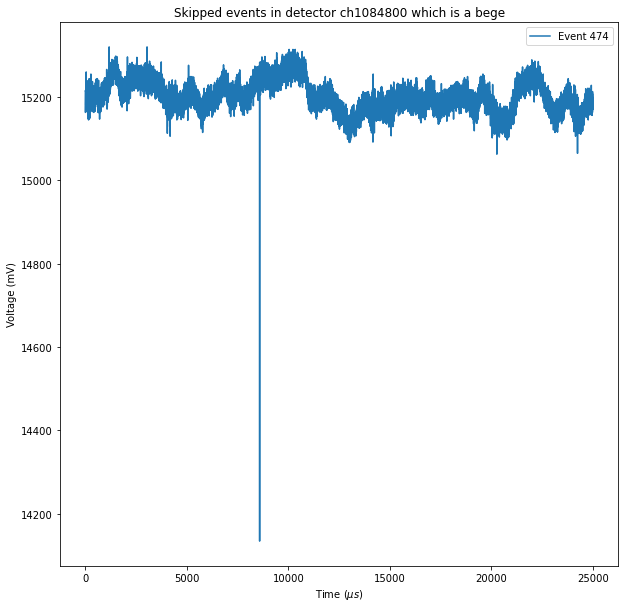

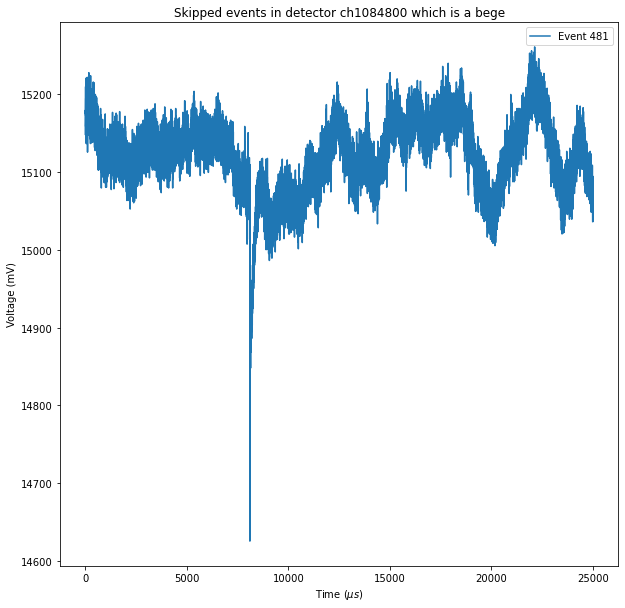

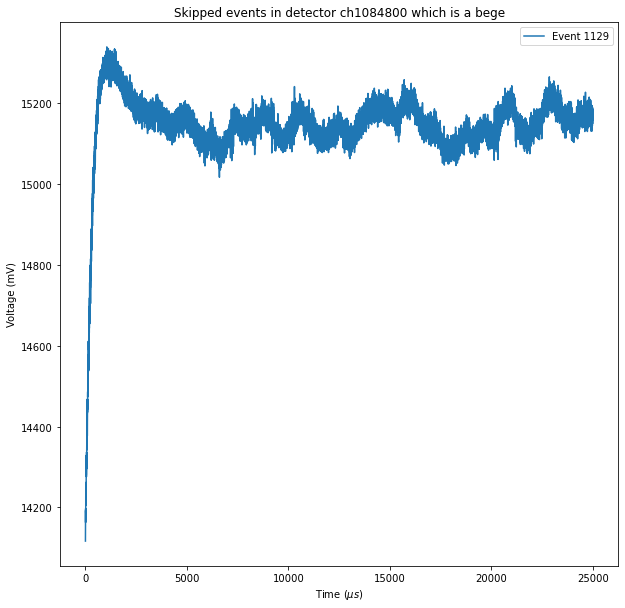

Percentage of discharges present: 0.3541076487252104%
Skipped waveforms for detector ch1084801: [444, 474, 481, 791, 1129]


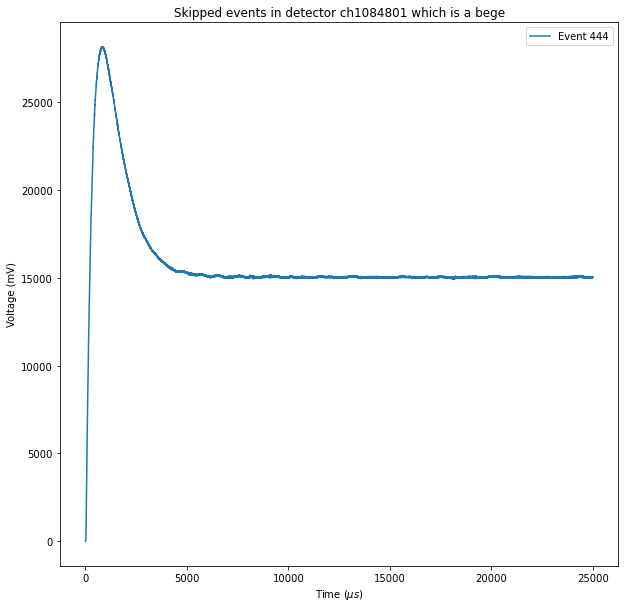

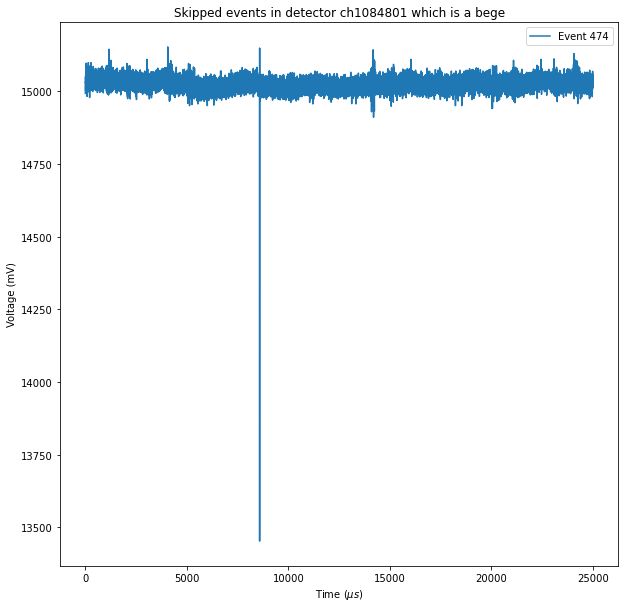

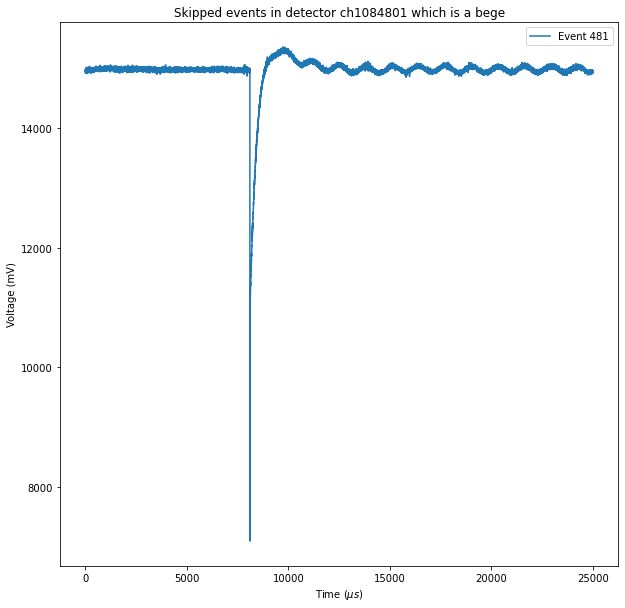

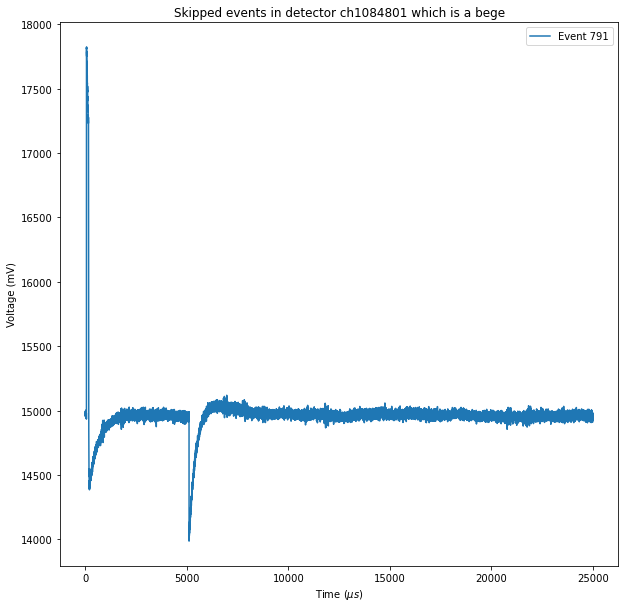

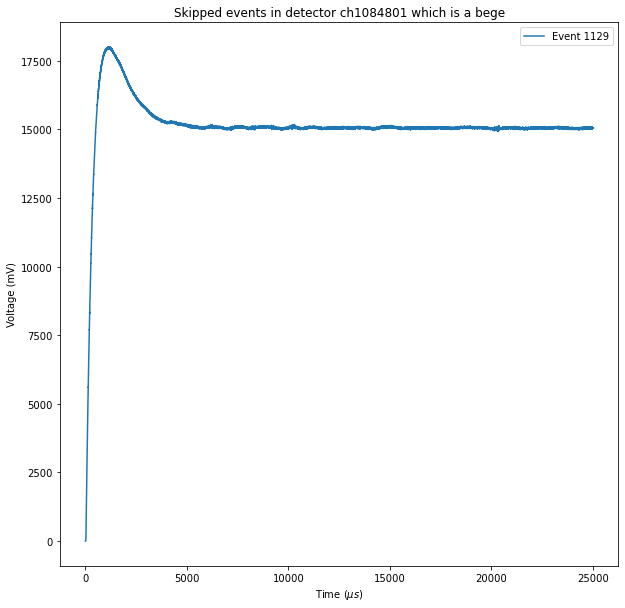

Percentage of discharges present: 0.3541076487252104%
Skipped waveforms for detector ch1084802: [474, 495]


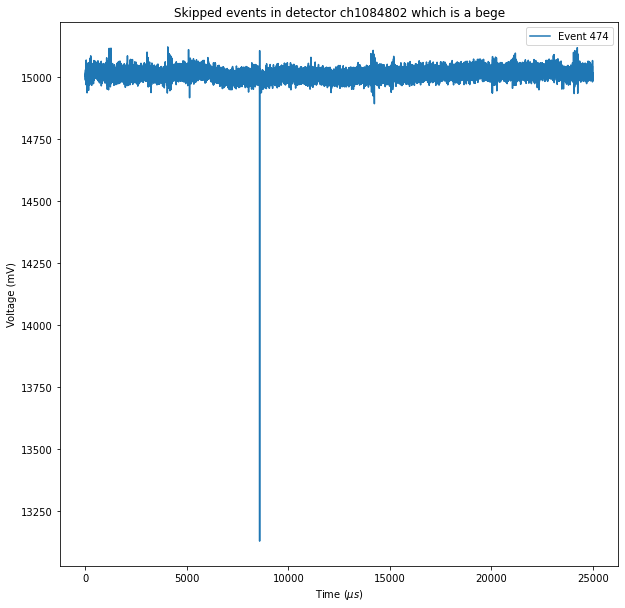

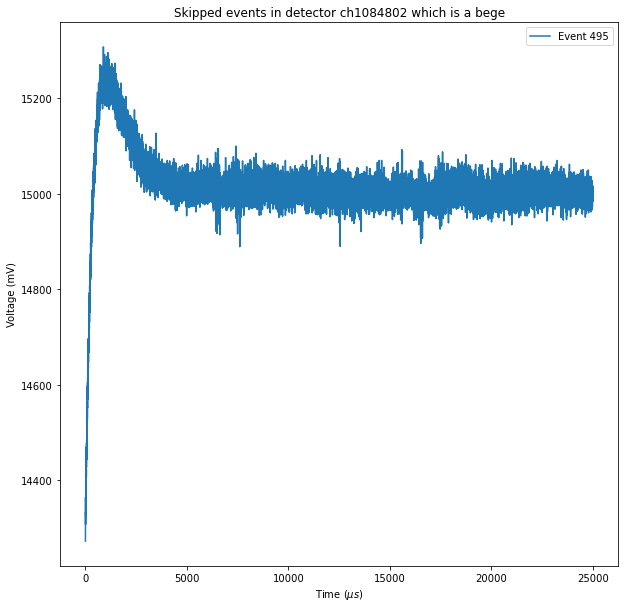

Percentage of discharges present: 0.14164305949008194%
This detector ch1086403 doesn't have any discharges
This detector ch1086404 doesn't have any discharges
Skipped waveforms for detector ch1086405: [163]


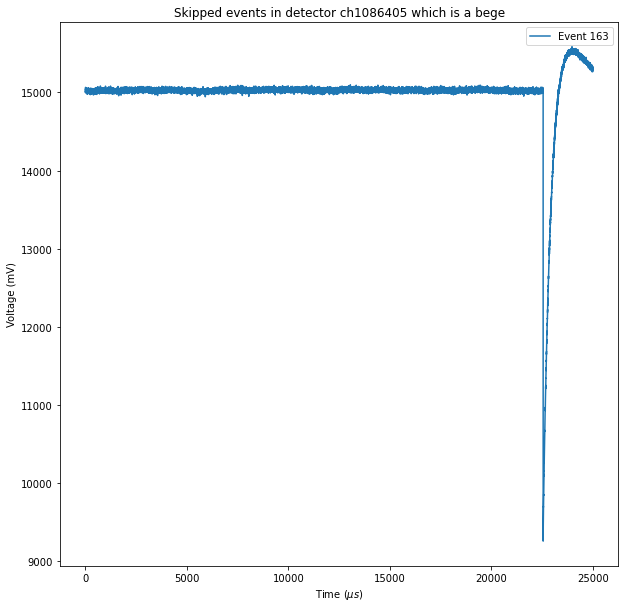

Percentage of discharges present: 0.07082152974504652%


In [22]:
import pandas as pd

df = pd.DataFrame(columns=['Detector Name', 'Percentage of discharge events'])

percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []

for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20: 
        skipped_waveforms[j] = index_skip1  
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:] #removes the ch from the detector name 
            test = cmap[x]['type'] #searches the type of detector the detector is 

            plt.plot(ts[:], wf0[:], label=f'Event {i}') 
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

        diff = len(minimum_dict[j]) - len(index_skip1) 
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        #plt.show() 
    else:
        #if the dataset has more than 20 data points then the data set has no discharges
        percent_discharge[j] = 0
        print(f"This detector {j} doesn't have any discharges")

**Checking efficiency of cuts**

In this section we ensure the efficiency of the cuts, by ensuring all discharge events are included by default

In [23]:
#determining the discharge events in the detectors 
detector_events ={}
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    events = []
    detector_events[j]=events 
    for i in range(len(wfs_all)):
        wf0=wfs_all[i,:]
        if np.any(wf0[:]==0):
            events.append(i)


In [25]:
for j in detectors_bege:
    discharges = detector_events[j]
    try:
        test = skipped_waveforms[j]
    except KeyError:
        test = []
    
    if np.all(discharges == test):
        print("all match")
    else:
        print("they don't all match")
        

all match
they don't all match
they don't all match
all match
they don't all match
they don't all match
they don't all match
they don't all match
they don't all match
all match
they don't all match
they don't all match
all match
they don't all match
all match
all match
all match
they don't all match
they don't all match
they don't all match
they don't all match
they don't all match
they don't all match
they don't all match
they don't all match
all match
all match
they don't all match


In [26]:
#combining all the events together 
final_events = {}
for j in detectors_bege:
    all_zeros = detector_events[j]
    try:
        all_events = skipped_waveforms[j]
    except KeyError:
        all_events =[]
    
    combo=all_zeros+all_events
    final = np.unique(combo)
    final_events[j]=final 

Skipped waveforms for detector ch1107202: []
Percentage of discharges present: 0.0%
Skipped waveforms for detector ch1110402: [1130 1177 1361]


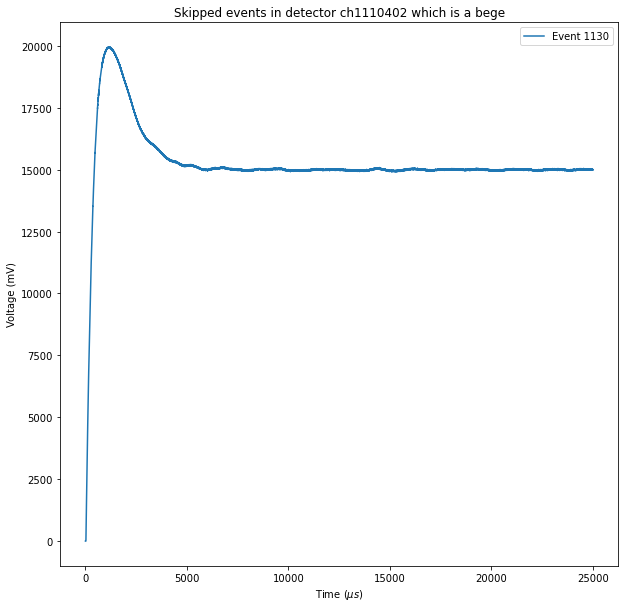

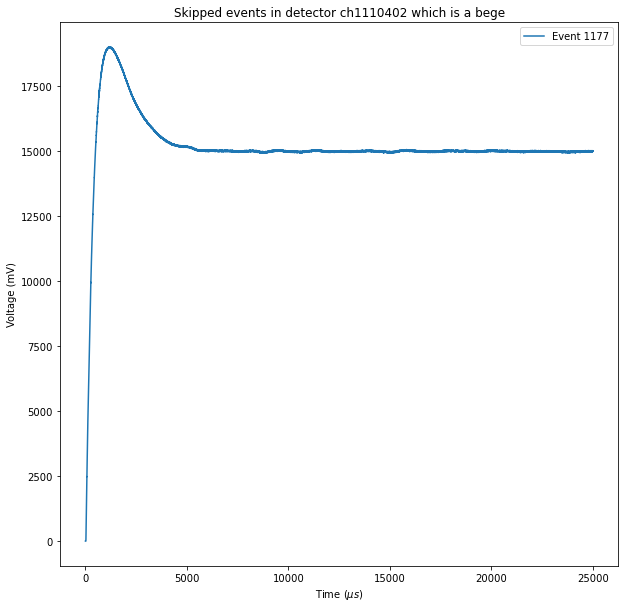

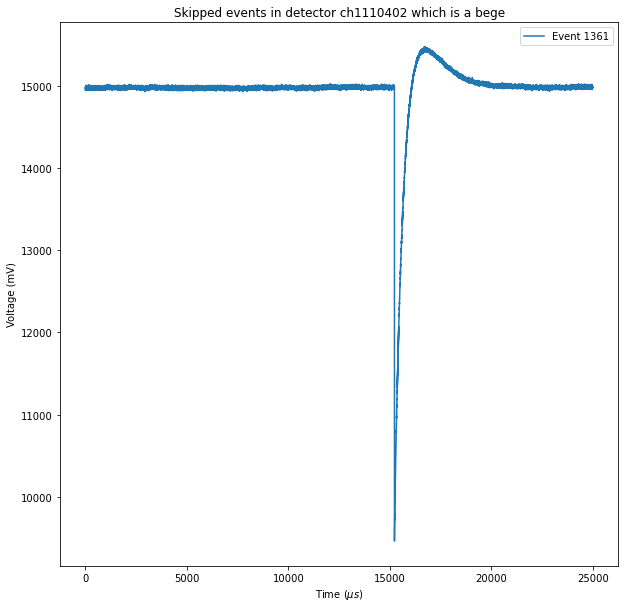

Percentage of discharges present: 0.21246458923512845%
Skipped waveforms for detector ch1110403: [ 51 393]


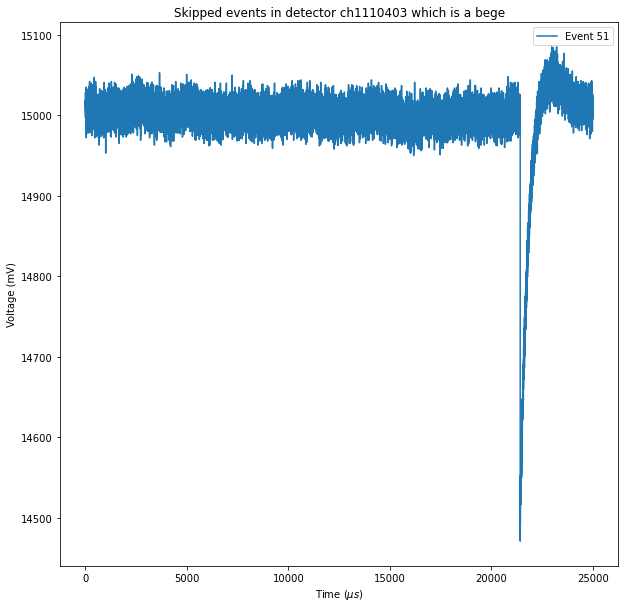

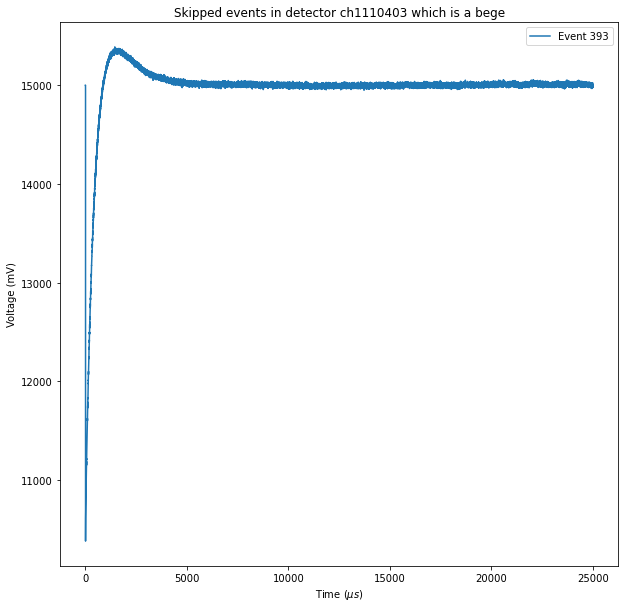

Percentage of discharges present: 0.14164305949008194%
Skipped waveforms for detector ch1112005: []
Percentage of discharges present: 0.0%
Skipped waveforms for detector ch1113600: [  37   88  130  467  827  962 1317]


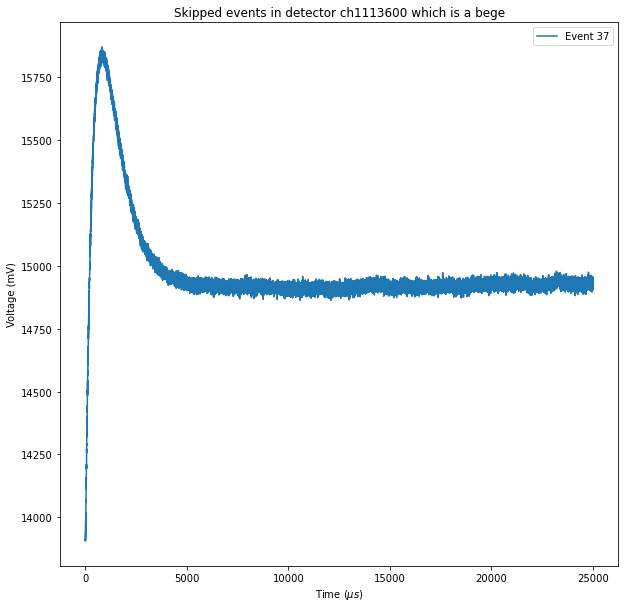

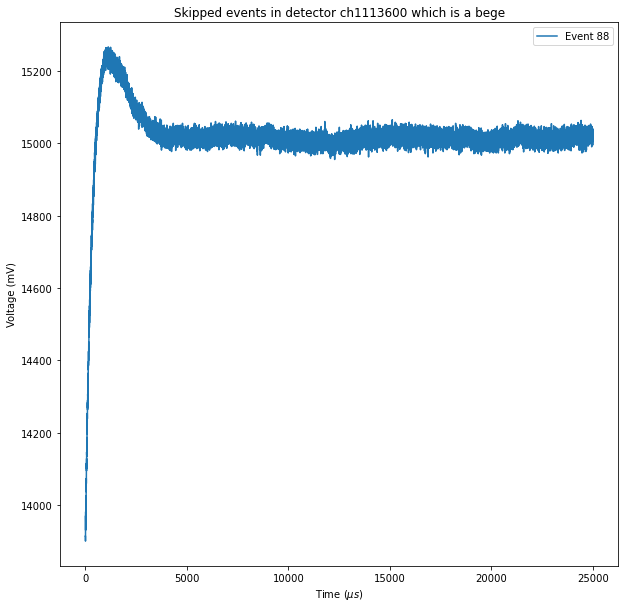

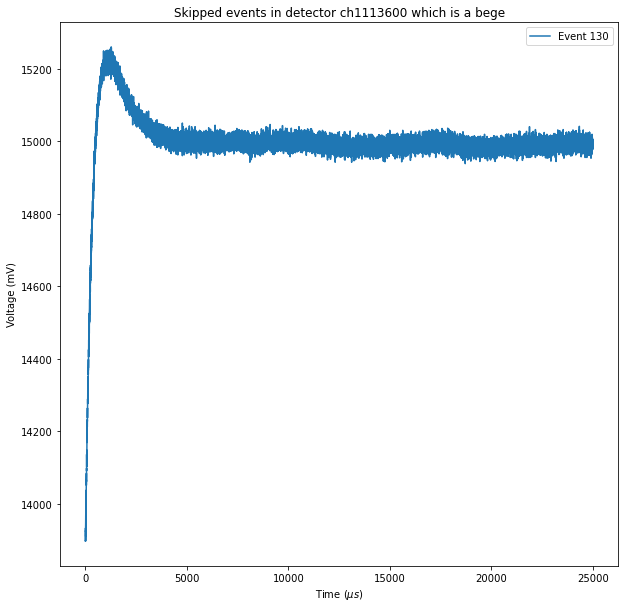

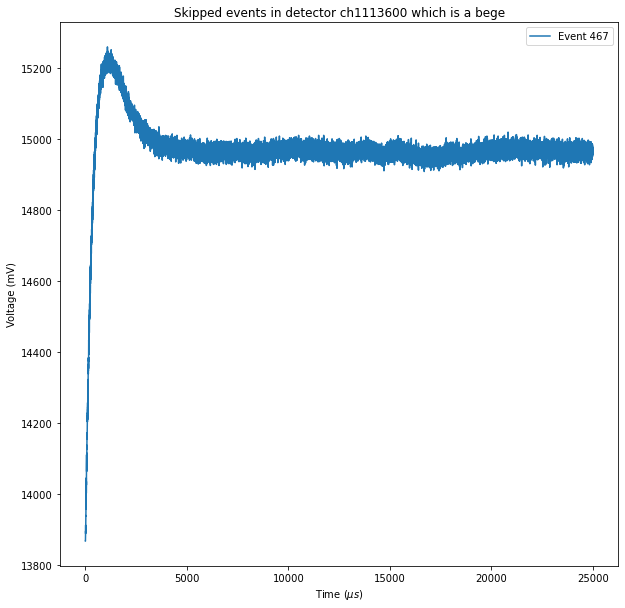

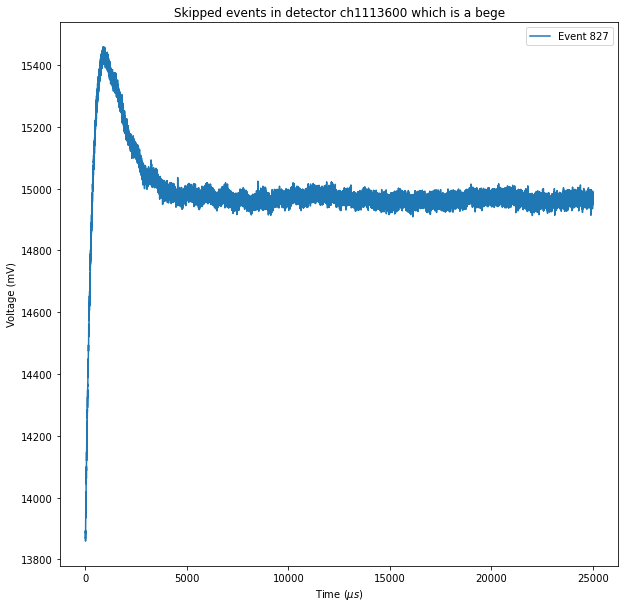

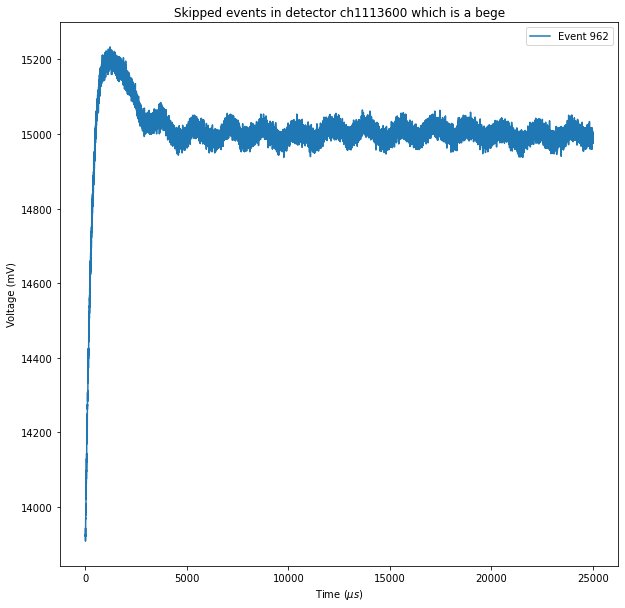

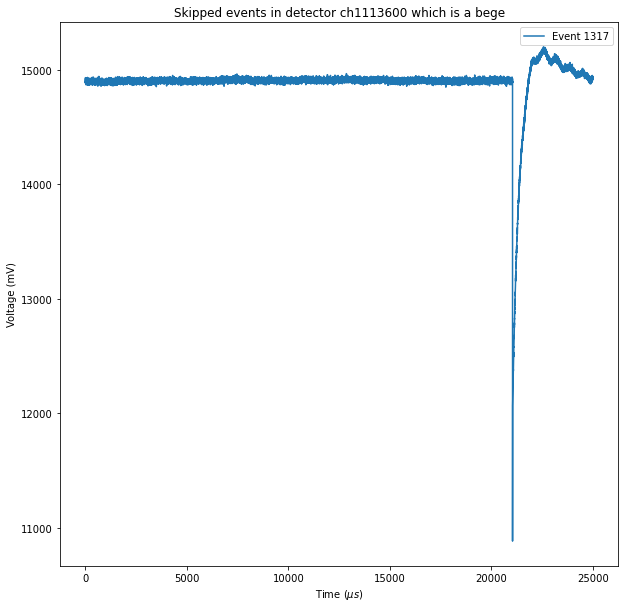

Percentage of discharges present: 0.4957507082152923%
Skipped waveforms for detector ch1113601: [ 37  88 130 467 827 858 962]


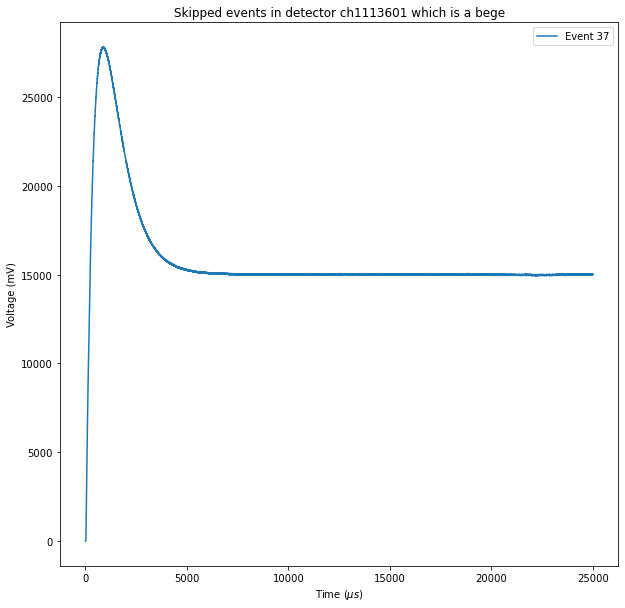

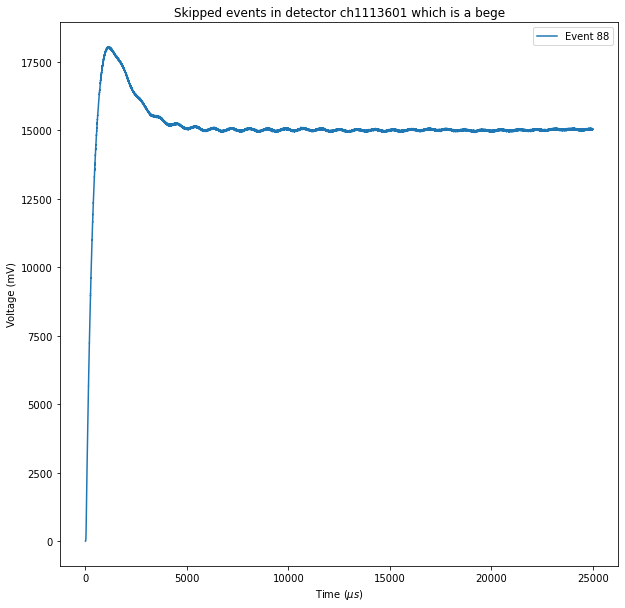

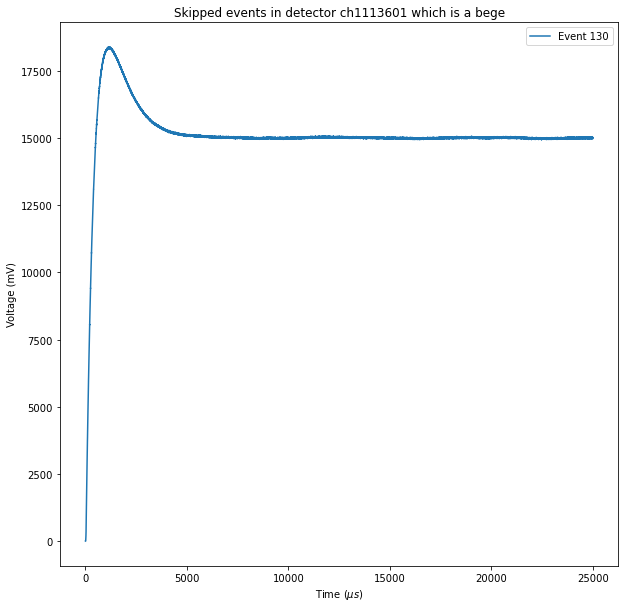

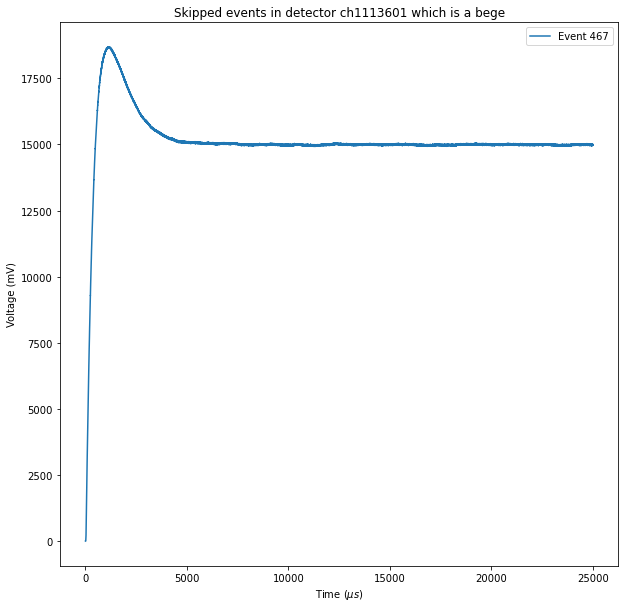

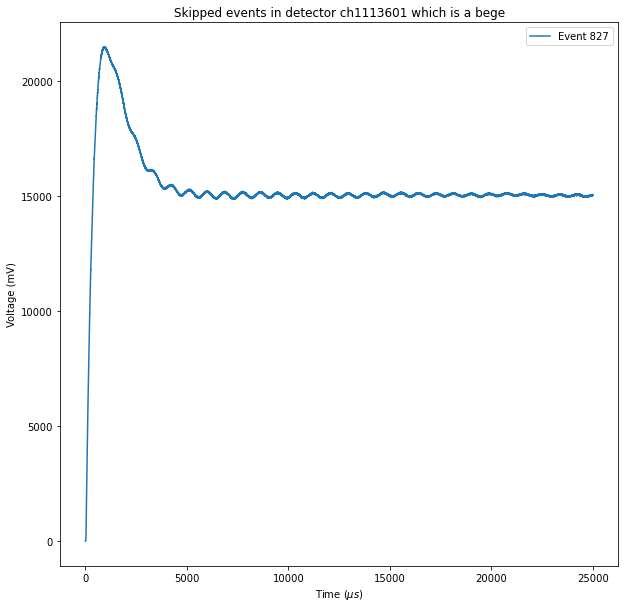

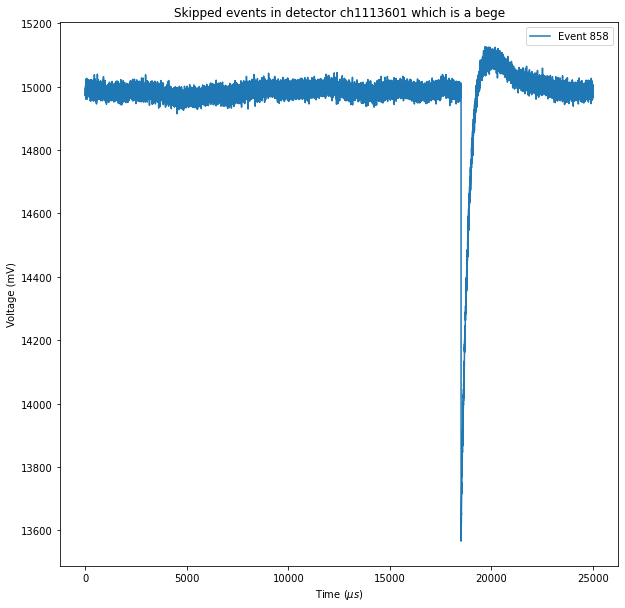

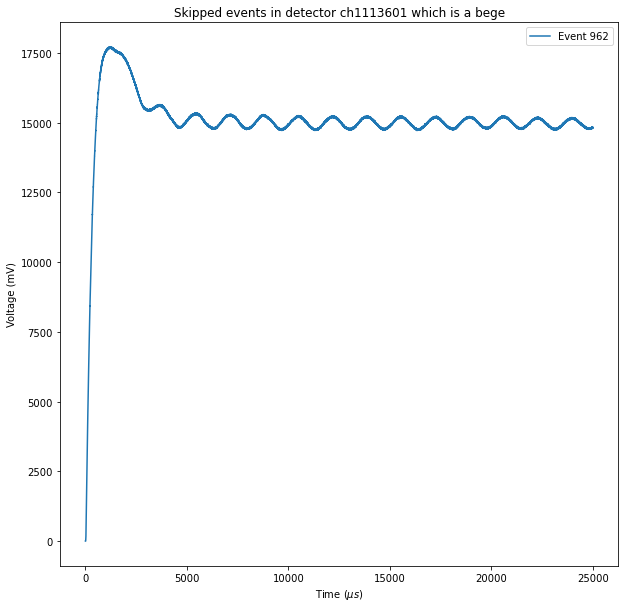

Percentage of discharges present: 0.4957507082152923%
Skipped waveforms for detector ch1113602: [ 139  858  978 1265 1272 1292]


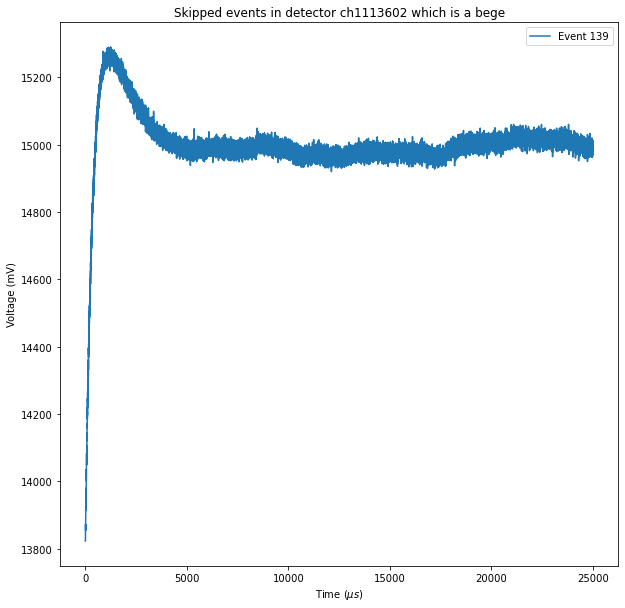

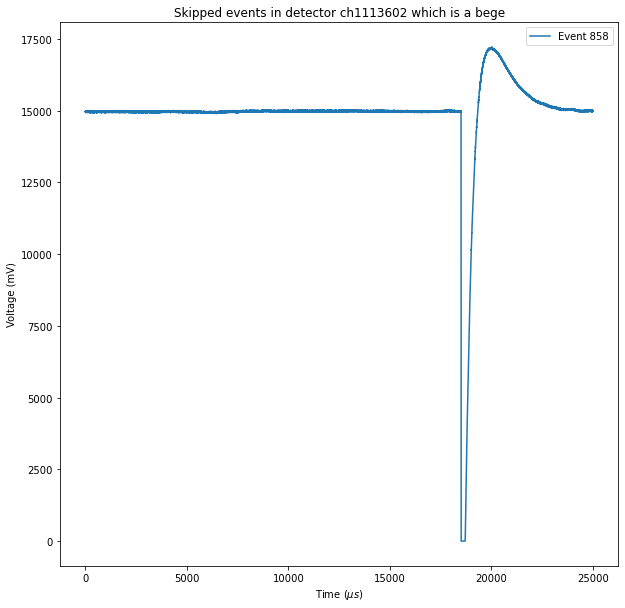

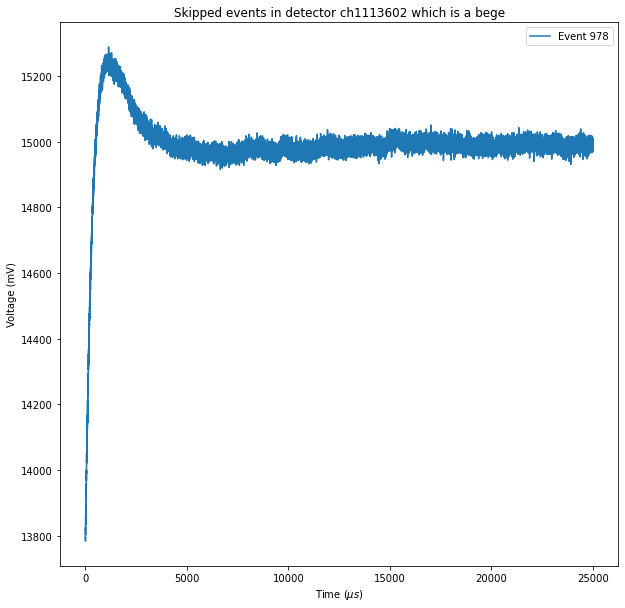

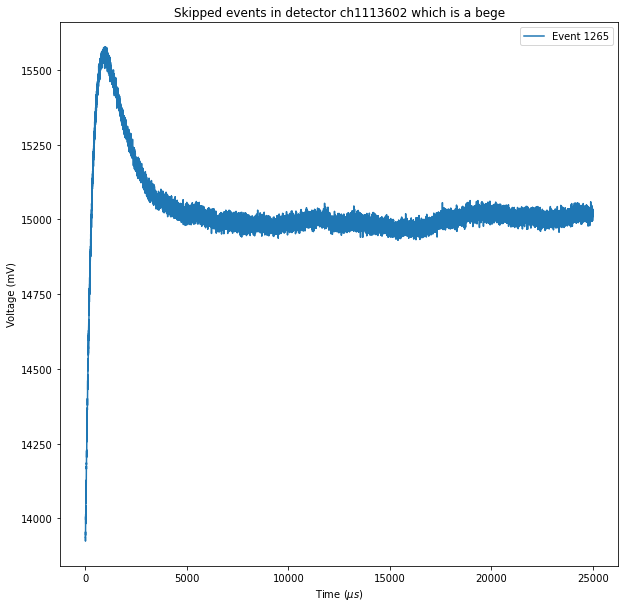

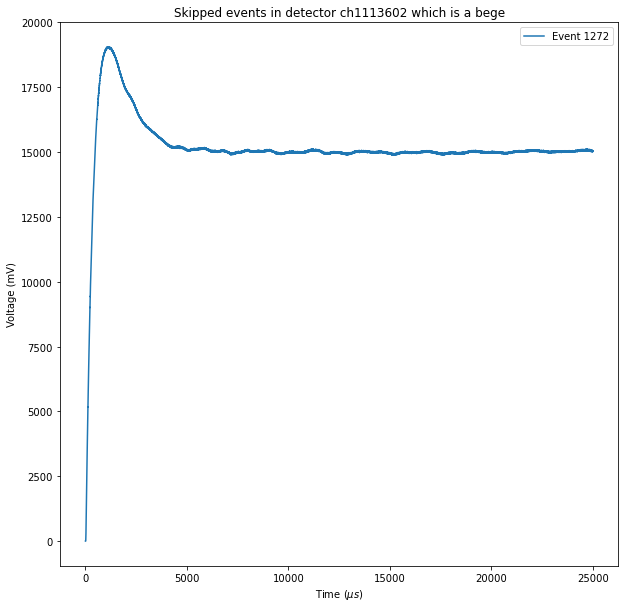

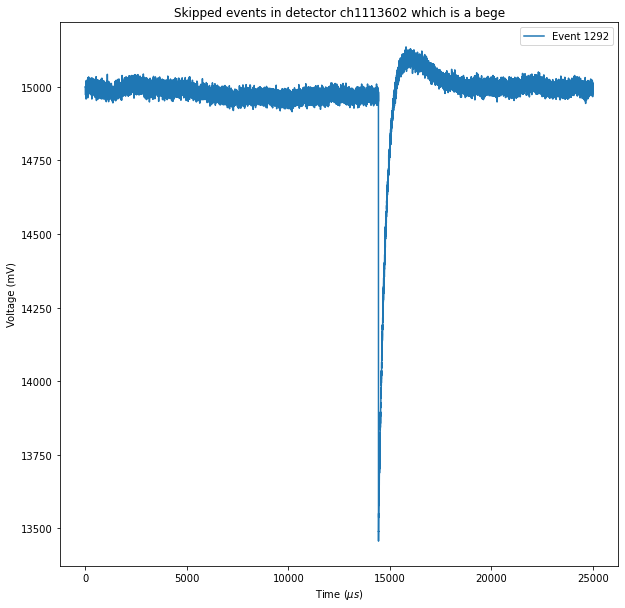

Percentage of discharges present: 0.4249291784702569%
Skipped waveforms for detector ch1113603: [ 139  978 1265]


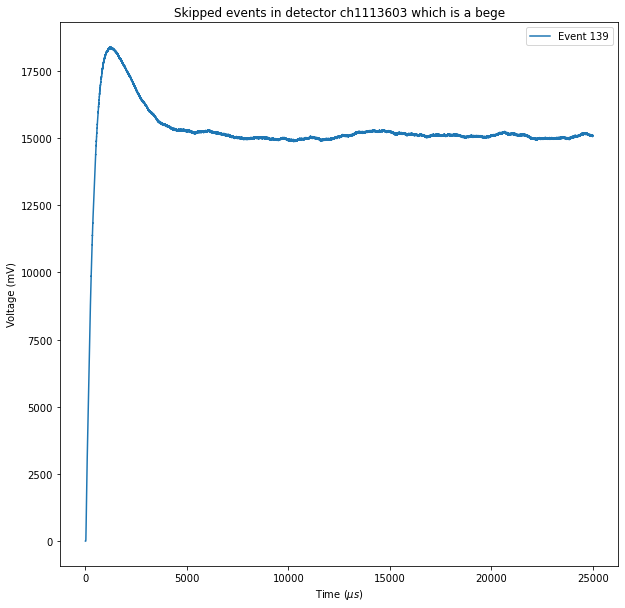

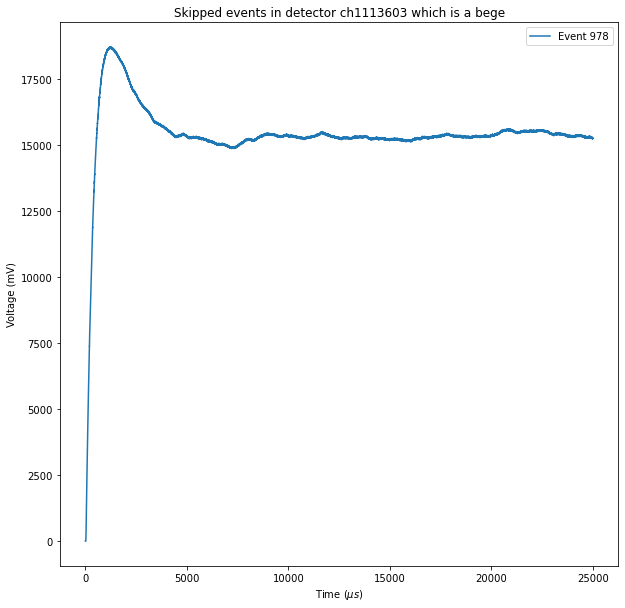

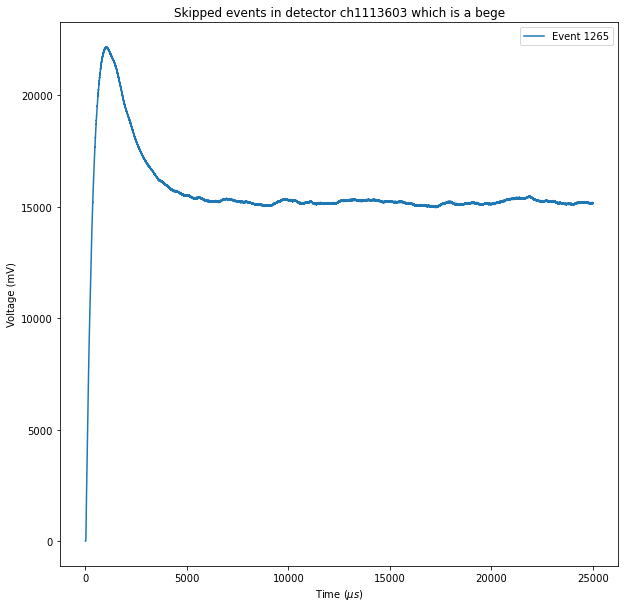

Percentage of discharges present: 0.21246458923512845%
Skipped waveforms for detector ch1113604: [ 514 1161]


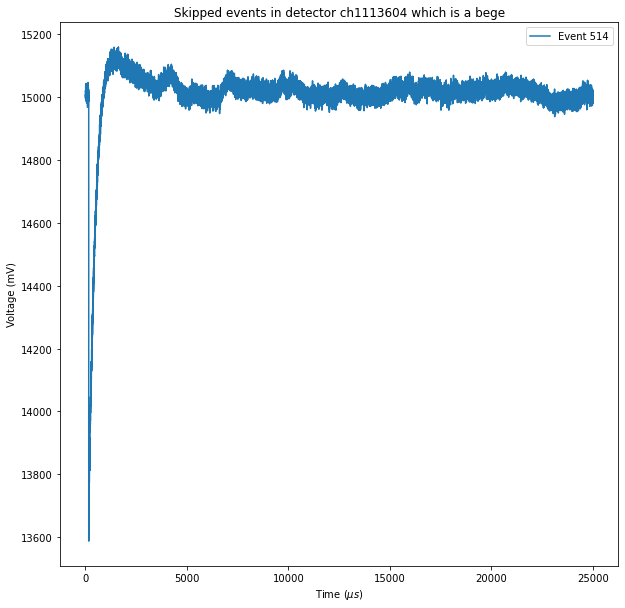

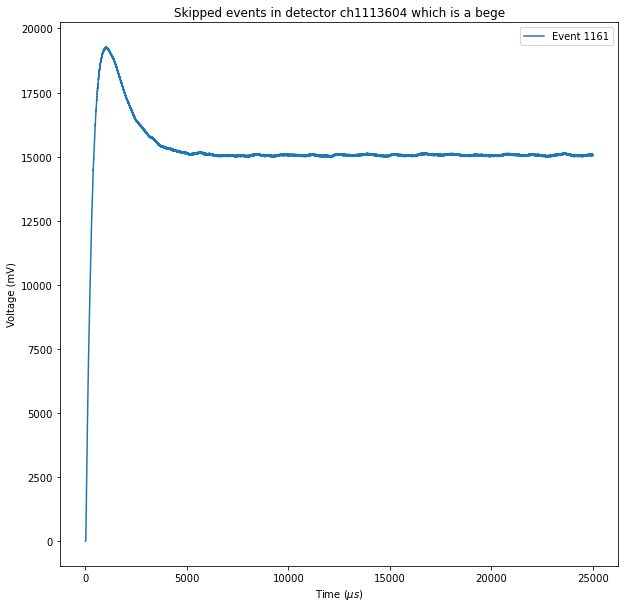

Percentage of discharges present: 0.14164305949008194%
Skipped waveforms for detector ch1113605: []
Percentage of discharges present: 0.0%
Skipped waveforms for detector ch1120003: [  62  210  456  478  532  546  672  982 1200 1405]


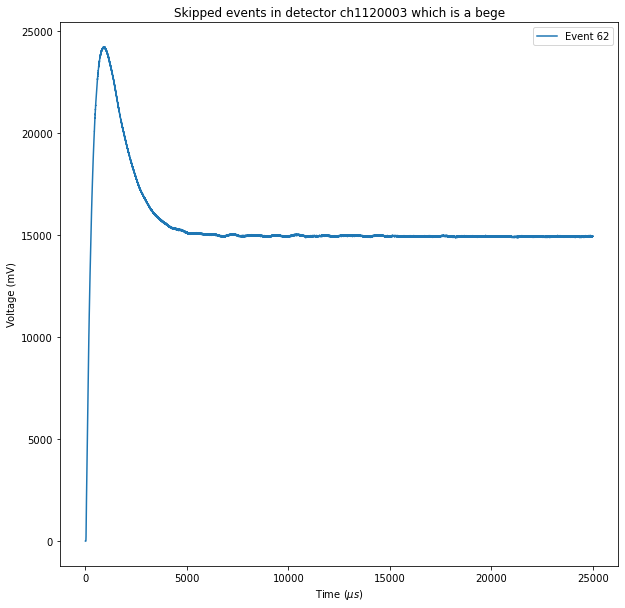

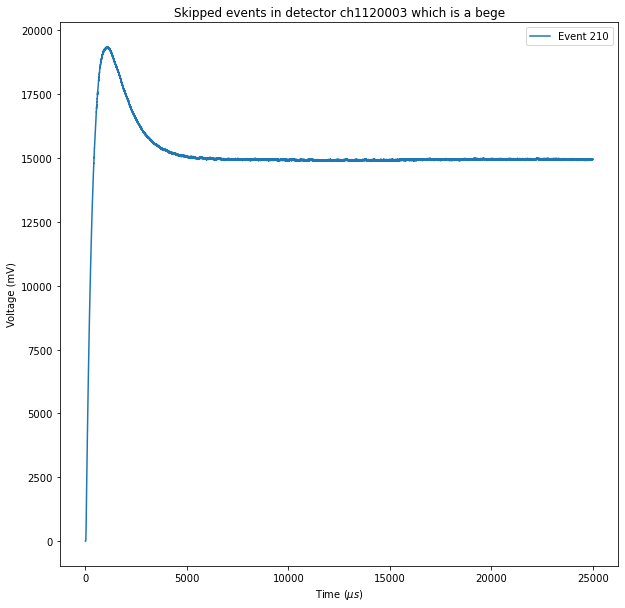

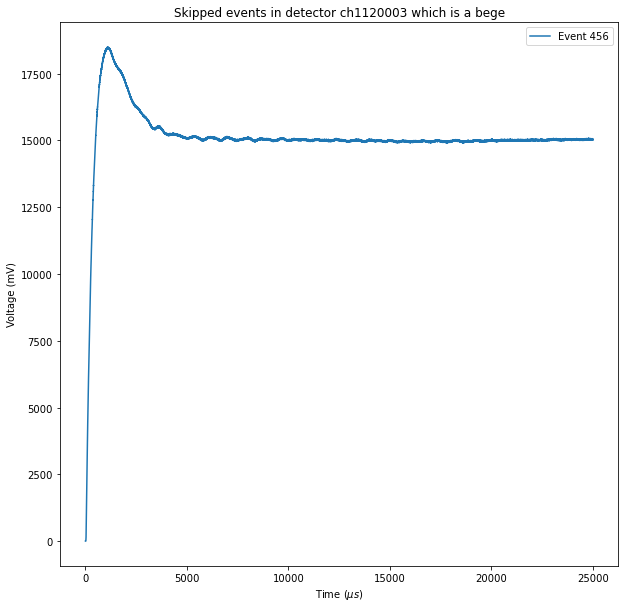

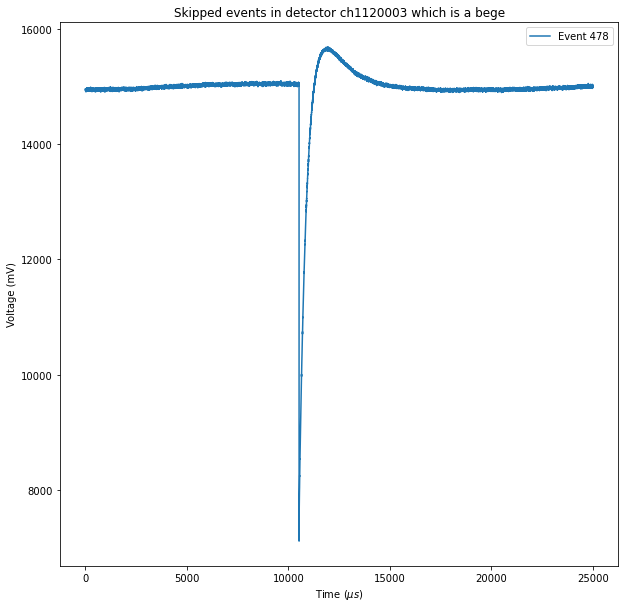

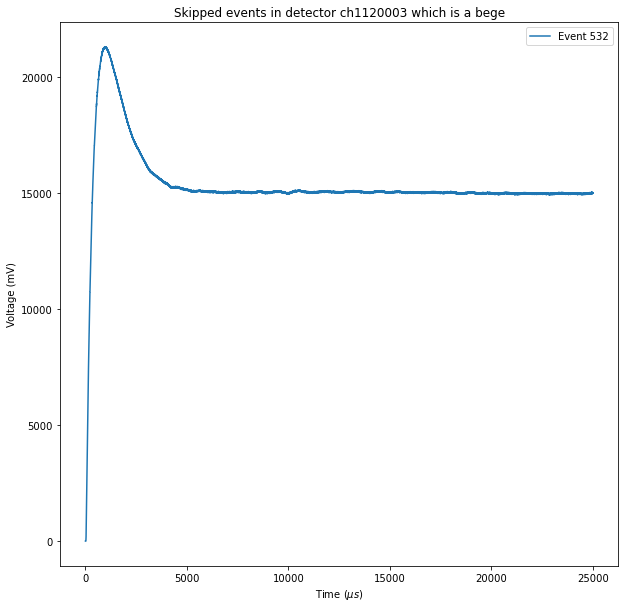

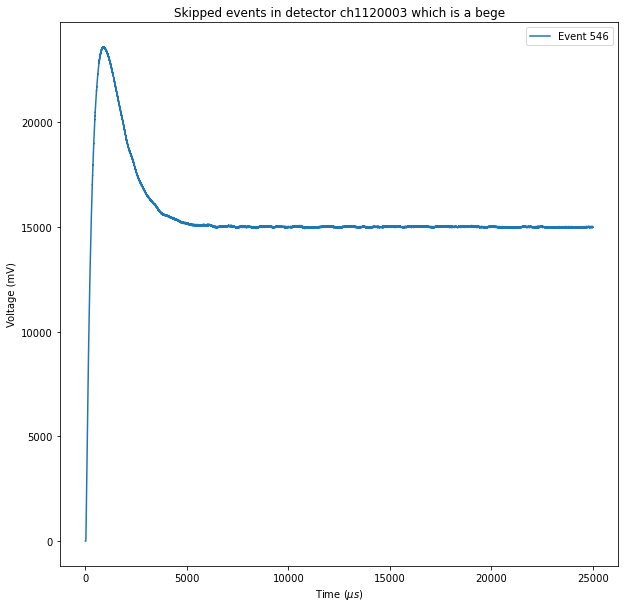

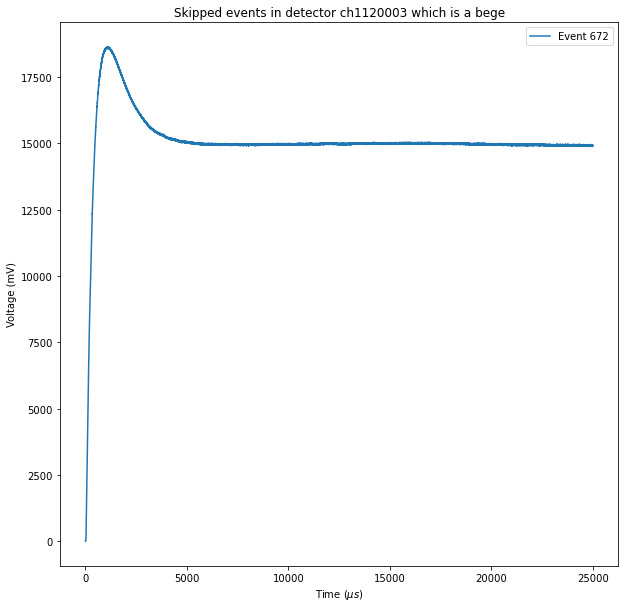

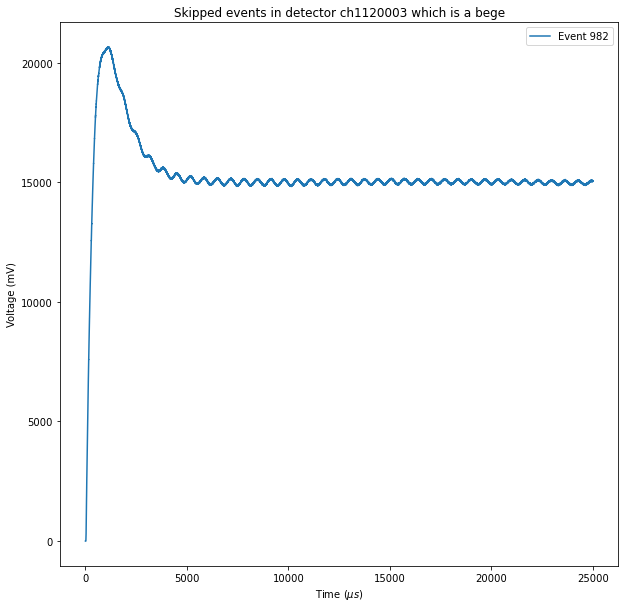

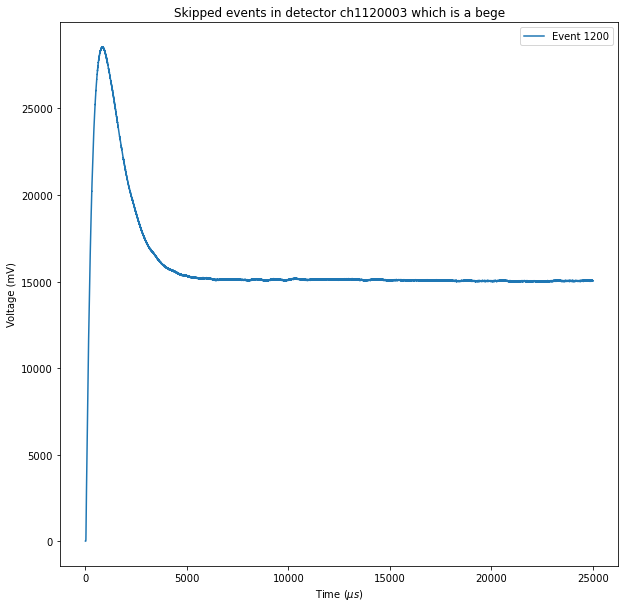

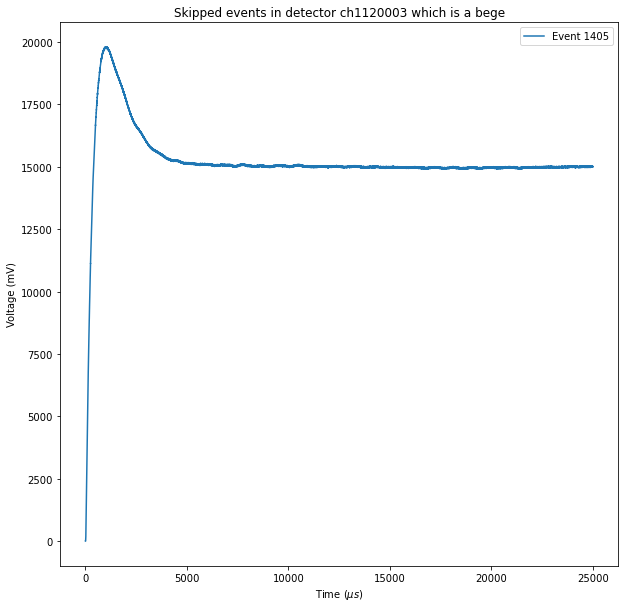

Percentage of discharges present: 0.7082152974504208%
Skipped waveforms for detector ch1120004: [ 389  397  761 1227]


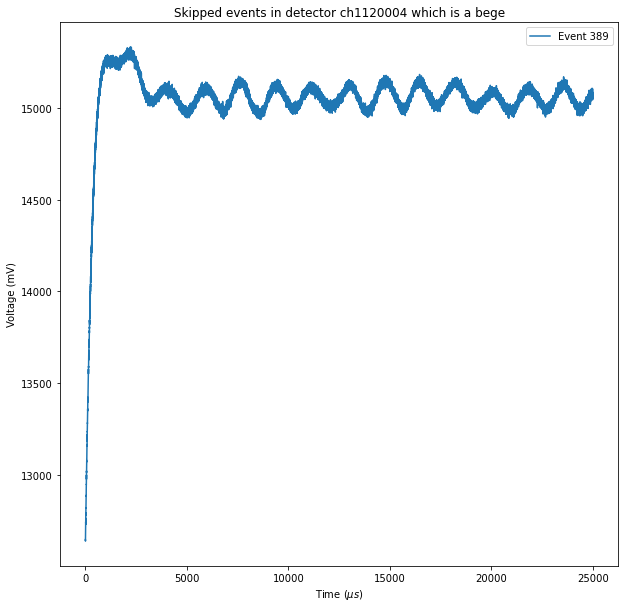

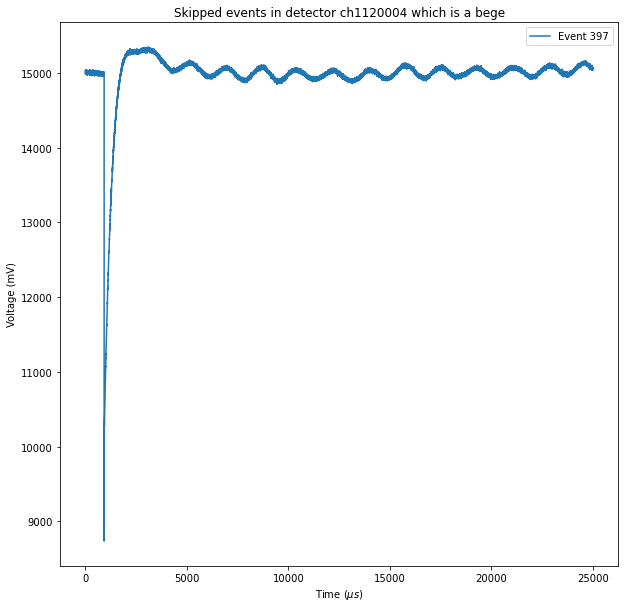

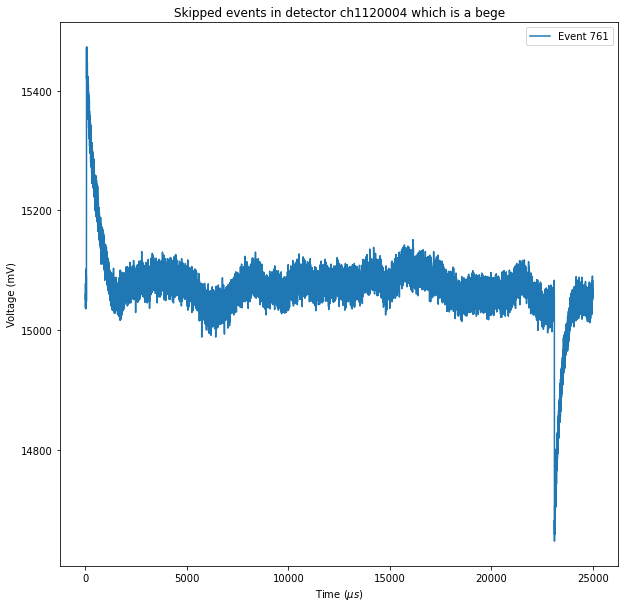

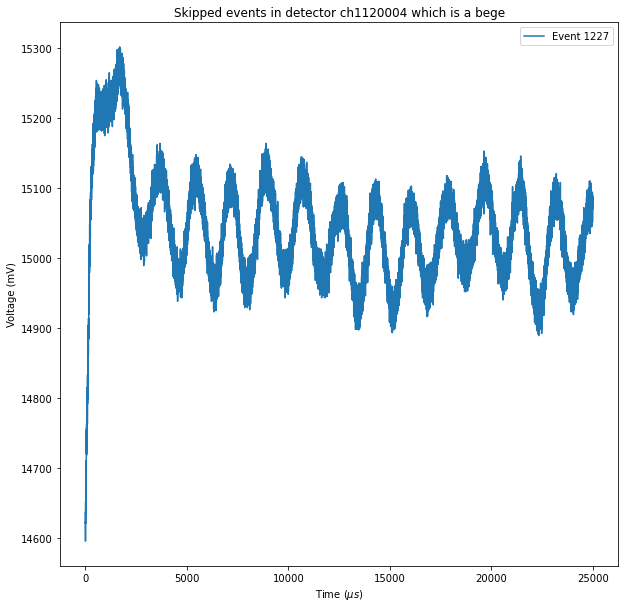

Percentage of discharges present: 0.283286118980175%
Skipped waveforms for detector ch1078405: []
Percentage of discharges present: 0.0%
Skipped waveforms for detector ch1080000: [ 494  501 1097 1303]


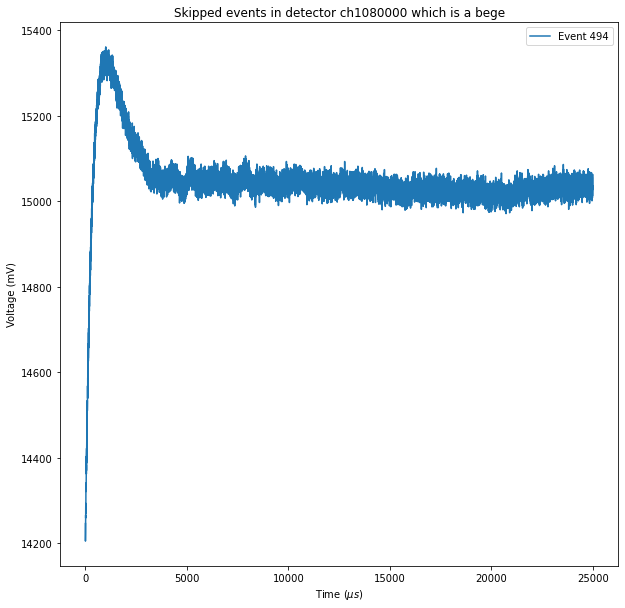

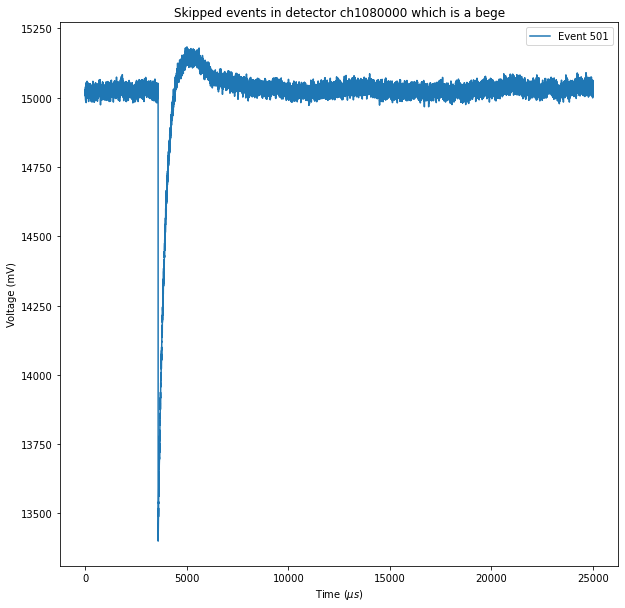

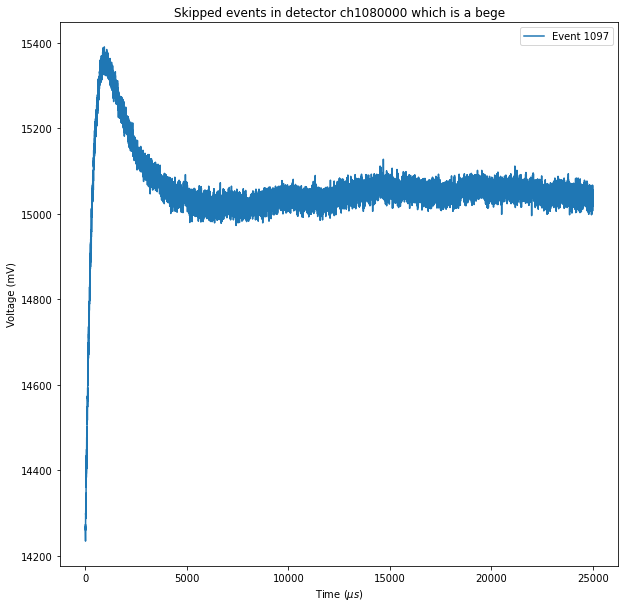

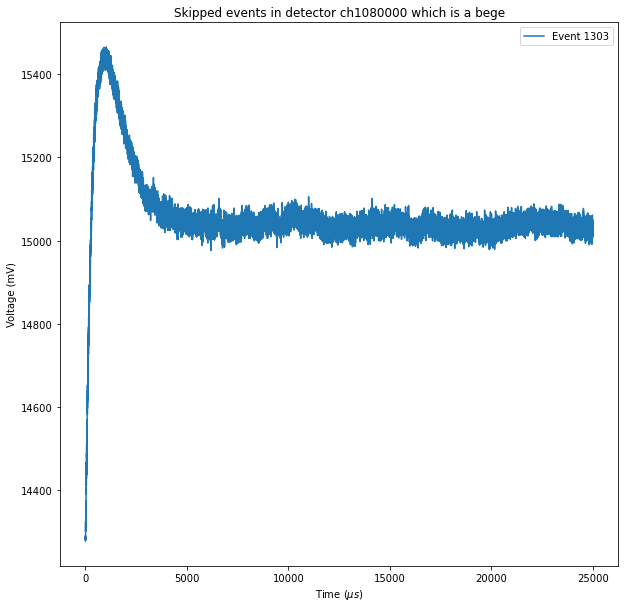

Percentage of discharges present: 0.283286118980175%
Skipped waveforms for detector ch1080001: [ 494 1097 1303]


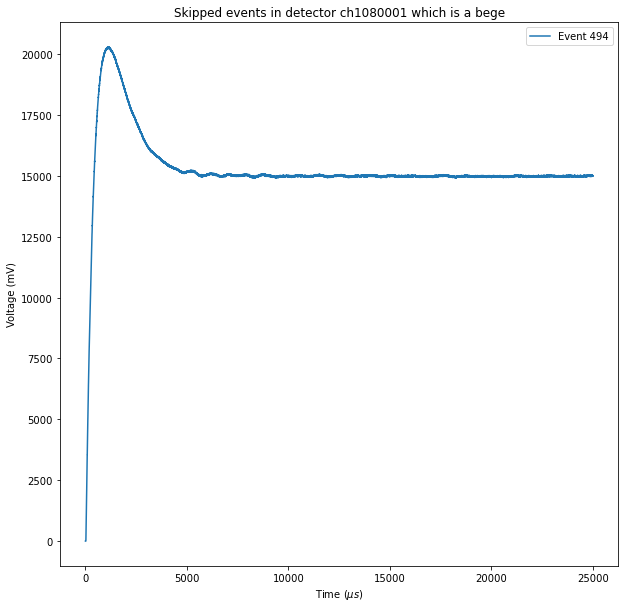

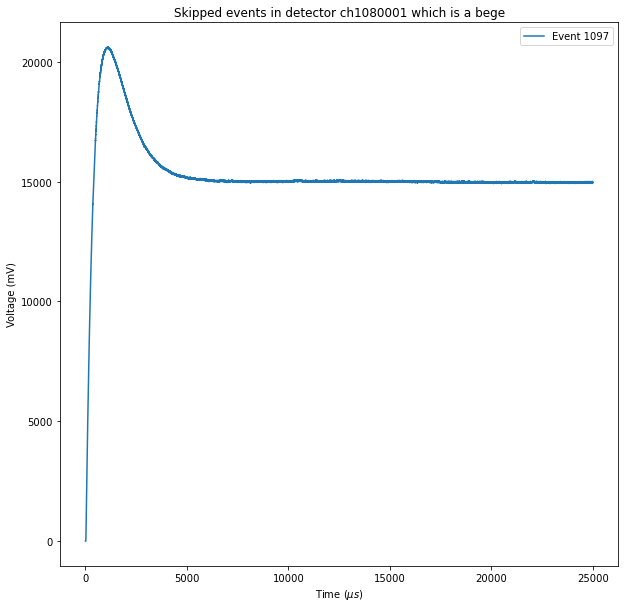

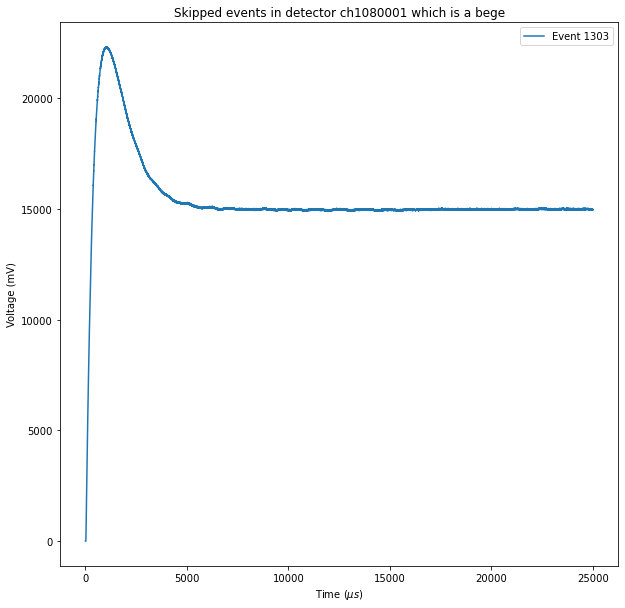

Percentage of discharges present: 0.21246458923512845%
Skipped waveforms for detector ch1080002: []
Percentage of discharges present: 0.0%
Skipped waveforms for detector ch1083200: []
Percentage of discharges present: 0.0%
Skipped waveforms for detector ch1083201: [  85  430  448  506  850  906 1094]


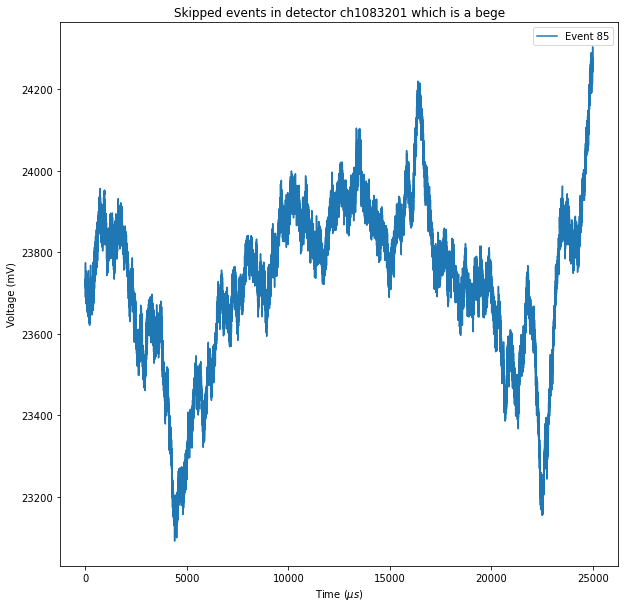

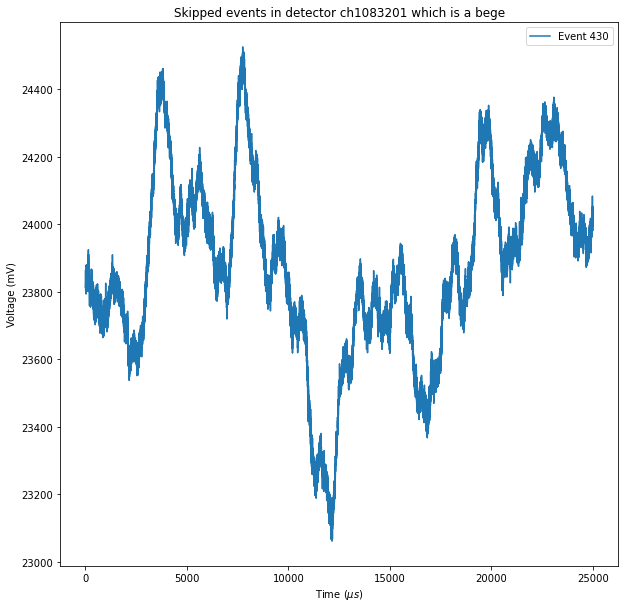

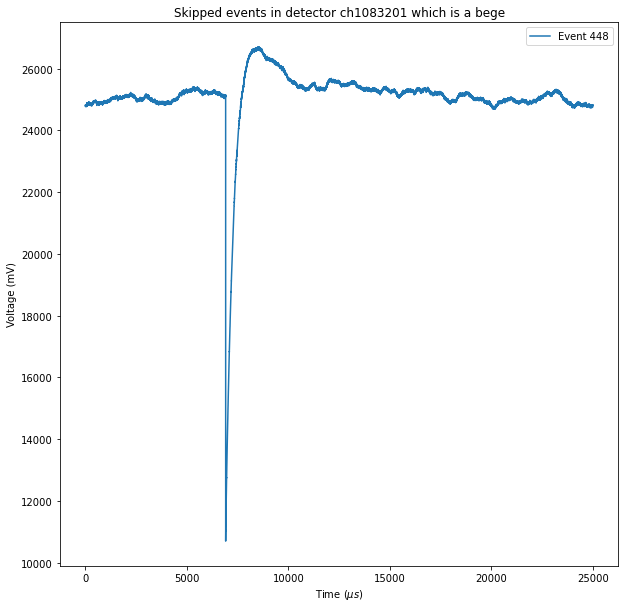

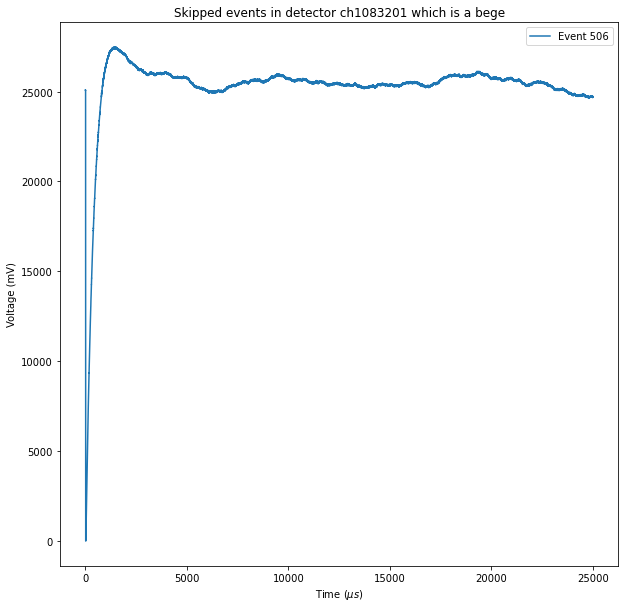

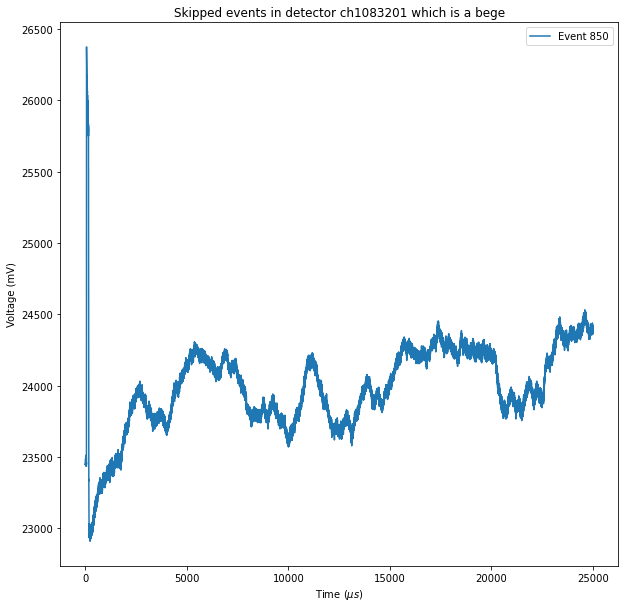

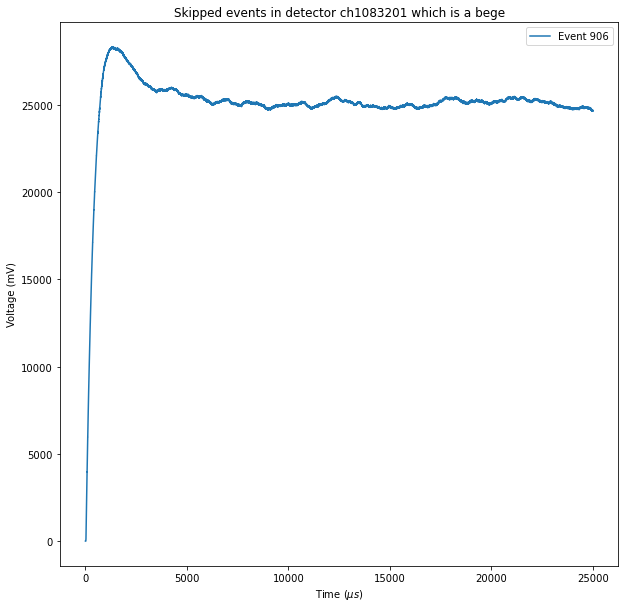

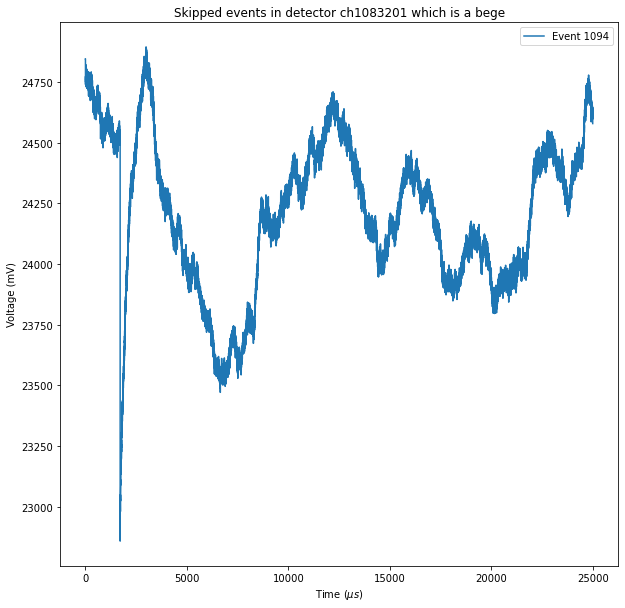

Percentage of discharges present: 0.4957507082152923%
Skipped waveforms for detector ch1083202: [ 474  506 1160 1402]


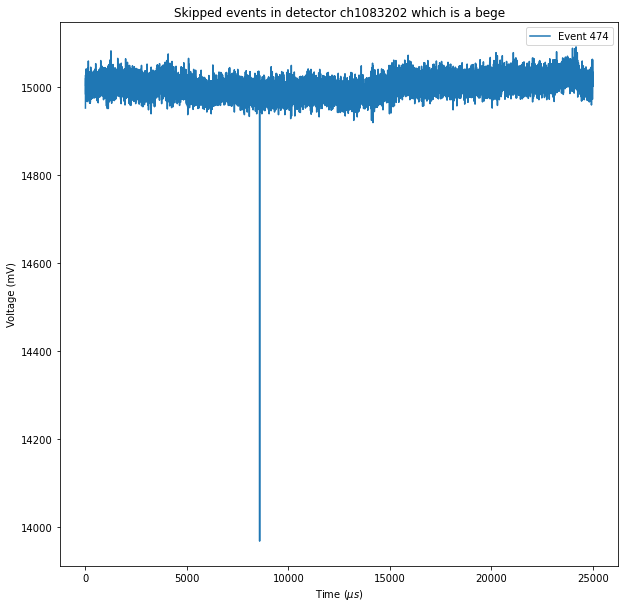

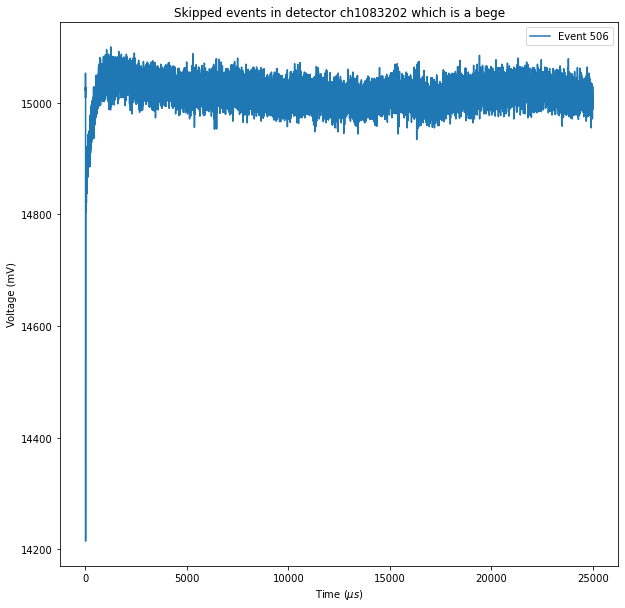

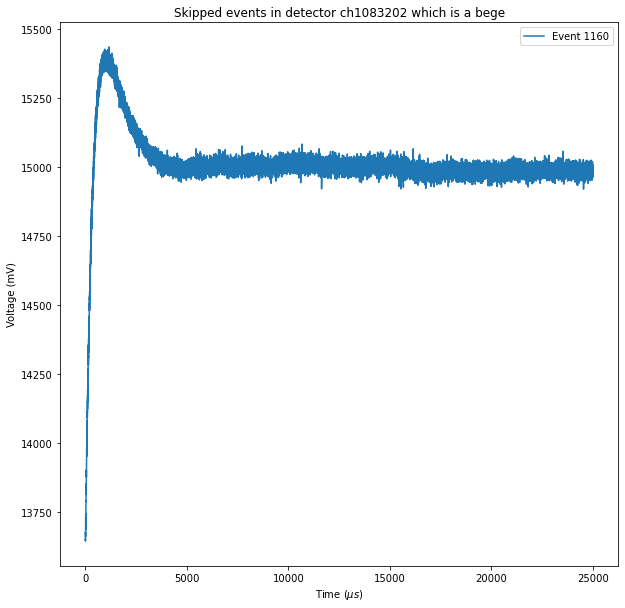

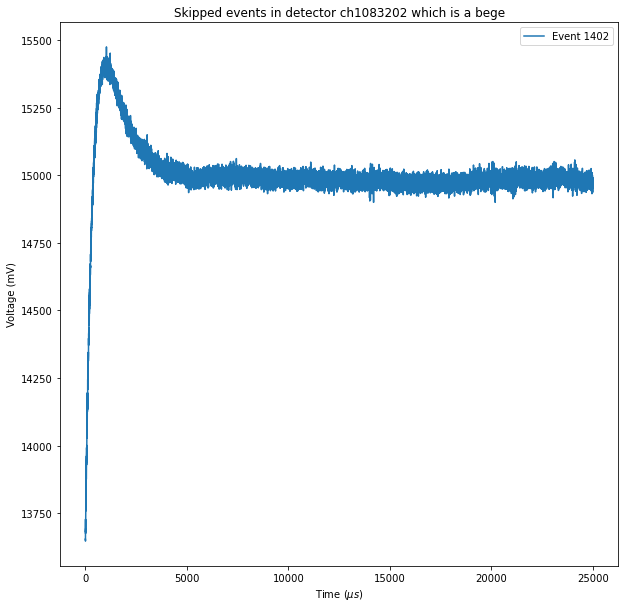

Percentage of discharges present: 0.283286118980175%
Skipped waveforms for detector ch1083203: [  32  437  573 1160 1224 1402]


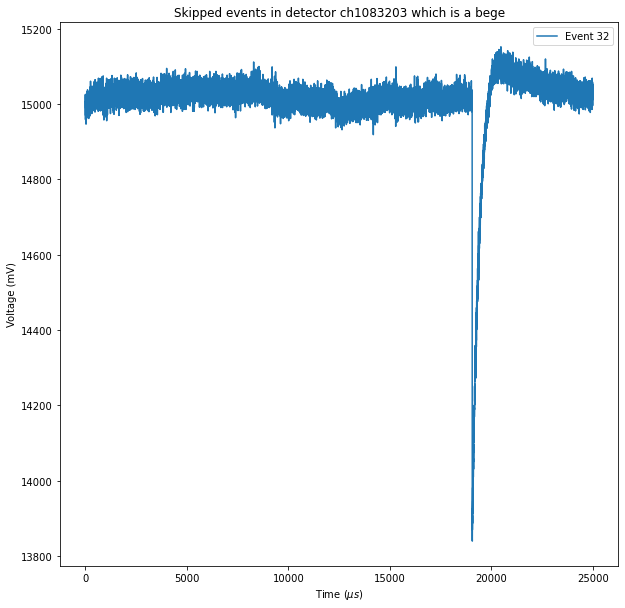

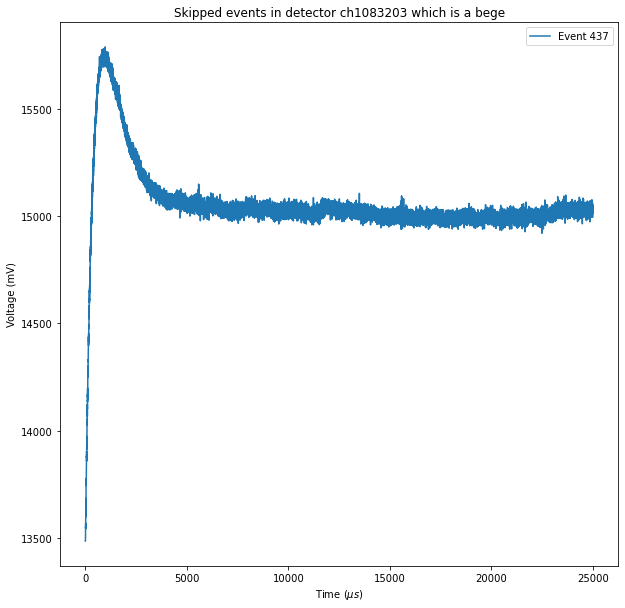

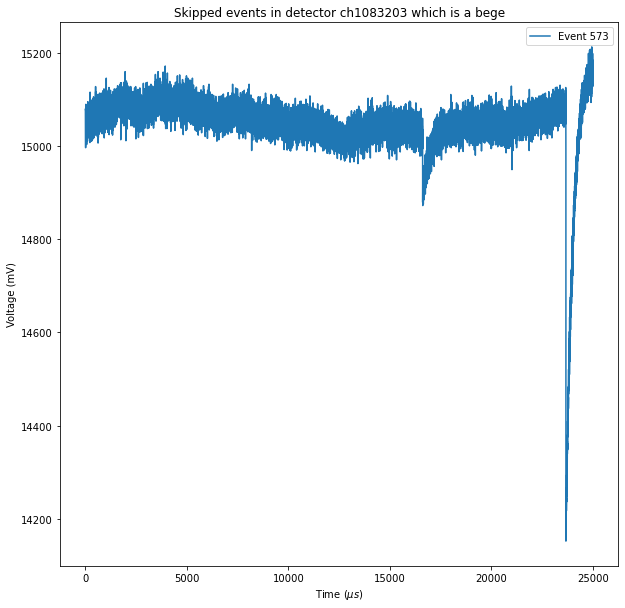

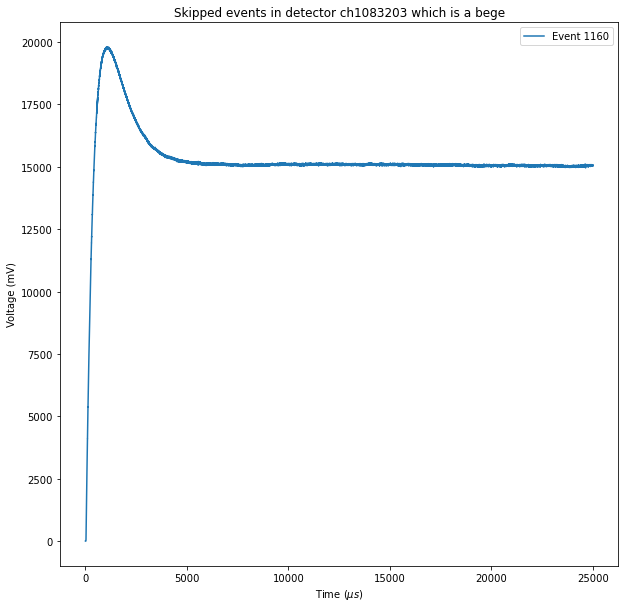

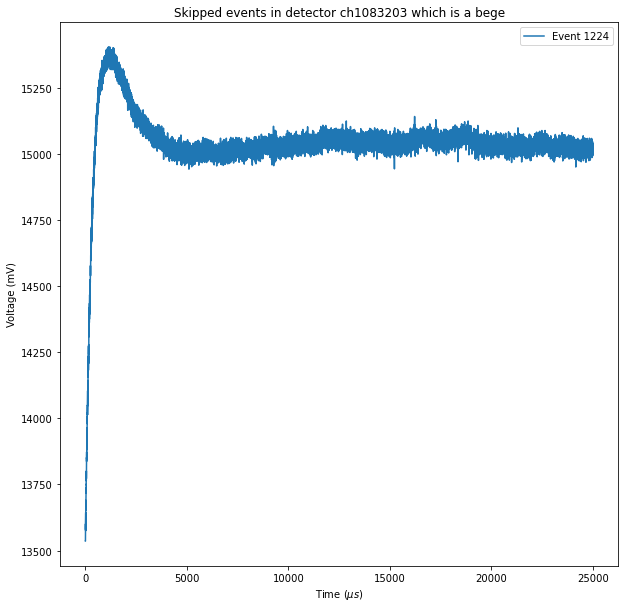

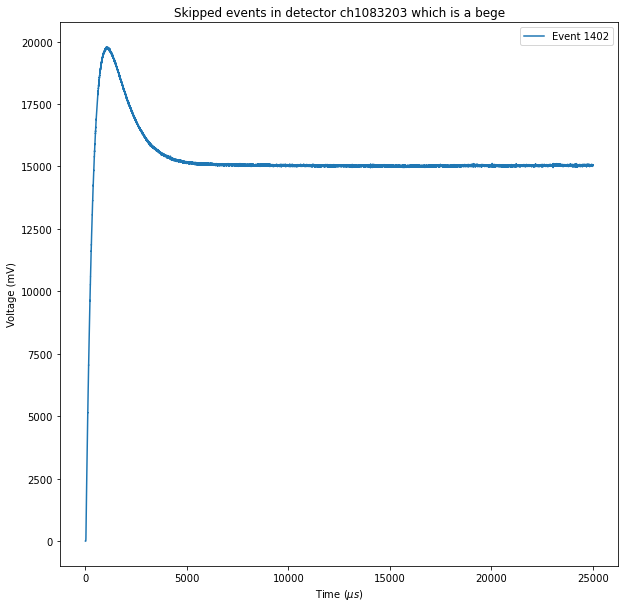

Percentage of discharges present: 0.4249291784702569%
Skipped waveforms for detector ch1083204: [ 437  474 1224]


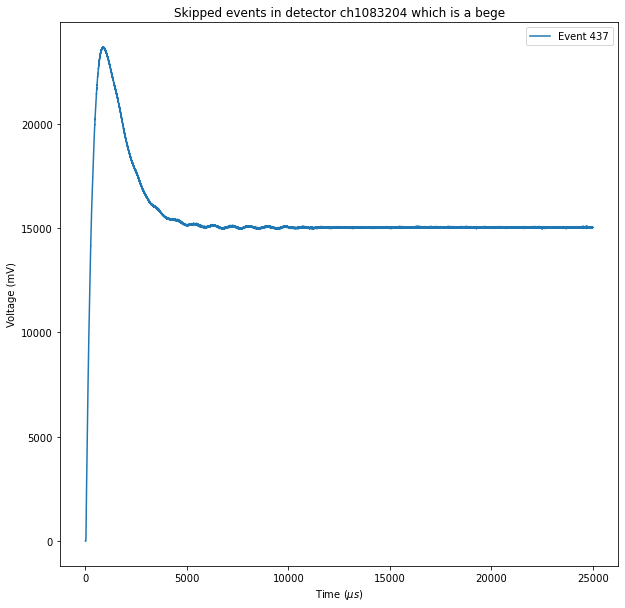

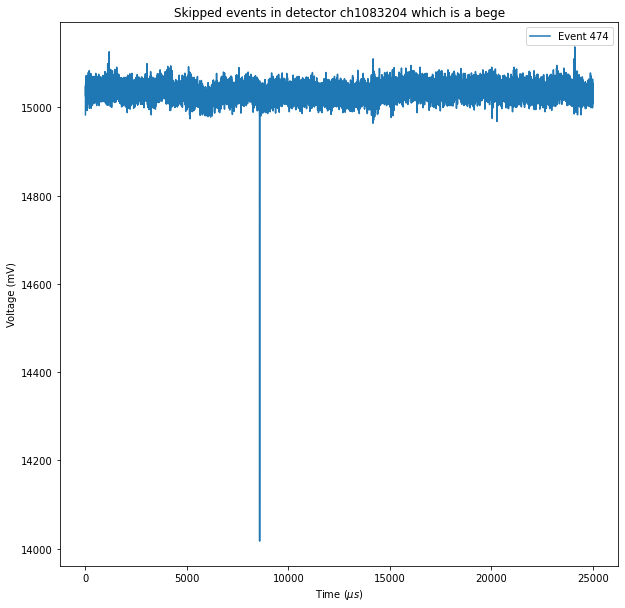

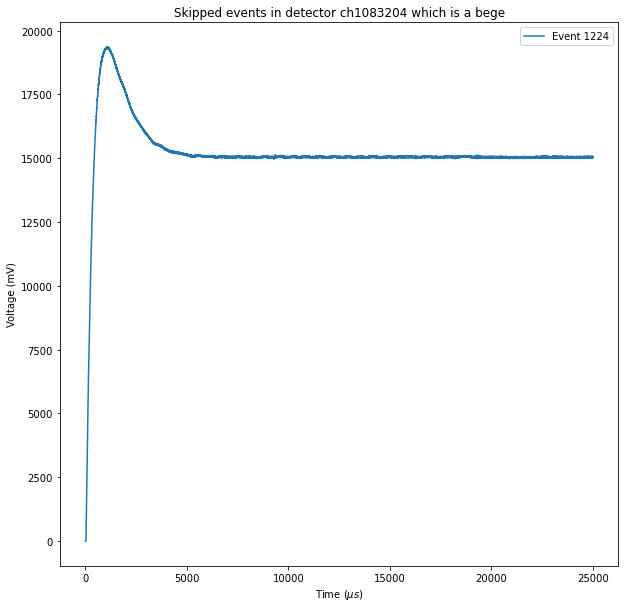

Percentage of discharges present: 0.21246458923512845%
Skipped waveforms for detector ch1083205: [ 408  474  506 1313]


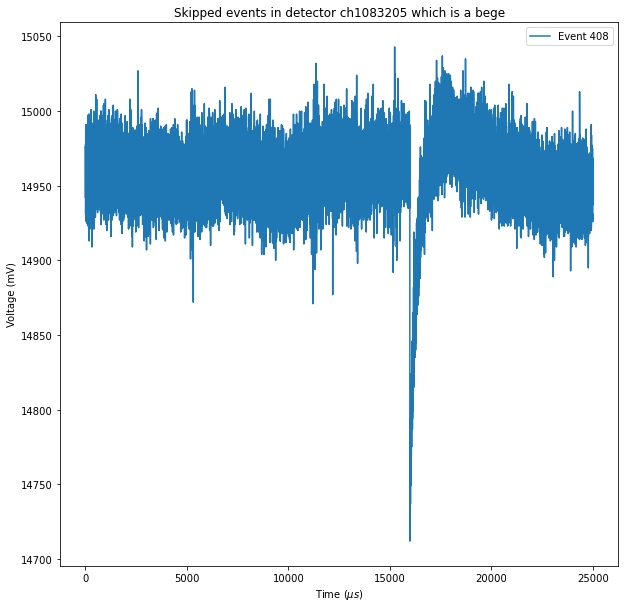

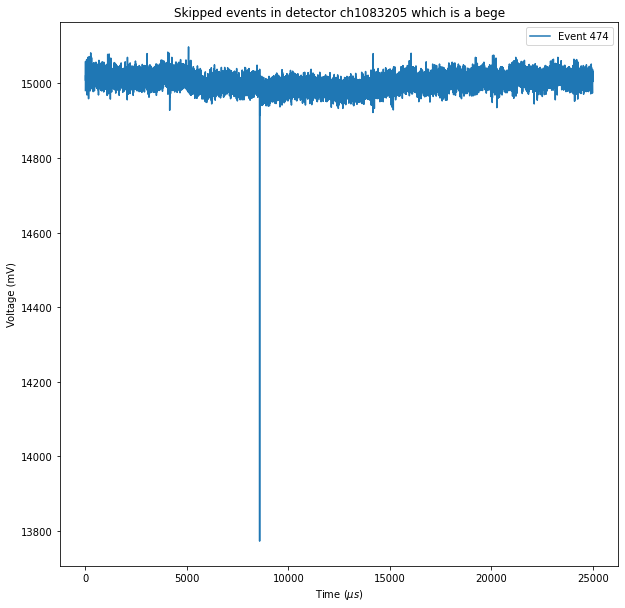

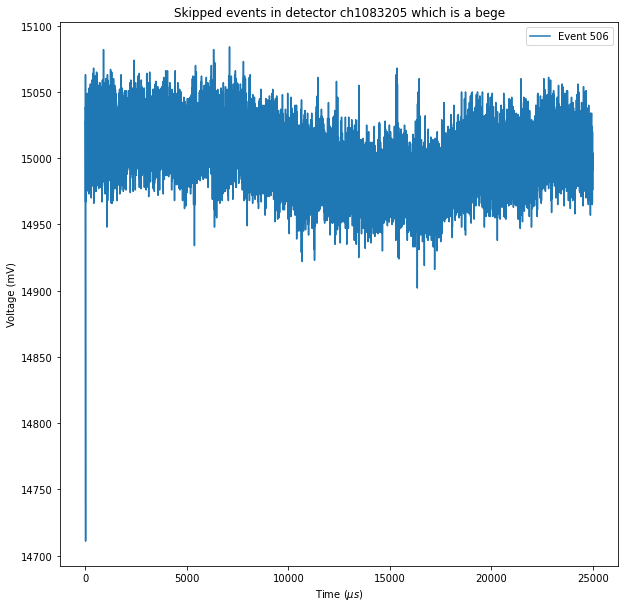

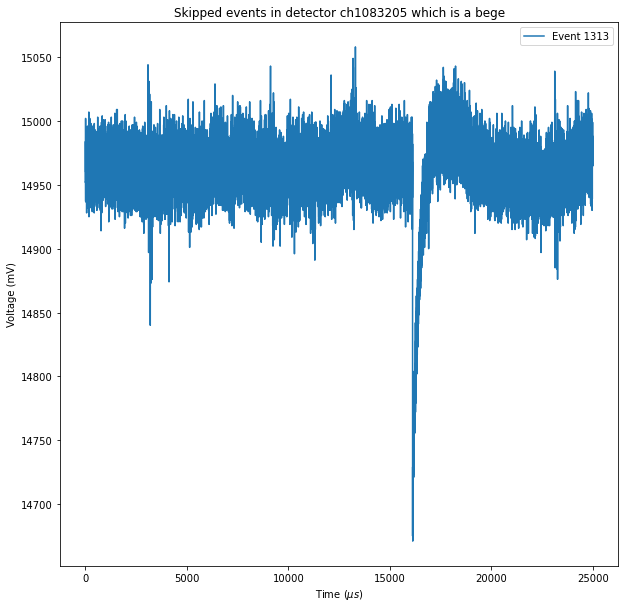

Percentage of discharges present: 0.283286118980175%
Skipped waveforms for detector ch1084800: [ 408  444  474  481 1129]


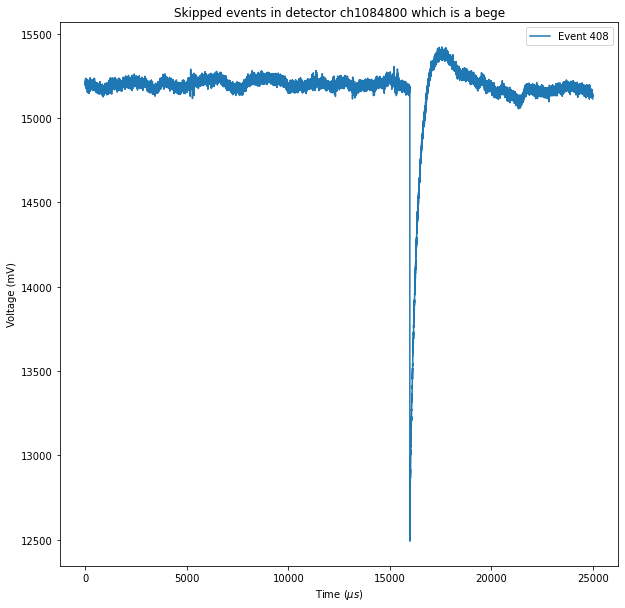

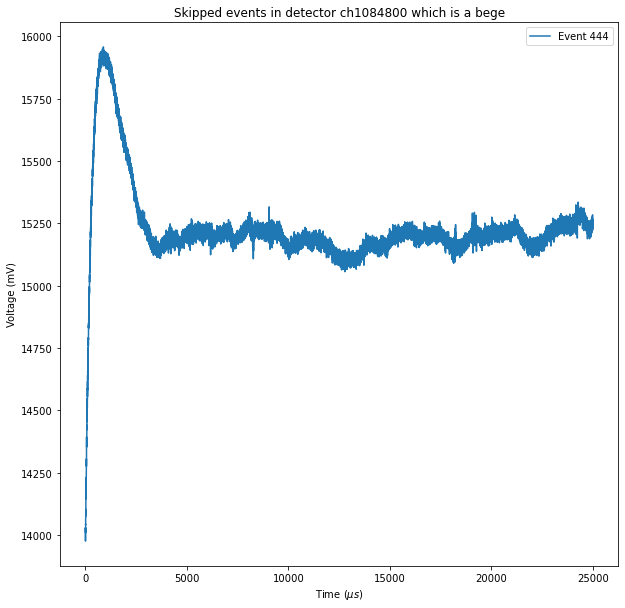

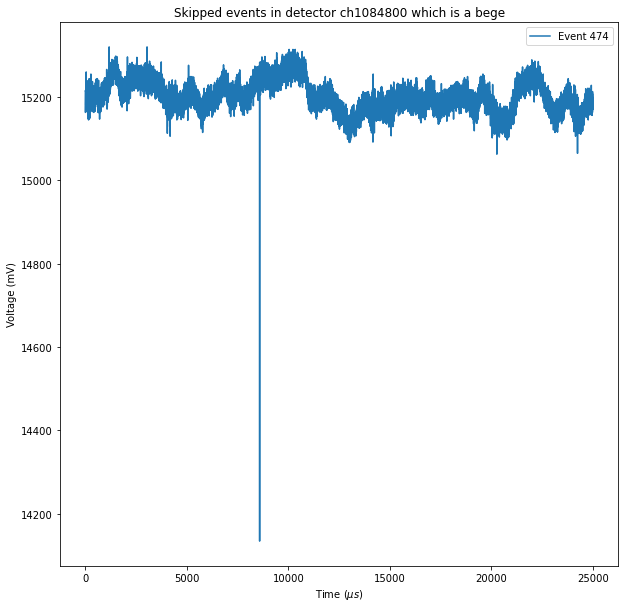

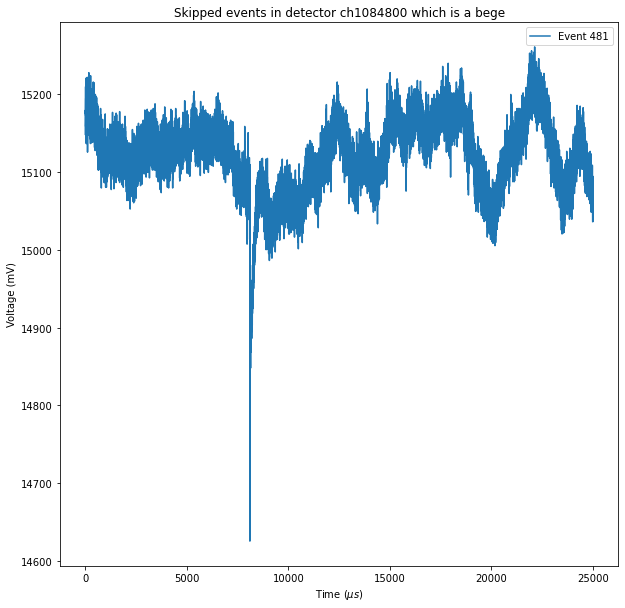

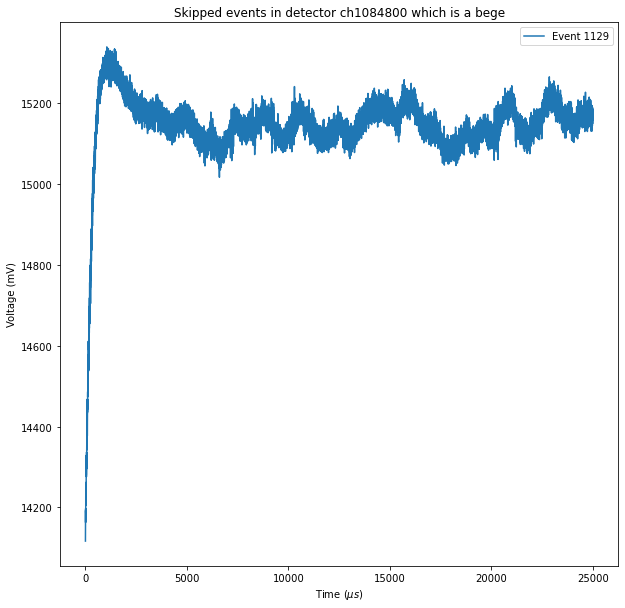

Percentage of discharges present: 0.3541076487252104%
Skipped waveforms for detector ch1084801: [ 444  474  481  791 1129]


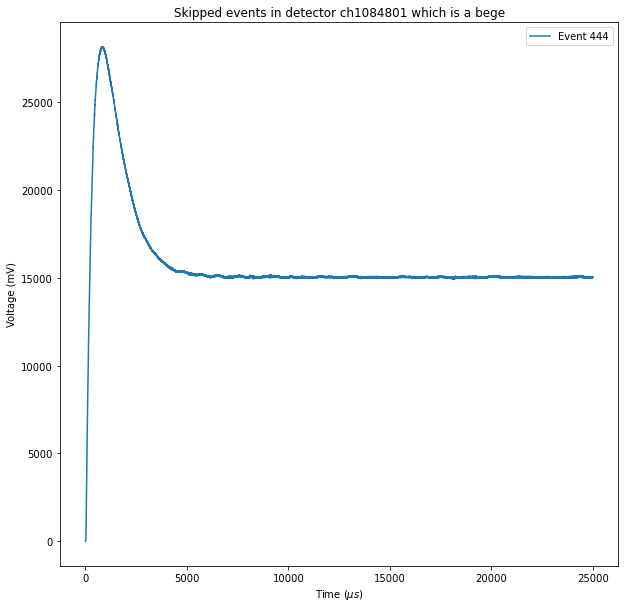

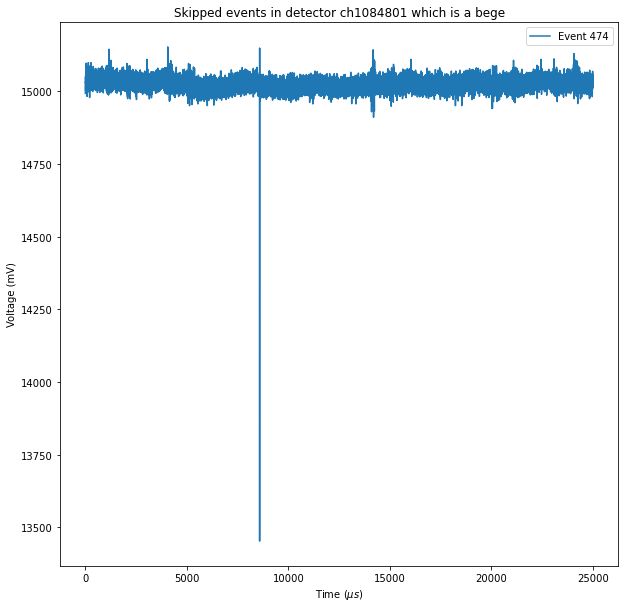

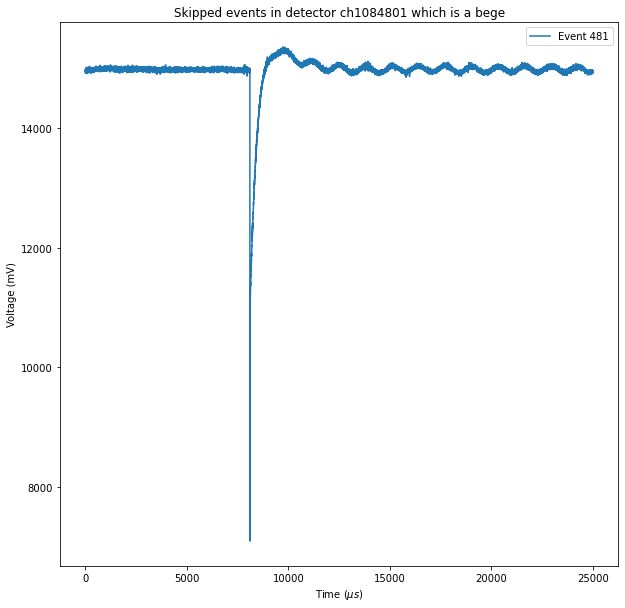

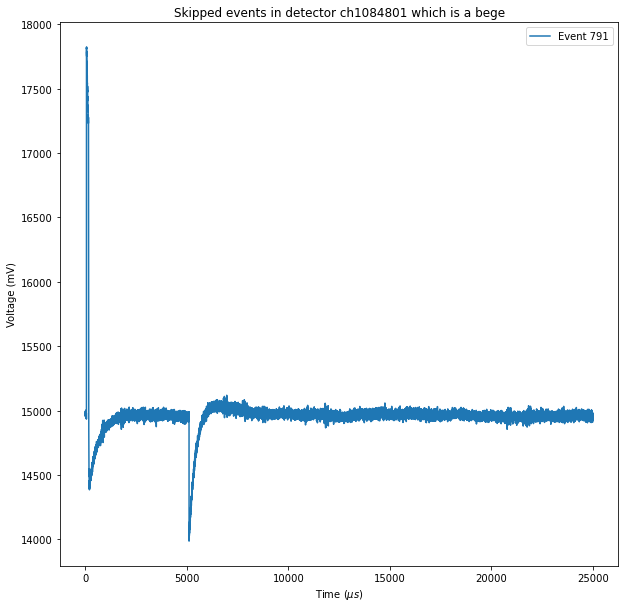

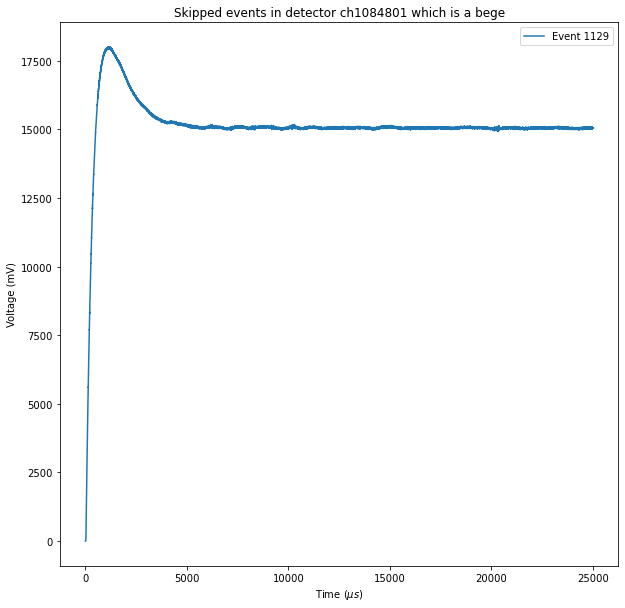

Percentage of discharges present: 0.3541076487252104%
Skipped waveforms for detector ch1084802: [474 495]


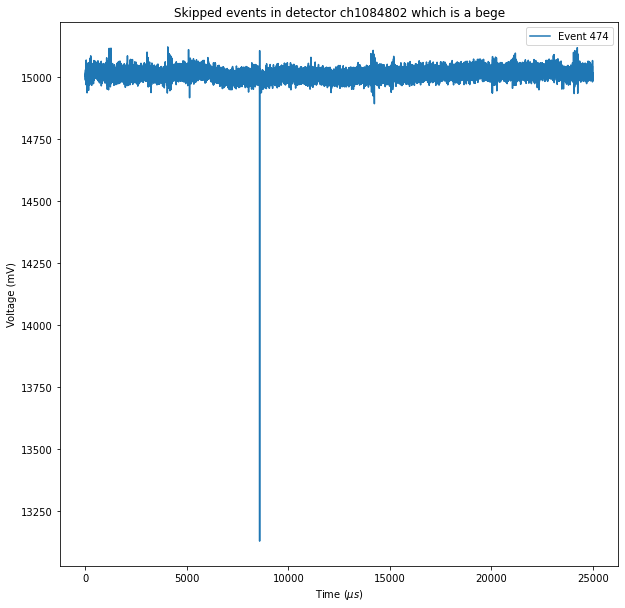

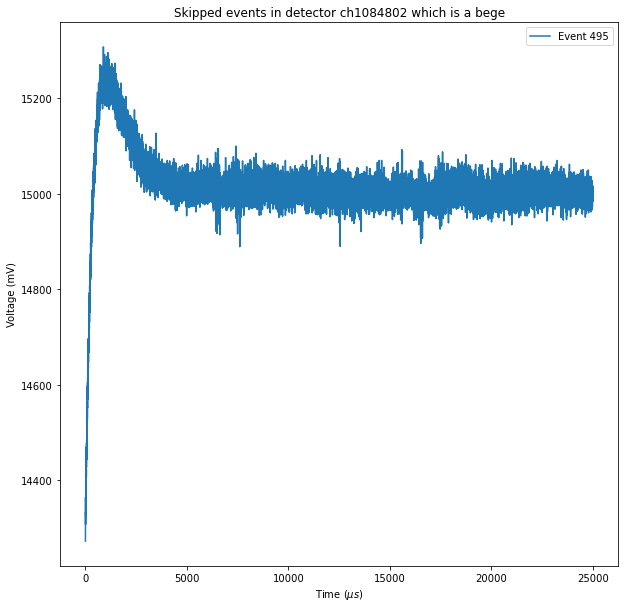

Percentage of discharges present: 0.14164305949008194%
Skipped waveforms for detector ch1086403: []
Percentage of discharges present: 0.0%
Skipped waveforms for detector ch1086404: []
Percentage of discharges present: 0.0%
Skipped waveforms for detector ch1086405: [163]


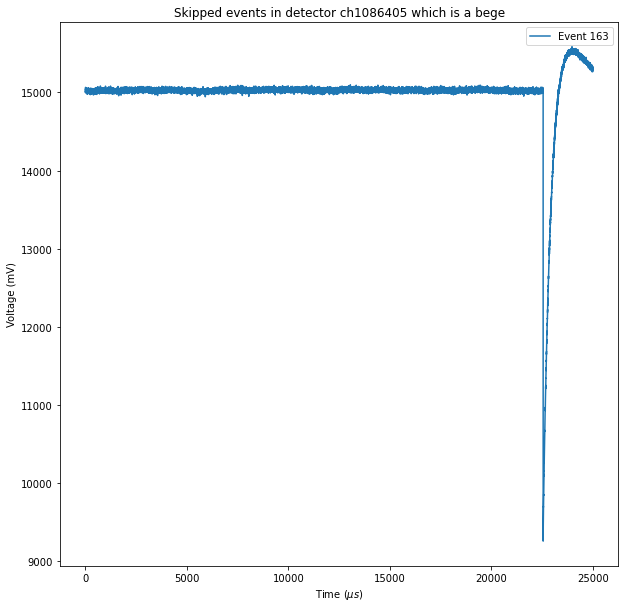

Percentage of discharges present: 0.07082152974504652%


In [27]:
import pandas as pd

df = pd.DataFrame(columns=['Detector Name', 'Percentage of discharge events'])

percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []

for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = final_events[j]

    if len(index_skip1) < 20: 
        skipped_waveforms[j] = index_skip1  
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:] #removes the ch from the detector name 
            test = cmap[x]['type'] #searches the type of detector the detector is 

            plt.plot(ts[:], wf0[:], label=f'Event {i}') 
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

        diff = len(minimum_dict[j]) - len(index_skip1) 
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        #plt.show() 
    else:
        #if the dataset has more than 20 data points then the data set has no discharges
        percent_discharge[j] = 0
        print(f"This detector {j} doesn't have any discharges")

In [28]:
for j in detectors_bege:
    df = df.append({
    'Detector Name': j,
    'Percentage of discharge events':percent_discharge[j],
    }, ignore_index=True)
    

In [ ]:
excel_filename = 'number_of_bege.xlsx'
df.to_excel(excel_filename, index=False)